In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import emc2
import glob
import xarray
import datetime
import calendar
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates
import matplotlib
import pickle
import pandas as pd
import os
from scipy import ndimage
from scipy.ndimage import gaussian_filter
from scipy.interpolate import NearestNDInterpolator as nn
from scipy.interpolate import griddata as griddata
import pandas
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
from file_struct import file_struct as fs
from load_sonde_data import load_sonde_data
from give_me_files_and_subfolders import give_me_files_and_subfolders
from calculate_theta_and_more import calculate_theta_and_more
from scipy.signal import argrelextrema
import seaborn as sns
from dask.distributed import Client, progress, LocalCluster

In [2]:
#--------------------------------------------
# Functions
#--------------------------------------------
def toTimestamp(d):
    return calendar.timegm(d.timetuple())

def toDatetime(d):
    return datetime.datetime.utcfromtimestamp(d)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx],idx   

# function to make serial date numbers which are the number of days that have passed
# since epoch beginning given as days.fraction_of_day
def datenum(d):
        return 366 + d.toordinal() + (d - datetime.datetime.fromordinal(d.toordinal())).total_seconds()/(24*60*60)
#--------------------------------------------

In [3]:
#--------------------------------------------
# Occurrence Frequency
#--------------------------------------------
def occur_freq(data,bins,full_length):
    tmp_hist = []
    for ii in range(len(bins)-1):
        if ii != (len(bins)-2):
            tmpid = np.where((data >= bins[ii]) & (data < bins[ii+1]))
            tmp_hist.append(np.size(tmpid)/full_length)
        elif ii == (len(bins)-2):
            tmpid = np.where((data >= bins[ii]) & (data <= bins[ii+1]))
            tmp_hist.append(np.size(tmpid)/full_length)            
    tmp_hist = np.array(tmp_hist)
    return tmp_hist,bins

In [4]:
# Read in EMC2 files
dirpath = '/mnt/raid/mwstanfo/emc2/micro/'
dirs = glob.glob(dirpath+'20*')
dirs = sorted(dirs)



files = []
for xdir in dirs:
    tmp_files = glob.glob(xdir+'/*.nc')
    tmp_files = sorted(tmp_files)
    files.append(tmp_files)
files = np.concatenate(files)

# Read in E3 files
dirpath = '/mnt/raid/mwstanfo/emc2/e3_run/'
dirs = glob.glob(dirpath+'20*')
dirs = sorted(dirs)



e3_files = []
for xdir in dirs:
    tmp_files = glob.glob(xdir+'/*.nc')
    tmp_files = sorted(tmp_files)
    e3_files.append(tmp_files)
e3_files = np.concatenate(e3_files)
print(len(files))
print(len(e3_files))

96
96


In [5]:
ncfile = xarray.open_dataset(files[0])

In [6]:
height = np.array(ncfile['z'].copy())

In [11]:
print(np.shape(height))
mean_height = np.mean(height,axis=0)
print(np.shape(mean_height))
print(mean_height)
print(np.diff(mean_height))

(1488, 65)
(65,)
[   41.668697   125.44255    209.90848    295.0889     380.99472
   467.63434    555.02496    643.185      732.13306    826.3986
   930.67883   1045.282     1170.572     1306.9824    1450.1793
  1595.5829    1743.2609    1893.3267    2045.9255    2201.1584
  2359.087     2519.8079    2688.9246    2872.4482    3071.1912
  3286.0813    3518.2       3768.7375    4039.0752    4320.9
  4604.9556    4891.186     5179.525     5469.937     5762.3877
  6056.8267    6353.17      6651.2935    6951.0986    7252.4907
  7555.336     7859.5127    8164.8716    8471.37      8778.96
  9087.674     9397.686     9709.227    10022.561    10337.983
 10655.719    10975.694    11297.297    11628.183    11977.601
 12347.464    12740.011    13149.       13568.136    13999.44
 14443.667    14901.229    15372.896    15859.829    16362.392   ]
[ 83.77385   84.46593   85.18042   85.90582   86.63962   87.390625
  88.160034  88.94806   94.265564 104.28021  114.60315  125.29004
 136.4104   143.1969   

In [5]:
def process_file(file,e3_file):
    var_dict = {}

    ncfile = xarray.open_dataset(file)
    var_dict['time'] = ncfile.coords['time'].values
    var_dict['z'] = np.squeeze(ncfile['z'].values)
    ref = np.squeeze(ncfile['sub_col_Ze_att_tot'].values)
    var_dict['ref'] = np.transpose(ref,axes=(1,2,0))
    vel = np.squeeze(ncfile['sub_col_Vd_tot_strat'].values)
    var_dict['vel'] = np.transpose(vel,axes=(1,2,0))
    beta_att = np.squeeze(ncfile['sub_col_beta_att_tot'].values)
    var_dict['beta_att'] = np.transpose(beta_att,axes=(1,2,0))
    var_dict['level'] = ncfile['level'].values
    detect_mask = np.squeeze(ncfile['detect_mask'].values)
    var_dict['detect_mask'] = detect_mask
    strat_qcl = np.squeeze(ncfile['strat_q_subcolumns_cl'].values)
    strat_qcl = np.transpose(strat_qcl,axes=(1,2,0))
    strat_qci = np.squeeze(ncfile['strat_q_subcolumns_ci'].values)
    strat_qci = np.transpose(strat_qci,axes=(1,2,0))
    strat_qpl = np.squeeze(ncfile['strat_q_subcolumns_pl'].values)
    strat_qpl = np.transpose(strat_qpl,axes=(1,2,0))
    strat_qpi = np.squeeze(ncfile['strat_q_subcolumns_pi'].values)
    strat_qpi = np.transpose(strat_qpi,axes=(1,2,0))
    conv_qcl = np.squeeze(ncfile['conv_q_subcolumns_cl'].values)
    conv_qcl = np.transpose(conv_qcl,axes=(1,2,0))
    conv_qci = np.squeeze(ncfile['conv_q_subcolumns_ci'].values)
    conv_qci = np.transpose(conv_qci,axes=(1,2,0))
    conv_qpl = np.squeeze(ncfile['conv_q_subcolumns_pl'].values)
    conv_qpl = np.transpose(conv_qpl,axes=(1,2,0))
    conv_qpi = np.squeeze(ncfile['conv_q_subcolumns_pi'].values)
    conv_qpi = np.transpose(conv_qpi,axes=(1,2,0))
    strat_frac_subcolumns_cl = np.squeeze(ncfile['strat_frac_subcolumns_cl'].values)
    strat_frac_subcolumns_cl = np.transpose(strat_frac_subcolumns_cl,axes=(1,2,0))
    conv_frac_subcolumns_cl = np.squeeze(ncfile['conv_frac_subcolumns_cl'].values)
    conv_frac_subcolumns_cl = np.transpose(conv_frac_subcolumns_cl,axes=(1,2,0))
    ncfile.close()
    
    var_dict['conv_frac_subcolumns_cl'] = conv_frac_subcolumns_cl
    var_dict['strat_frac_subcolumns_cl'] = strat_frac_subcolumns_cl
    var_dict['strat_qcl'] = strat_qcl
    var_dict['conv_qcl'] = conv_qcl
    
    tot_qcl = strat_qcl + conv_qcl
    
    ncfile = xarray.open_dataset(e3_file)
    vm_mcci = np.array(np.squeeze(ncfile['vm_mcci'])) # Mass-Weighted Convective Cloud Ice Fall Speed m/s
    vm_mccl = np.array(np.squeeze(ncfile['vm_mccl'])) # Mass-Weighted Convective Cloud Liquid Fall Speed m/s
    vm_mcpi = np.array(np.squeeze(ncfile['vm_mcpi'])) # Mass-Weighted Convective Precipitating Ice Fall Speed m/s
    vm_mcpl = np.array(np.squeeze(ncfile['vm_mcpl'])) # Mass-Weighted Convective Precipitating Liquid Fall Speed m/s
    
    vm_ssci = np.array(np.squeeze(ncfile['vm_ssci'])) # Mass-Weighted Stratiform Cloud Ice Fall Speed m/s
    vm_sscl = np.array(np.squeeze(ncfile['vm_sscl'])) # Mass-Weighted Stratiform Cloud Water Fall Speed m/s
    vm_sspi = np.array(np.squeeze(ncfile['vm_sspi'])) # Mass-Weighted Stratiform Snow Fall Speed m/s
    vm_sspl = np.array(np.squeeze(ncfile['vm_sspl'])) # Mass-Weighted Stratiform Rain Fall Speed m/s

    ncfile.close()
    
    # state variables
    # pressure
    pres = np.array(np.squeeze(ncfile['p_3d'])) # mb/hPa
    # convert to Pa
    pres = pres*100
    
    # temperature
    temp = np.array(np.squeeze(ncfile['t'])) # K
    # specific humidity
    q = np.array(np.squeeze(ncfile['q'])) # kg/kg
    # rh
    rhw = np.array(np.squeeze(ncfile['rhw'])) # %

    # calculate virtual temperature
    epsilon = 0.622
    tv = temp * ( (q + epsilon) / (epsilon*(1 + q)) ) 
    
    # compute air density
    R=287. #J/K/kg
    rho = pres/(tv*R)

    # calculate precipitation rates by multiplying
    # the condensed water content by the fall velocity
    dum_arr = np.zeros(np.shape(conv_qci))
    conv_pi_pr = dum_arr.copy()
    conv_pl_pr = dum_arr.copy()
    strat_pi_pr = dum_arr.copy()
    strat_pl_pr = dum_arr.copy()
    
    tot_clwc = dum_arr.copy()
    strat_clwc = dum_arr.copy()
    conv_clwc = dum_arr.copy()
    
    for dumi in range(8):
        conv_clwc[:,:,dumi] = conv_qcl[:,:,dumi]*rho
        strat_clwc[:,:,dumi] = strat_qcl[:,:,dumi]*rho
        
        conv_pi_pr[:,:,dumi] = conv_qpi[:,:,dumi]*rho*vm_mcpi*3600
        conv_pl_pr[:,:,dumi] = conv_qpl[:,:,dumi]*rho*vm_mcpl*3600

        strat_pi_pr[:,:,dumi] = strat_qpi[:,:,dumi]*vm_sspi*3600
        strat_pl_pr[:,:,dumi] = strat_qpl[:,:,dumi]*vm_sspl*3600
        
        tot_clwc[:,:,dumi] = tot_qcl[:,:,dumi]*rho
    
    conv_pr = (conv_pi_pr + conv_pl_pr)
    strat_pr = (strat_pi_pr + strat_pl_pr)
    tot_pr = conv_pr + strat_pr

    precip_rates = {'conv_pi_pr':conv_pi_pr,\
                   'conv_pl_pr':conv_pl_pr,\
                   'strat_pi_pr':strat_pi_pr,\
                   'strat_pl_pr':strat_pl_pr,\
                   'conv_pr':conv_pr,\
                   'strat_pr':strat_pr,\
                   'tot_pr':tot_pr,\
                   'conv_clwc':conv_clwc,\
                   'strat_clwc':strat_clwc,\
                   'rho':rho,\
                   'temp':temp,\
                   'rhw':rhw,\
                    'tot_qcl':tot_qcl,\
                    'tot_clwc':tot_clwc,\
                   }
        
    for key,val in precip_rates.items():
        var_dict[key] = val        
    

    return var_dict    

In [48]:
dumx = 400
dumy = 300
dum = np.zeros((dumx,dumy),dtype='datetime64[s]')
print(np.shape(dum))

(400, 300)


In [6]:
def calc_cbh(conv_frac_subcolumns_cl,strat_frac_subcolumns_cl,time,height):
    #---------------------------        
    # calculate CBHs
    #---------------------------     
    num_subs = 8
    cbh_subs = np.zeros((len(time),num_subs))
    cbh_subs_id = np.zeros((len(time),num_subs))
        
    for tt in range(len(time)):
        
        cbh = np.zeros(len(time))
        cbh_id = np.zeros(len(time))
        
        for ii in range(num_subs):
            single_time_conv_frac_subcolumns_cl = conv_frac_subcolumns_cl[tt,:,ii]
            single_time_strat_frac_subcolumns_cl = strat_frac_subcolumns_cl[tt,:,ii]
            
            single_time_z = height[tt,:]
            
            dum_cloud_mask = np.zeros(len(single_time_conv_frac_subcolumns_cl))
            tmpid = np.where(single_time_conv_frac_subcolumns_cl == True)
            if np.size(tmpid) > 0.:
                dum_cloud_mask[tmpid] = 1
            tmpid = np.where(single_time_strat_frac_subcolumns_cl == True)
            if np.size(tmpid) > 0.:
                dum_cloud_mask[tmpid] = 1
            liq_cloud_id = np.where(dum_cloud_mask == 1.)
            if np.size(liq_cloud_id) > 0.:
                liq_cloud_id = liq_cloud_id[0]
                cbh[tt] = single_time_z[liq_cloud_id[0]]
                cbh_id[tt] = liq_cloud_id[0]
            else:
                cbh[tt] = np.nan
                cbh_id[tt] = np.nan
                
            cbh_subs[tt,ii] = cbh[tt]
            cbh_subs_id[tt,ii] = cbh_id[tt]
            
    return cbh_subs,cbh_subs_id

In [74]:
#-------------------------------------------
#
#-------------------------------------------
def make_dict(files,e3_file3):

    num_files = len(files)

    cbh_pr_all = []
    cbh_Ze_all = []
    cbh_clwc_all = []
    cbh_beta_att_all = []
    cbh_all = []
    precip_id_all = []
    sfc_precip_id_all = []
    precip_to_sfc_binary_all = []
    ceil_only_id_all = []
    cbt_all = []
    cth_all = []
    ctt_all = []
    c_thick_all = []
    time_cloud_all = []
    cbh_detect_mask_all = []
    fog_id_all = []
    for ii in range(num_files):
        print('% Done:',((ii+1.)/num_files*100.))
        outdict = process_file(files[ii],e3_files[ii])
        #--------------------------------
        # Calculate CBH and Rcb
        #--------------------------------
        tot_qcl = outdict['tot_qcl']
        time = outdict['time']
        tot_clwc = outdict['tot_clwc']
        conv_qcl = outdict['conv_qcl']
        strat_qcl = outdict['strat_qcl']
        rho = outdict['rho']
        height = outdict['z']
        ref = outdict['ref']
        beta_att = outdict['beta_att']
        level = outdict['level']
        detect_mask = outdict['detect_mask']
        #return detect_mask,ref
        tot_pr = outdict['tot_pr']
        temp = outdict['temp']
        conv_frac_subcolumns_cl = outdict['conv_frac_subcolumns_cl']
        strat_frac_subcolumns_cl = outdict['strat_frac_subcolumns_cl']

        # Calculate CBH
        cbh,cbh_ids = calc_cbh(conv_frac_subcolumns_cl,strat_frac_subcolumns_cl,time,height)
        

        cbh_pr = np.zeros(np.shape(cbh))
        cbh_clwc = np.zeros(np.shape(cbh))
        cbh_Ze = np.zeros(np.shape(cbh))
        cbh_beta_att = np.zeros(np.shape(cbh))
        cbt = np.zeros(np.shape(cbh))
        ctt = np.zeros(np.shape(cbh))
        cth = np.zeros(np.shape(cbh))
        cbh_detect_mask = np.zeros(np.shape(cbh))
        c_thick = np.zeros(np.shape(cbh))
        time_cloud = np.zeros(np.shape(cbh),dtype='datetime64[s]')
        precip_id = np.zeros(np.shape(cbh))
        ceil_only_id = np.zeros(np.shape(cbh))
        sfc_precip_id = np.zeros(np.shape(cbh))
        precip_to_sfc_binary = np.zeros(np.shape(cbh))
        fog_id = np.zeros(np.shape(cbh))
        
        for tt in range(len(time)):
            for ii in range(8):
                if ~np.isnan(cbh[tt,ii]):
                    dumid = int(cbh_ids[tt,ii])
                    
                    cbh_clwc[tt,ii] = tot_clwc[tt,dumid,ii]
                    cbh_Ze[tt,ii] = ref[tt,dumid,ii]
                    cbh_beta_att[tt,ii] = beta_att[tt,dumid,ii]
                    time_cloud[tt,ii] = time[tt]
                    cbh_detect_mask[tt,ii] = detect_mask[tt,dumid,ii]
                    
                    #-------------------------------------
                    #-------------------------------------
                    # Fog ID
                    #-------------------------------------
                    #-------------------------------------
                    # Come down from cloud base
                    # and determine whether or not there is a decade decrease in
                    # magnitude before reaching the lowest bin.
                    if cbh[tt,ii] < 250.:
                        if cbh_ids[tt,ii] == 0.0:
                            if (cbh_beta_att[tt,ii] >= 10.**(-4.5)):
                                fog_id[tt,ii] = 1
                            else:
                                fog_id[tt,ii] = 0.
                        else:
                            below_cbh_beta_att = beta_att[tt,:dumid,ii]
                            min_below_cbh_beta_att_log = np.log10(np.nanmin(below_cbh_beta_att))
                            cbh_beta_att_log = np.log10(cbh_beta_att[tt,ii])
                            dumdiff = cbh_beta_att_log - min_below_cbh_beta_att_log
                            if (cbh_beta_att_log >= -4.5) & (dumdiff < 1.):
                                fog_id[tt,ii] = 1
                            else:
                                fog_id[tt,ii] = 0
                    else:
                        fog_id[tt,ii] = np.nan

                    
                    if not detect_mask[tt,dumid,ii]:
                        sfc_detect_mask = detect_mask[tt,0,ii]
                        sfc_ref = ref[tt,0,ii]
                        sfc_pr = tot_pr[tt,0,ii]
                        
                        ceil_only_id[tt,ii] = 0
                        cbh_pr[tt,ii] = tot_pr[tt,dumid,ii]
                        # Calculate cloud top height, temperature, and thickness
                        single_time_ref = ref[tt,:,ii]
                        single_time_detect_mask = detect_mask[tt,:,ii]
                        ref_above_cbh_prof = single_time_ref[dumid:]
                        detect_mask_above_cbh_prof = single_time_detect_mask[dumid:]
                        height_above_cbh_prof = height[tt,dumid:]
                        temp_above_cbh_prof = temp[tt,dumid:]
                        
                        detect_mask_below_cbh_prof = single_time_detect_mask[0:dumid]
                        pr_below_cbh_prof = tot_pr[tt,0:dumid,ii]
                        


                        cloud_layer_mask = np.zeros(len(ref_above_cbh_prof))
                        # Mark CBH as a "1" in cloud_layer_mask
                        cloud_layer_mask[0] = 1
                        valid_ref_id = np.where( (~np.isnan(ref_above_cbh_prof)) & (detect_mask_above_cbh_prof == False))
                        if np.size(valid_ref_id) > 0.:
                            cloud_layer_mask[valid_ref_id] = 1

                        # Identify contiguous cloudy grid cells
                        cloud_Objects,num_cloud_objects = ndimage.label(cloud_layer_mask)
                        first_cloud_object_mask_id = np.where(cloud_Objects == 1)[0]
                        cth[tt,ii] = height_above_cbh_prof[first_cloud_object_mask_id[-1]]
                        ctt[tt,ii] = temp_above_cbh_prof[first_cloud_object_mask_id[-1]]
                        cbt[tt,ii] = temp_above_cbh_prof[first_cloud_object_mask_id[0]]
                        c_thick[tt,ii] = cth[tt,ii] - cbh[tt,ii]

                        if cbh_pr[tt,ii] > 0.:
                            precip_id[tt,ii] = 1.
                               
                            dumid = np.where( (detect_mask_below_cbh_prof == False) & (pr_below_cbh_prof > 0.) )
                            if np.size(dumid) > 0.:
                                dumid_size = np.size(dumid)
                                dum_size = np.size(pr_below_cbh_prof)
                                if dum_size == dumid_size:
                                    precip_to_sfc_binary[tt,ii] = 1.
                                else:
                                    precip_to_sfc_binary[tt,ii] = 0.
                            else:
                                precip_to_sfc_binary[tt,ii] = 0.                            

                            
                            #if (sfc_detect_mask == False) and (~np.isnan(sfc_ref)):
                            if sfc_pr > 0.:
                                sfc_precip_id[tt,ii] = 1.
                            else:
                                sfc_precip_id[tt,ii] = 0.
                        else:
                            precip_id[tt,ii] = 0.
                            sfc_precip_id[tt,ii] = 0.
                            precip_to_sfc_binary[tt,ii] = np.nan


                        if np.isnan(cbh_pr[tt,ii]):
                            raise RuntimeError('WTF dummy')
                    else:
                        cbh_pr[tt,ii] = np.nan
                        precip_id[tt,ii] = 0
                        sfc_precip_id[tt,ii] = 0
                        cbt[tt,ii] = temp[tt,dumid]
                        ceil_only_id[tt,ii] = 1
                        ctt[tt,ii] = temp[tt,dumid]
                        cth[tt,ii] = cbh[tt,ii]
                        c_thick[tt,ii] = 0
                        precip_to_sfc_binary[tt,ii] = np.nan
                else:
                    cbh_pr[tt,ii] = np.nan
                    cbh_Ze[tt,ii] = np.nan
                    cbh_clwc[tt,ii] = np.nan
                    cbh_beta_att[tt,ii] = np.nan
                    precip_id[tt,ii] = np.nan
                    cbt[tt,ii] = np.nan
                    c_thick[tt,ii] = np.nan
                    ctt[tt,ii] = np.nan
                    cth[tt,ii] = np.nan
                    cbh_detect_mask[tt,ii] = np.nan
                    ceil_only_id[tt,ii] = np.nan
                    sfc_precip_id[tt,ii] = np.nan
                    precip_to_sfc_binary[tt,ii] = np.nan
                    fog_id[tt,ii] = np.nan

                    
        
        cbh_pr = np.ndarray.flatten(cbh_pr)
        cbh_clwc = np.ndarray.flatten(cbh_clwc)
        cbh_Ze = np.ndarray.flatten(cbh_Ze)
        cbh_beta_att = np.ndarray.flatten(cbh_beta_att)
        time_cloud = np.ndarray.flatten(time_cloud)
        cbh_detect_mask = np.ndarray.flatten(time_cloud)
        ceil_only_id = np.ndarray.flatten(ceil_only_id)
        sfc_precip_id = np.ndarray.flatten(sfc_precip_id)
        precip_to_sfc_binary = np.ndarray.flatten(precip_to_sfc_binary)
        fog_id = np.ndarray.flatten(fog_id)
        time_cloud = np.array([pd.to_datetime(time_cloud[dd]) for dd in range(len(time_cloud))])
        
        cbh = np.ndarray.flatten(cbh)
        precip_id = np.ndarray.flatten(precip_id)
        cbt = np.ndarray.flatten(cbt)
        ctt = np.ndarray.flatten(ctt)
        cth = np.ndarray.flatten(cth)
        c_thick = np.ndarray.flatten(c_thick)

        cbh_pr_all.append(cbh_pr)
        cbh_Ze_all.append(cbh_Ze)
        cbh_clwc_all.append(cbh_clwc)
        cbh_beta_att_all.append(cbh_beta_att)
        cbh_all.append(cbh)
        precip_id_all.append(precip_id)
        cbt_all.append(cbt)
        ctt_all.append(ctt)
        cth_all.append(cth)
        c_thick_all.append(c_thick)
        time_cloud_all.append(time_cloud)
        cbh_detect_mask_all.append(cbh_detect_mask)
        ceil_only_id_all.append(ceil_only_id)
        sfc_precip_id_all.append(sfc_precip_id)
        precip_to_sfc_binary_all.append(precip_to_sfc_binary)
        fog_id_all.append(fog_id)

    precip_id_all = np.concatenate(precip_id_all)
    cbh_all = np.concatenate(cbh_all)
    cbh_pr_all = np.concatenate(cbh_pr_all)
    cbh_Ze_all = np.concatenate(cbh_Ze_all)
    cbh_clwc_all = np.concatenate(cbh_clwc_all)
    cbh_beta_att_all = np.concatenate(cbh_beta_att_all)
    cbt_all = np.concatenate(cbt_all)
    ctt_all = np.concatenate(ctt_all)
    cth_all = np.concatenate(cth_all)
    c_thick_all = np.concatenate(c_thick_all)
    time_cloud_all = np.concatenate(time_cloud_all)
    cbh_detect_mask_all = np.concatenate(cbh_detect_mask_all)
    ceil_only_id_all = np.concatenate(ceil_only_id_all)
    sfc_precip_id_all = np.concatenate(sfc_precip_id_all)
    precip_to_sfc_binary = np.concatenate(precip_to_sfc_binary_all)
    fog_id = np.concatenate(fog_id_all)

    time_all = time_cloud_all
    
       
    #cloud_id = np.where(~np.isnan(precip_id_all))
    cloud_id = np.where( (~np.isnan(precip_id_all)) & ( (cbt_all-273.15) > -38.) & ( (ctt_all-273.15) > -38.) & (cbh_all < 7700.))
    #cloud_id = np.where( (~np.isnan(precip_id_all)) & ( (cbt_all-273.15) > -38.) & ( (ctt_all-273.15) > -38.) & (cbh_all < 7700.))
    rcb = cbh_pr_all[cloud_id]
    cb_Ze = cbh_Ze_all[cloud_id]
    cb_clwc = cbh_clwc_all[cloud_id]
    cb_beta_att = cbh_beta_att_all[cloud_id]
    cb_detect_mask = cbh_detect_mask_all[cloud_id]
    ceil_only_id = ceil_only_id_all[cloud_id]
    
    precip_binary = precip_id_all[cloud_id]
    precip_to_sfc_binary = precip_to_sfc_binary[cloud_id]
    ctt = ctt_all[cloud_id]
    cbt = cbt_all[cloud_id]
    c_thick = c_thick_all[cloud_id]
    cth = cth_all[cloud_id]
    cbh = cbh_all[cloud_id]
    time_cloud = time_cloud_all[cloud_id]
    fog_id = fog_id[cloud_id]
    sfc_precip_binary = sfc_precip_id_all[cloud_id]
    tot_size = len(cbh_all)
    cloud_size = np.size(cloud_id)
    dum_cloud_frac = cloud_size/tot_size
    
    years = np.array([(pd.to_datetime(time_cloud[dd])).year for dd in range(len(time_cloud))])
    months = np.array([(pd.to_datetime(time_cloud[dd])).month for dd in range(len(time_cloud))])
    
    #print(time_cloud)
    out_dict = {'precip_binary':precip_binary,\
                'ctt':ctt,\
                'cbt':cbt,\
                'cth':cth,\
                'cbh':cbh,\
                'rcb':rcb,\
                'c_thick':c_thick,\
                'cb_Ze':cb_Ze,\
                'cb_clwc':cb_clwc,\
                'cb_beta_att':cb_beta_att,\
                'cb_detect_mask':cb_detect_mask,\
                'cloud_frac':dum_cloud_frac,\
                'tot_time':time_all,\
                'time':time_cloud,\
                'ceil_only_id':ceil_only_id,\
                'sfc_precip_binary':sfc_precip_binary,\
                'precip_to_sfc_binary':precip_to_sfc_binary,\
                'fog_id':fog_id,\
                'years':years,\
                'months':months}
                        
    return out_dict

In [75]:
out_dict = make_dict(files,e3_files)
save_path = '/mnt/raid/mwstanfo/emc2/micro/'
outfile = 'emc2_processed.p'
out_pkl_file = save_path+outfile
pickle.dump(out_dict,open(out_pkl_file,"wb"))

% Done: 1.0416666666666665
% Done: 2.083333333333333
% Done: 3.125
% Done: 4.166666666666666
% Done: 5.208333333333334
% Done: 6.25
% Done: 7.291666666666667
% Done: 8.333333333333332
% Done: 9.375
% Done: 10.416666666666668
% Done: 11.458333333333332
% Done: 12.5
% Done: 13.541666666666666
% Done: 14.583333333333334
% Done: 15.625
% Done: 16.666666666666664
% Done: 17.708333333333336
% Done: 18.75
% Done: 19.791666666666664
% Done: 20.833333333333336
% Done: 21.875
% Done: 22.916666666666664
% Done: 23.958333333333336
% Done: 25.0
% Done: 26.041666666666668
% Done: 27.083333333333332
% Done: 28.125
% Done: 29.166666666666668
% Done: 30.208333333333332
% Done: 31.25
% Done: 32.29166666666667
% Done: 33.33333333333333
% Done: 34.375
% Done: 35.41666666666667
% Done: 36.45833333333333
% Done: 37.5
% Done: 38.54166666666667
% Done: 39.58333333333333
% Done: 40.625
% Done: 41.66666666666667
% Done: 42.70833333333333
% Done: 43.75
% Done: 44.79166666666667
% Done: 45.83333333333333
% Done: 

/tmp/ipykernel_39231/4019113399.py:77: RuntimeWarning: invalid value encountered in divide
  rho = pres/(tv*R)


% Done: 63.541666666666664
% Done: 64.58333333333334
% Done: 65.625
% Done: 66.66666666666666
% Done: 67.70833333333334
% Done: 68.75
% Done: 69.79166666666666
% Done: 70.83333333333334
% Done: 71.875
% Done: 72.91666666666666
% Done: 73.95833333333334
% Done: 75.0
% Done: 76.04166666666666
% Done: 77.08333333333334
% Done: 78.125
% Done: 79.16666666666666
% Done: 80.20833333333334
% Done: 81.25
% Done: 82.29166666666666
% Done: 83.33333333333334
% Done: 84.375
% Done: 85.41666666666666
% Done: 86.45833333333334
% Done: 87.5
% Done: 88.54166666666666
% Done: 89.58333333333334
% Done: 90.625
% Done: 91.66666666666666
% Done: 92.70833333333334
% Done: 93.75
% Done: 94.79166666666666
% Done: 95.83333333333334
% Done: 96.875
% Done: 97.91666666666666
% Done: 98.95833333333334
% Done: 100.0


In [73]:
out_dict = make_dict(files[0:2],e3_files[0:2])
#ncfile = xarray.open_dataset(files[0])
#ncfile.coords['time'].values

% Done: 50.0
% Done: 100.0
14199
14199
14199
[2013 2013 2013 ... 2013 2013 2013]


In [76]:
out_dict.keys()

dict_keys(['precip_binary', 'ctt', 'cbt', 'cth', 'cbh', 'rcb', 'c_thick', 'cb_Ze', 'cb_clwc', 'cb_beta_att', 'cb_detect_mask', 'cloud_frac', 'tot_time', 'time', 'ceil_only_id', 'sfc_precip_binary', 'precip_to_sfc_binary', 'fog_id', 'years', 'months'])

In [78]:
out_dict['tot_time']

array([Timestamp('2013-01-01 00:15:00'), Timestamp('2013-01-01 00:15:00'),
       Timestamp('2013-01-01 00:15:00'), ...,
       Timestamp('1970-01-01 00:00:00'), Timestamp('1970-01-01 00:00:00'),
       Timestamp('1970-01-01 00:00:00')], dtype=object)

In [79]:
len(out_dict['tot_time'])

1121280

In [7]:
save_path = '/mnt/raid/mwstanfo/emc2/micro/'
infile = 'emc2_processed.p'
in_pkl_file = save_path+infile
out_dict = pickle.load(open(in_pkl_file,"rb"))

In [166]:
# Pull in MICRE obs
path = '/mnt/raid/mwstanfo/micre_cloud_properties/'
infile = path+'micre_cloud_properties_dict_all_vb.p'
var_dict_cloud = pickle.load(open(infile,"rb"))
micre_precip_binary = var_dict_cloud['precip_binary']
micre_precip_to_sfc_binary = var_dict_cloud['precip_to_sfc_binary']
micre_sfc_precip_binary = var_dict_cloud['sfc_precip_binary']
micre_ref_mean_bel = var_dict_cloud['ref_mean_bel']
micre_cbh = var_dict_cloud['cbh']
micre_cbt = var_dict_cloud['cbt']
micre_ctt = var_dict_cloud['ctt']
dumid = np.where( (micre_cbt > -38.) & (micre_ctt > -38.))
micre_cbt = micre_cbt[dumid]
micre_ctt = micre_ctt[dumid]
micre_cbh = micre_cbh[dumid]
micre_ref_mean_bel = micre_ref_mean_bel[dumid]
micre_precip_binary = micre_precip_binary[dumid]
micre_precip_to_sfc_binary = micre_precip_to_sfc_binary[dumid]
micre_sfc_precip_binary = micre_sfc_precip_binary[dumid]

micre_precip_id = np.where(micre_precip_binary == 1.)
micre_supercooled_precip_id = np.where( (micre_precip_binary == 1.) & (micre_cbt < 0.) & (micre_ctt < 0.) )
micre_partially_supercooled_precip_id = np.where( (micre_precip_binary == 1.) & (micre_cbt >= 0.) & (micre_ctt < 0.) )
micre_warm_precip_id = np.where( (micre_precip_binary == 1.) & (micre_cbt >= 0.) & (micre_ctt >= 0.) )

micre_supercooled_cloud_id = np.where( (micre_precip_binary > -999.) & (micre_cbt < 0) & (micre_ctt < 0.) )
micre_partially_supercooled_cloud_id = np.where( (micre_precip_binary > -999.) & (micre_cbt >= 0) & (micre_ctt < 0.) )
micre_warm_cloud_id = np.where( (micre_precip_binary > -999.) & (micre_cbt >= 0) & (micre_ctt >= 0.) )

micre_supercooled_cloud_size = np.size(micre_supercooled_cloud_id)
micre_partially_supercooled_cloud_size = np.size(micre_partially_supercooled_cloud_id)
micre_warm_cloud_size = np.size(micre_warm_cloud_id)

micre_sfc_precip_id = np.where(micre_sfc_precip_binary == 1.)
tot_cloud_size = np.size(micre_precip_binary)

# Calculate MICRE Pcb
print('------Pcb-------')
micre_precip_size = np.size(micre_precip_id)
micre_pcb_base = micre_precip_size/tot_cloud_size*100.
print('All:',micre_pcb_base)
micre_supercooled_precip_size = np.size(micre_supercooled_precip_id)
micre_pcb_supercooled_base = micre_supercooled_precip_size/micre_supercooled_cloud_size*100.
print('Supercooled:',micre_pcb_supercooled_base)
micre_partially_supercooled_precip_size = np.size(micre_partially_supercooled_precip_id)
micre_pcb_partially_supercooled_base = micre_partially_supercooled_precip_size/micre_partially_supercooled_cloud_size*100.
print('Partially Supercooled:',micre_pcb_partially_supercooled_base)
micre_warm_precip_size = np.size(micre_warm_precip_id)
micre_pcb_warm_base = micre_warm_precip_size/micre_warm_cloud_size*100.
print('Warm:',micre_pcb_warm_base)

# Calculate MICRE Evaporated Fraction
print('------Evap Frac-------')

dum_precip_id = np.where(micre_precip_binary == 1.)
dum_cbt = micre_cbt[dum_precip_id]
dum_ctt = micre_ctt[dum_precip_id]
dum_precip_to_sfc_binary = micre_precip_to_sfc_binary[dum_precip_id]
dumid = np.where(~np.isnan(dum_precip_to_sfc_binary))
dum_ctt = dum_ctt[dumid]
dum_cbt = dum_cbt[dumid]
dum_precip_to_sfc_binary = dum_precip_to_sfc_binary[dumid]

tot_evap_cloud_size = np.size(dum_cbt)

micre_supercooled_evap_cloud_id = np.where( (dum_ctt < 0.) & (dum_cbt < 0.) )
micre_supercooled_evap_cloud_size = np.size(micre_supercooled_evap_cloud_id)
micre_partially_supercooled_evap_cloud_id = np.where( (dum_ctt < 0.) & (dum_cbt >= 0.) )
micre_partially_supercooled_evap_cloud_size = np.size(micre_partially_supercooled_evap_cloud_id)

micre_warm_evap_cloud_id = np.where( (dum_ctt >= 0.) & (dum_cbt >= 0.) )
micre_warm_evap_cloud_size = np.size(micre_warm_evap_cloud_id)

micre_evap_frac_id = np.where(dum_precip_to_sfc_binary == 0.)
micre_evap_frac_size = np.size(micre_evap_frac_id)
micre_evap_frac_base = micre_evap_frac_size/tot_evap_cloud_size*100.
print('All:',micre_evap_frac_base)
micre_supercooled_evap_frac_id = np.where( (dum_precip_to_sfc_binary == 0.) & (dum_ctt < 0.) & (dum_cbt < 0.) )
micre_supercooled_evap_frac_size = np.size(micre_supercooled_evap_frac_id)
micre_supercooled_evap_frac_base = micre_supercooled_evap_frac_size/micre_supercooled_evap_cloud_size*100.
print('Supercooled:',micre_supercooled_evap_frac_base)
micre_partially_supercooled_evap_frac_id = np.where( (dum_precip_to_sfc_binary == 0.) & (dum_ctt < 0.) & (dum_cbt >= 0.) )
micre_partially_supercooled_evap_frac_size = np.size(micre_partially_supercooled_evap_frac_id)
micre_partially_supercooled_evap_frac_base = micre_partially_supercooled_evap_frac_size/micre_partially_supercooled_evap_cloud_size*100.
print('Partially Supercooled:',micre_partially_supercooled_evap_frac_base)
micre_warm_evap_frac_id = np.where( (dum_precip_to_sfc_binary == 0.) & (dum_ctt >= 0.) & (dum_cbt >= 0.) )
micre_warm_evap_frac_size = np.size(micre_warm_evap_frac_id)
micre_warm_evap_frac_base = micre_warm_evap_frac_size/micre_warm_evap_cloud_size*100.
print('Warm:',micre_warm_evap_frac_base)


# Calculate MICRE Psfc
print('------Psfc-------')

tot_sfc_precip_size = np.size(micre_sfc_precip_binary)

micre_sfc_precip_id = np.where(micre_sfc_precip_binary == 1.)
micre_sfc_precip_size = np.size(micre_sfc_precip_id)
micre_psfc_base = micre_sfc_precip_size/tot_sfc_precip_size*100.
print('All:',micre_psfc_base)

micre_supercooled_sfc_precip_cloud_id = np.where( (micre_cbt < 0.) & (micre_ctt < 0.) )
micre_supercooled_sfc_precip_cloud_size = np.size(micre_supercooled_sfc_precip_cloud_id)

micre_partially_supercooled_sfc_precip_cloud_id = np.where( (micre_cbt >= 0.) & (micre_ctt < 0.) )
micre_partially_supercooled_sfc_precip_cloud_size = np.size(micre_partially_supercooled_sfc_precip_cloud_id)

micre_warm_sfc_precip_cloud_id = np.where( (micre_cbt >= 0.) & (micre_ctt >= 0.) )
micre_warm_sfc_precip_cloud_size = np.size(micre_warm_sfc_precip_cloud_id)

micre_supercooled_sfc_precip_id = np.where( (micre_sfc_precip_binary == 1.) & (micre_cbt < 0.) & (micre_ctt < 0.) )
micre_supercooled_sfc_precip_size = np.size(micre_supercooled_sfc_precip_id)

micre_partially_supercooled_sfc_precip_id = np.where( (micre_sfc_precip_binary == 1.) & (micre_cbt >= 0.) & (micre_ctt < 0.) )
micre_partially_supercooled_sfc_precip_size = np.size(micre_partially_supercooled_sfc_precip_id)

micre_warm_sfc_precip_id = np.where( (micre_sfc_precip_binary == 1.) & (micre_cbt >= 0.) & (micre_ctt >= 0.) )
micre_warm_sfc_precip_size = np.size(micre_warm_sfc_precip_id)

micre_supercooled_psfc_base = micre_supercooled_sfc_precip_size/micre_supercooled_sfc_precip_cloud_size*100.
micre_partially_supercooled_psfc_base = micre_partially_supercooled_sfc_precip_size/micre_partially_supercooled_sfc_precip_cloud_size*100.
micre_warm_psfc_base = micre_warm_sfc_precip_size/micre_warm_sfc_precip_cloud_size*100.

print('Supercooled:',micre_supercooled_psfc_base)
print('Partially Supercooled:',micre_partially_supercooled_psfc_base)
print('Warm:',micre_warm_psfc_base)

------Pcb-------
All: 69.22893123333854
Supercooled: 63.16584482502209
Partially Supercooled: 97.0838764108749
Warm: 65.23172885599946
------Evap Frac-------
All: 37.53892825107588
Supercooled: 48.60423289951539
Partially Supercooled: 11.989081084092366
Warm: 35.5308028446577
------Psfc-------
All: 54.16082034789267
Supercooled: 45.13704002869399
Partially Supercooled: 90.03801993477661
Warm: 52.852362747509076


In [167]:
54.16082*0.76

41.1622232

In [239]:
#===================================================
# MICRE Pcb as a function of Ze_min
#===================================================
Ze_min = np.arange(-55,16,1)
micre_pcb = np.zeros(len(Ze_min))
micre_pcb_supercooled = np.zeros(len(Ze_min))
micre_pcb_partially_supercooled = np.zeros(len(Ze_min))
micre_pcb_warm = np.zeros(len(Ze_min))

micre_evap_frac = np.zeros(len(Ze_min))
micre_evap_frac_supercooled = np.zeros(len(Ze_min))
micre_evap_frac_partially_supercooled = np.zeros(len(Ze_min))
micre_evap_frac_warm = np.zeros(len(Ze_min))


for ii in range(len(Ze_min)):
    
    # All Clouds
    precip_id = np.where( (micre_precip_binary == 1) & (micre_ref_mean_bel > Ze_min[ii]) & (micre_cbh > 250.) )
    cloud_id = np.where(micre_cbh > 250.)
    micre_pcb[ii] = np.size(precip_id)/np.size(cloud_id)
    micre_evap_id = np.where( (micre_precip_binary == 1.) & (micre_ref_mean_bel > Ze_min[ii]) & (micre_cbh > 250.) & (micre_precip_to_sfc_binary == 0.) )
    if np.size(micre_evap_id)/np.size(precip_id) > 0.01:
        micre_evap_frac[ii] = np.size(micre_evap_id)/np.size(precip_id)
    else:
        micre_evap_frac[ii] = np.nan    
    
    # Supercooled Clouds
    precip_id = np.where( (micre_precip_binary == 1) & (micre_ref_mean_bel > Ze_min[ii])  & (micre_cbt < 0.) & (micre_ctt < 0.) & (micre_cbh > 250.) )
    cloud_id = np.where( (micre_cbt < 0.) & (micre_ctt < 0.) & (micre_cbh > 250.) )
    micre_pcb_supercooled[ii] = np.size(precip_id)/np.size(cloud_id)  
    micre_supercooled_evap_id = np.where( (micre_precip_binary == 1.) & (micre_ref_mean_bel > Ze_min[ii]) & (micre_cbh > 250.) & (micre_precip_to_sfc_binary == 0.) & (micre_cbt < 0.) & (micre_ctt < 0.) )
    if np.size(micre_supercooled_evap_id)/np.size(precip_id) > 0.01:
        micre_evap_frac_supercooled[ii] = np.size(micre_supercooled_evap_id)/np.size(precip_id)
    else:
        micre_evap_frac_supercooled[ii] = np.nan
        
    # Partially Supercooled Clouds
    precip_id = np.where( (micre_precip_binary == 1) & (micre_ref_mean_bel > Ze_min[ii]) & (micre_cbt >= 0.) & (micre_ctt < 0.) & (micre_cbh > 250.) )
    cloud_id = np.where( (micre_cbt >= 0.) & (micre_ctt < 0.) & (micre_cbh > 250.) )
    micre_pcb_partially_supercooled[ii] = np.size(precip_id)/np.size(cloud_id) 
    micre_partially_supercooled_evap_id = np.where( (micre_precip_binary == 1.) & (micre_ref_mean_bel > Ze_min[ii]) & (micre_cbh > 250.) & (micre_precip_to_sfc_binary == 0.) & (micre_cbt >= 0.) & (micre_ctt < 0.) )
    if np.size(micre_partially_supercooled_evap_id)/np.size(precip_id) > 0.01:
        micre_evap_frac_partially_supercooled[ii] = np.size(micre_partially_supercooled_evap_id)/np.size(precip_id)
    else:
        micre_evap_frac_partially_supercooled[ii] = np.nan
        
    # Warm Clouds
    precip_id = np.where( (micre_precip_binary == 1) & (micre_ref_mean_bel > Ze_min[ii]) & (micre_cbt >= 0.) & (micre_ctt >= 0.) & (micre_cbh > 250.) )
    cloud_id = np.where( (micre_cbt >= 0.) & (micre_ctt >= 0.) & (micre_cbh > 250.) )
    micre_pcb_warm[ii] = np.size(precip_id)/np.size(cloud_id)
    micre_warm_evap_id = np.where( (micre_precip_binary == 1.) & (micre_ref_mean_bel > Ze_min[ii]) & (micre_cbh > 250.) & (micre_precip_to_sfc_binary == 0.) & (micre_cbt >= 0.) & (micre_ctt >= 0.) )
    if np.size(micre_warm_evap_id)/np.size(precip_id) > 0.01:
        micre_evap_frac_warm[ii] = np.size(micre_warm_evap_id)/np.size(precip_id)
    else:
        micre_evap_frac_warm[ii] = np.nan 
        
        
        

In [231]:
rcb = out_dict['rcb']
precip_binary = out_dict['precip_binary']
sfc_precip_binary = out_dict['sfc_precip_binary']
precip_to_sfc_binary = out_dict['precip_to_sfc_binary']
ctt = out_dict['ctt']-273.15
cbt = out_dict['cbt']-273.15
cth = out_dict['cth']
cbh = out_dict['cbh']
cb_Ze = out_dict['cb_Ze']
cb_clwc = out_dict['cb_clwc']
cb_beta_att = out_dict['cb_beta_att']
c_thick = out_dict['c_thick']

In [242]:
#===================================================
# E3 Pcb as a function of Ze_min
#===================================================
Ze_min = np.arange(-55,16,1)
pcb = np.zeros(len(Ze_min))
pcb_supercooled = np.zeros(len(Ze_min))
pcb_partially_supercooled = np.zeros(len(Ze_min))
pcb_warm = np.zeros(len(Ze_min))
evap_frac = np.zeros(len(Ze_min))
evap_frac_supercooled = np.zeros(len(Ze_min))
evap_frac_partially_supercooled = np.zeros(len(Ze_min))
evap_frac_warm = np.zeros(len(Ze_min))

for ii in range(len(Ze_min)):
    dum_precip_binary = precip_binary.copy()
    dum_precip_to_sfc_binary = precip_to_sfc_binary.copy()
    
    # All Clouds
    precip_id = np.where( (dum_precip_binary == 1) & (cb_Ze > Ze_min[ii]) & (cbh > 250.) )
    cloud_id = np.where(cbh > 250.)
    pcb[ii] = np.size(precip_id)/np.size(cloud_id)
    evap_id = np.where( (dum_precip_binary == 1.) & (cb_Ze > Ze_min[ii]) & (cbh > 250.) & (dum_precip_to_sfc_binary == 0.) )
    evap_frac[ii] = np.size(evap_id)/np.size(precip_id)
    if np.size(precip_id)/np.size(cloud_id) > 0.01:
        evap_frac[ii] = np.size(evap_id)/np.size(precip_id)
    else:
        evap_frac[ii] = np.nan   
        
    # Supercooled Clouds
    precip_id = np.where( (dum_precip_binary == 1) & (cb_Ze > Ze_min[ii])  & (cbt < 0.) & (ctt < 0.) & (cbh > 250.) )
    cloud_id = np.where( (cbt < 0.) & (ctt < 0.) & (cbh > 250.) )
    pcb_supercooled[ii] = np.size(precip_id)/np.size(cloud_id)  
    supercooled_evap_id = np.where( (dum_precip_binary == 1.) & (cb_Ze > Ze_min[ii]) & (cbh > 250.) & (dum_precip_to_sfc_binary == 0.) & (cbt < 0.) & (ctt < 0.) )
    if np.size(precip_id)/np.size(cloud_id) > 0.01:
        evap_frac_supercooled[ii] = np.size(supercooled_evap_id)/np.size(precip_id)
    else:
        evap_frac_supercooled[ii] = np.nan   
        
    # Partially Supercooled Clouds
    precip_id = np.where( (dum_precip_binary == 1) & (cb_Ze > Ze_min[ii]) & (cbt >= 0.) & (ctt < 0.) & (cbh > 250.) )
    cloud_id = np.where( (cbt >= 0.) & (ctt < 0.) & (cbh > 250.) )
    pcb_partially_supercooled[ii] = np.size(precip_id)/np.size(cloud_id) 
    partially_supercooled_evap_id = np.where( (dum_precip_binary == 1.) & (cb_Ze > Ze_min[ii]) & (cbh > 250.) & (dum_precip_to_sfc_binary == 0.) & (cbt >= 0.) & (ctt < 0.) )
    if np.size(precip_id)/np.size(cloud_id) > 0.01:
        evap_frac_partially_supercooled[ii] = np.size(partially_supercooled_evap_id)/np.size(precip_id)
    else:
        evap_frac_partially_supercooled[ii] = np.nan    
        
    # Warm Clouds
    precip_id = np.where( (dum_precip_binary == 1) & (cb_Ze > Ze_min[ii]) & (cbt >= 0.) & (ctt >= 0.) & (cbh > 250.) )
    cloud_id = np.where( (cbt >= 0.) & (ctt >= 0.) & (cbh > 250.) )
    pcb_warm[ii] = np.size(precip_id)/np.size(cloud_id)
    warm_evap_id = np.where( (dum_precip_binary == 1.) & (cb_Ze > Ze_min[ii]) & (cbh > 250.) & (dum_precip_to_sfc_binary == 0.) & (cbt >= 0.) & (ctt >= 0.) )
    if np.size(precip_id)/np.size(cloud_id) > 0.01:
        evap_frac_warm[ii] = np.size(warm_evap_id)/np.size(precip_id)
    else:
        evap_frac_warm[ii] = np.nan     

In [233]:
dumid = np.where(Ze_min == -50.)[0][0]
pcb_warm_neg50 = pcb_warm[dumid]
print(pcb_warm_neg50)
dumid = np.where(Ze_min == -36.)[0][0]
pcb_warm_neg36 = pcb_warm[dumid]
print(pcb_warm_neg36)
print(pcb_warm_neg50 - pcb_warm_neg36)
print('-----------------------')
dumid = np.where(Ze_min == -50.)[0][0]
micre_pcb_warm_neg50 = micre_pcb_warm[dumid]
print(micre_pcb_warm_neg50)
dumid = np.where(Ze_min == -36.)[0][0]
micre_pcb_warm_neg36 = micre_pcb_warm[dumid]
print(micre_pcb_warm_neg36)
print(micre_pcb_warm_neg50 - micre_pcb_warm_neg36)

0.5305143693941058
0.37300018304960647
0.15751418634449932
-----------------------
0.6523172885599946
0.5502135080149344
0.1021037805450602


In [199]:
#=============================================
#=============================================
# Make Table 2
#=============================================
#=============================================


#=============================================
# Cloud Occurrence Frequency
#=============================================
tot_size = len(out_dict['tot_time'])
cloud_size = np.size(out_dict['cbh'])
cloud_frac = cloud_size/tot_size*100.
cloud_frac = np.around(cloud_frac,1)
micre_cloud_frac = 75.9
dum_diff = cloud_frac - micre_cloud_frac
dum_diff = np.around(dum_diff,1)
dumstr = 'Cloud Occurrence Frequency (\%) & {} & {} ({}) & - & - & - & - & - & - \\\\'.format(micre_cloud_frac,cloud_frac,dum_diff)
print(dumstr)
#=============================================
# CBH > 250 m
#=============================================
dumid = np.where( out_dict['cbh'] > 250.)
dum_frac = np.size(dumid)/np.size(out_dict['cbh'])*100.
micre_cbh_gt_250m_frac = 74.4
dum_frac = np.around(dum_frac,1)
dum_diff = dum_frac - micre_cbh_gt_250m_frac
dum_diff_all = np.around(dum_diff,1)
# Supercooled Partitioning
dumid = np.where( out_dict['cbh'] > 250.)
dum_cbh = out_dict['cbh'][dumid]
dum_cbt = out_dict['cbt'][dumid]-273.15
warm_id = np.where(dum_cbt >= 0.)
supercooled_id = np.where(dum_cbt < 0.)
supercooled_cbh_gt_250_frac = np.size(supercooled_id)/np.size(dum_cbh)*100.
warm_cbh_gt_250_frac = np.size(warm_id)/np.size(dum_cbh)*100.
supercooled_cbh_gt_250_frac = np.around(supercooled_cbh_gt_250_frac,1)
warm_cbh_gt_250_frac = np.around(warm_cbh_gt_250_frac,1)
micre_supercooled_cbh_gt_250_frac = 60.7
micre_warm_cbh_gt_250_frac = 39.3
dum_diff_supercooled = supercooled_cbh_gt_250_frac - micre_supercooled_cbh_gt_250_frac
dum_diff_warm = warm_cbh_gt_250_frac - micre_warm_cbh_gt_250_frac
dum_diff_supercooled = np.around(dum_diff_supercooled,1)
dum_diff_warm = np.around(dum_diff_warm,1)
dumstr = 'CBH > 250 m (\%) & {} & {} ({}) & {} & {} ({}) & - & - & {} & {} ({}) \\\\'.format(micre_cbh_gt_250m_frac,dum_frac,dum_diff_all,micre_supercooled_cbh_gt_250_frac,\
                                                                                     supercooled_cbh_gt_250_frac,dum_diff_supercooled,micre_warm_cbh_gt_250_frac,warm_cbh_gt_250_frac,dum_diff_warm)
print(dumstr)
#=============================================
# CBH < 250 m
#=============================================
dumid = np.where( out_dict['cbh'] < 250.)
dum_frac = np.size(dumid)/np.size(out_dict['cbh'])*100.
dum_frac = np.around(dum_frac,1)
micre_cbh_lt_250m_frac = 25.6
dum_diff = dum_frac - micre_cbh_lt_250m_frac
dum_diff = np.around(dum_diff,1)
dumstr = 'CBH < 250 m (\%) & {} & {} ({}) & - & - & - & - & - & - \\\\'.format(micre_cbh_lt_250m_frac,dum_frac,dum_diff)
print(dumstr)

#=============================================
# $P_{cb}$
#=============================================
dumid = np.where( out_dict['cbh'] > 250.)
dum_cbh = out_dict['cbh'][dumid]
dum_cbt = out_dict['cbt'][dumid]-273.15
dum_ctt = out_dict['ctt'][dumid]-273.15
dum_cb_Ze = out_dict['cb_Ze'][dumid]
dum_precip_binary = out_dict['precip_binary'][dumid]

tot_size = np.size(dum_precip_binary)
precip_id = np.where(dum_precip_binary == 1.)
precip_frac = np.size(precip_id)/tot_size*100.
precip_frac = np.around(precip_frac,1)
micre_precip_frac = np.around(micre_pcb_base,1)
micre_supercooled_precip_frac = np.around(micre_pcb_supercooled_base,1)
micre_partially_supercooled_precip_frac = np.around(micre_pcb_partially_supercooled_base,1)
micre_warm_precip_frac = np.around(micre_pcb_warm_base,1)
dum_diff = precip_frac - micre_precip_frac
dum_diff = np.around(dum_diff,1)
# Supercooled
supercooled_id = np.where( (dum_cbt < 0.) & (dum_ctt < 0.) )
supercooled_precip_id = np.where( (dum_cbt < 0.) & (dum_ctt < 0.) & (dum_precip_binary == 1.))
supercooled_precip_frac = np.size(supercooled_precip_id)/np.size(supercooled_id)*100.
supercooled_precip_frac = np.around(supercooled_precip_frac,1)
supercooled_dum_diff = supercooled_precip_frac - micre_supercooled_precip_frac
supercooled_dum_diff = np.around(supercooled_dum_diff,1)

# Partially Supercooled
partially_supercooled_id = np.where( (dum_cbt >= 0.) & (dum_ctt < 0.) )
partially_supercooled_precip_id = np.where( (dum_cbt >= 0.) & (dum_ctt < 0.) & (dum_precip_binary == 1.))
partially_supercooled_precip_frac = np.size(partially_supercooled_precip_id)/np.size(partially_supercooled_id)*100.
partially_supercooled_precip_frac = np.around(partially_supercooled_precip_frac,1)
partially_supercooled_dum_diff = partially_supercooled_precip_frac - micre_partially_supercooled_precip_frac
partially_supercooled_dum_diff = np.around(partially_supercooled_dum_diff,1)

# Warm
warm_id = np.where( (dum_cbt >= 0.) & (dum_ctt >= 0.) )
warm_precip_id = np.where( (dum_cbt >= 0.) & (dum_ctt >= 0.) & (dum_precip_binary == 1.) )
warm_precip_frac = np.size(warm_precip_id)/np.size(warm_id)*100.
warm_precip_frac = np.around(warm_precip_frac,1)
warm_dum_diff = warm_precip_frac - micre_warm_precip_frac
warm_dum_diff = np.around(warm_dum_diff,1)

dumstr = '$P_{}$ (\%) & {} & {} ({}) & {} & {} ({}) & {} & {} ({}) & {} & {} ({}) \\\\'.format('{cb}',micre_precip_frac,precip_frac,dum_diff,\
                                                                         micre_supercooled_precip_frac,supercooled_precip_frac,supercooled_dum_diff,\
                                                                         micre_partially_supercooled_precip_frac,partially_supercooled_precip_frac,partially_supercooled_dum_diff,\
                                                                         micre_warm_precip_frac,warm_precip_frac,warm_dum_diff)
print(dumstr)

#=============================================
# Evaporated Fraction
#=============================================
dumid = np.where( (out_dict['cbh'] > 250.) & (out_dict['precip_binary'] == 1.))
#dum_sfc_precip_binary = out_dict['sfc_precip_binary'][dumid]
dum_precip_to_sfc_binary = out_dict['precip_to_sfc_binary'][dumid]
dum_ctt = out_dict['ctt'][dumid]-273.15
dum_cbt = out_dict['cbt'][dumid]-273.15
dum_cbh = out_dict['cbh'][dumid]
dum_precip_binary = out_dict['precip_binary'][dumid]

evap_frac = np.size(np.where(dum_precip_to_sfc_binary == 0.))/np.size(dum_precip_to_sfc_binary)*100.
evap_frac = np.around(evap_frac,1)

supercooled_evap_frac = np.size(np.where( (dum_precip_to_sfc_binary == 0.) & (dum_ctt < 0.) & (dum_cbt < 0.)))/np.size(np.where( (dum_cbt < 0.) & (dum_ctt < 0.)))*100.
supercooled_evap_frac = np.around(supercooled_evap_frac,1)

partially_supercooled_evap_frac = np.size(np.where( (dum_precip_to_sfc_binary == 0.) & (dum_ctt < 0.) & (dum_cbt >= 0.)))/np.size(np.where( (dum_cbt >= 0.) & (dum_ctt < 0.)))*100.
partially_supercooled_evap_frac = np.around(partially_supercooled_evap_frac)

warm_evap_frac = np.size(np.where( (dum_precip_to_sfc_binary == 0.) & (dum_ctt >= 0.) & (dum_cbt >= 0.)))/np.size(np.where( (dum_cbt >= 0.) & (dum_ctt >= 0.)))*100.
warm_evap_frac = np.around(warm_evap_frac,1)

micre_evap_frac = np.around(micre_evap_frac_base,1)
micre_supercooled_evap_frac = np.around(micre_supercooled_evap_frac_base,1)
micre_partially_supercooled_evap_frac = np.around(micre_partially_supercooled_evap_frac_base,1)
micre_warm_evap_frac = np.around(micre_warm_evap_frac_base,1)



dum_diff_all = evap_frac - micre_evap_frac
dum_diff_all = np.around(dum_diff_all,1)

dum_diff_supercooled = supercooled_evap_frac - micre_supercooled_evap_frac
dum_diff_supercooled = np.around(dum_diff_supercooled,1)

dum_diff_partially_supercooled = partially_supercooled_evap_frac - micre_partially_supercooled_evap_frac
dum_diff_partially_supercooled = np.around(dum_diff_partially_supercooled,1)

dum_diff_warm = warm_evap_frac - micre_warm_evap_frac
dum_diff_warm = np.around(dum_diff_warm,1)


dumstr = 'Evaporated Fraction (\%) & {} & {} ({}) & {} & {} ({}) & {} & {} ({}) & {} & {} ({}) \\\\'.format(micre_evap_frac,evap_frac,dum_diff_all,\
                                                                         micre_supercooled_evap_frac,supercooled_evap_frac,dum_diff_supercooled,\
                                                                         micre_partially_supercooled_evap_frac,partially_supercooled_evap_frac,dum_diff_partially_supercooled,\
                                                                         micre_warm_evap_frac,warm_evap_frac,dum_diff_warm)
print(dumstr)


#=============================================
# $P_{sfc}$
#=============================================
dumid = np.where( out_dict['cbh'] > 250.)
dum_cbh = out_dict['cbh'][dumid]
dum_cbt = out_dict['cbt'][dumid]-273.15
dum_ctt = out_dict['ctt'][dumid]-273.15
dum_cb_Ze = out_dict['cb_Ze'][dumid]
dum_precip_binary = out_dict['precip_binary'][dumid]
dum_sfc_precip_binary = out_dict['sfc_precip_binary'][dumid]

tot_sfc_size = np.size(dum_sfc_precip_binary)
sfc_precip_id = np.where(dum_sfc_precip_binary == 1.)
sfc_precip_frac = np.size(sfc_precip_id)/tot_sfc_size*100.
sfc_precip_frac = np.around(sfc_precip_frac,1)

micre_sfc_precip_frac = np.around(micre_psfc_base,1)
micre_supercooled_sfc_precip_frac = np.around(micre_psfc_supercooled_base,1)
micre_partially_supercooled_sfc_precip_frac = np.around(micre_psfc_partially_supercooled_base,1)
micre_warm_sfc_precip_frac = np.around(micre_psfc_warm_base,1)

dum_diff = sfc_precip_frac - micre_sfc_precip_frac
dum_diff = np.around(dum_diff,1)

# Supercooled
supercooled_id = np.where( (dum_cbt < 0.) & (dum_ctt < 0.) )
supercooled_sfc_precip_id = np.where( (dum_cbt < 0.) & (dum_ctt < 0.) & (dum_sfc_precip_binary == 1.))
supercooled_sfc_precip_frac = np.size(supercooled_sfc_precip_id)/np.size(supercooled_id)*100.
supercooled_sfc_precip_frac = np.around(supercooled_sfc_precip_frac,1)
supercooled_dum_diff = supercooled_sfc_precip_frac - micre_supercooled_sfc_precip_frac
supercooled_dum_diff = np.around(supercooled_dum_diff,1)

# Partially Supercooled
partially_supercooled_id = np.where( (dum_cbt >= 0.) & (dum_ctt < 0.) )
partially_supercooled_sfc_precip_id = np.where( (dum_cbt >= 0.) & (dum_ctt < 0.) & (dum_sfc_precip_binary == 1.))
partially_supercooled_sfc_precip_frac = np.size(partially_supercooled_sfc_precip_id)/np.size(partially_supercooled_id)*100.
partially_supercooled_sfc_precip_frac = np.around(partially_supercooled_sfc_precip_frac,1)
partially_supercooled_dum_diff = partially_supercooled_sfc_precip_frac - micre_partially_supercooled_sfc_precip_frac
partially_supercooled_dum_diff = np.around(partially_supercooled_dum_diff,1)

# Warm
warm_id = np.where( (dum_cbt >= 0.) & (dum_ctt >= 0.) )
warm_sfc_precip_id = np.where( (dum_cbt >= 0.) & (dum_ctt >= 0.) & (dum_sfc_precip_binary == 1.) )
warm_sfc_precip_frac = np.size(warm_sfc_precip_id)/np.size(warm_id)*100.
warm_sfc_precip_frac = np.around(warm_sfc_precip_frac,1)
warm_dum_diff = warm_sfc_precip_frac - micre_warm_sfc_precip_frac
warm_dum_diff = np.around(warm_dum_diff,1)

dumstr = '$P_{}$ (\%) & {} & {} ({}) & {} & {} ({}) & {} & {} ({}) & {} & {} ({}) \\\\'.format('{sfc}',micre_sfc_precip_frac,sfc_precip_frac,dum_diff,\
                                                                         micre_supercooled_sfc_precip_frac,supercooled_sfc_precip_frac,supercooled_dum_diff,\
                                                                         micre_partially_supercooled_sfc_precip_frac,partially_supercooled_sfc_precip_frac,partially_supercooled_dum_diff,\
                                                                         micre_warm_sfc_precip_frac,warm_sfc_precip_frac,warm_dum_diff)
print(dumstr)


#=============================================
# $R_{cb}$ Supercooling Partitioning
#=============================================
micre_rcb_supercooled_frac = 54.11
micre_rcb_partially_supercooled_frac = 23.67
micre_rcb_warm_frac = 22.22
micre_rcb_supercooled_frac = np.around(micre_rcb_supercooled_frac,1)
micre_rcb_partially_supercooled_frac = np.around(micre_rcb_partially_supercooled_frac,1)
micre_rcb_warm_frac = np.around(micre_rcb_warm_frac,1)

dumid = np.where( (out_dict['cbh'] > 250.) & (out_dict['precip_binary'] == 1.) )
dum_cbt = out_dict['cbt'][dumid]-273.15
dum_ctt = out_dict['ctt'][dumid]-273.15

rcb_warm_frac = np.size(np.where((dum_cbt >= 0.) & (dum_ctt >= 0.) ))/np.size(dum_ctt)*100.
rcb_warm_frac = np.around(rcb_warm_frac,1)
rcb_supercooled_frac = np.size(np.where((dum_cbt < 0.) & (dum_ctt < 0.) ))/np.size(dum_ctt)*100.
rcb_supercooled_frac = np.around(rcb_supercooled_frac,1)
rcb_partially_supercooled_frac = np.size(np.where((dum_cbt >= 0.) & (dum_ctt < 0.) ))/np.size(dum_ctt)*100.
rcb_partially_supercooled_frac = np.around(rcb_partially_supercooled_frac,1)

dum_diff_warm = rcb_warm_frac - micre_rcb_warm_frac
dum_diff_warm = np.around(dum_diff_warm,1)
dum_diff_supercooled = rcb_supercooled_frac - micre_rcb_supercooled_frac
dum_diff_supercooled = np.around(dum_diff_supercooled,1)
dum_diff_partially_supercooled = rcb_partially_supercooled_frac - micre_rcb_partially_supercooled_frac
dum_diff_partially_supercooled = np.around(dum_diff_partially_supercooled,1)

dumstr = '$R_{}$ Supercooling Partitioning (\%) & - & - & {} & {} ({}) & {} & {} ({}) & {} & {} ({}) \\\\'.format('{cb}',\
                                                                         micre_rcb_supercooled_frac,rcb_supercooled_frac,dum_diff_supercooled,\
                                                                         micre_rcb_partially_supercooled_frac,rcb_partially_supercooled_frac,dum_diff_partially_supercooled,\
                                                                         micre_rcb_warm_frac,rcb_warm_frac,dum_diff_warm)
print(dumstr)

#=============================================
# % Fog and % SFC Cloud Identified as Fog
#=============================================
# Fog
dumid = np.where( (out_dict['cbh'] < 250.))
tot_size = np.size(np.where(out_dict['cbh'] > 0.))
dum_fog_id = out_dict['fog_id'][dumid]
micre_fog_frac = 14.2
fog_frac = np.size(dum_fog_id[dum_fog_id == 1.])/tot_size*100.
fog_frac = np.around(fog_frac,1)
sfc_fog_frac = np.size(dum_fog_id[dum_fog_id == 1.])/np.size(dum_fog_id)*100.
sfc_fog_frac = np.around(sfc_fog_frac,1)
micre_sfc_fog_frac = 56.7
dum_diff = fog_frac - micre_fog_frac
dum_diff = np.around(dum_diff,1)
sfc_dum_diff = sfc_fog_frac - micre_sfc_fog_frac
sfc_dum_diff = np.around(sfc_dum_diff,1)
dumstr = '\% Fog & {} & {} ({}) & - & - & - & - & - & - \\\\'.format(micre_fog_frac,fog_frac,dum_diff)
print(dumstr)
dumstr = '\% SFC Clouds Identified as Fog & {} & {} ({}) & - & - & - & - & - & - \\\\'.format(micre_sfc_fog_frac,sfc_fog_frac,sfc_dum_diff)
print(dumstr)


#=============================================
# % CEIL-only
#=============================================
dumid = np.where(out_dict['cbh'] > 250.)
dum_cbt = out_dict['cbt'][dumid]-273.15
dum_cbh = out_dict['cbh'][dumid]
dum_ceil_only_id = out_dict['ceil_only_id'][dumid]
micre_ceil_only_frac = 27.3
micre_supercooled_ceil_only_frac = 75.3
micre_warm_ceil_only_frac = 24.7
ceil_only_frac = np.size(np.where(dum_ceil_only_id == 1.))/np.size(dum_ceil_only_id)*100.
ceil_only_frac = np.around(ceil_only_frac,1)
dum_diff = ceil_only_frac - micre_ceil_only_frac
dum_diff = np.around(dum_diff,1)
supercooled_ceil_only_frac = np.size(np.where( (dum_ceil_only_id == 1.) & (dum_cbt < 0.)))/np.size(np.where(dum_ceil_only_id == 1.))*100.
supercooled_ceil_only_frac = np.around(supercooled_ceil_only_frac,1)
supercooled_dum_diff = supercooled_ceil_only_frac - micre_supercooled_ceil_only_frac
supercooled_dum_diff = np.around(supercooled_dum_diff,1)
warm_ceil_only_frac = np.size(np.where( (dum_ceil_only_id == 1.) & (dum_cbt >= 0.)))/np.size(np.where(dum_ceil_only_id == 1.))*100.
warm_ceil_only_frac = np.around(warm_ceil_only_frac,1)
warm_dum_diff = warm_ceil_only_frac - micre_warm_ceil_only_frac
warm_dum_diff = np.around(warm_dum_diff,1)
dumstr = '\% CEIL-only & {} & {} ({}) & {} & {} ({}) & - & - & {} & {} ({}) \\\\'.format(micre_ceil_only_frac,ceil_only_frac,dum_diff,\
                                                                           micre_supercooled_ceil_only_frac,supercooled_ceil_only_frac,supercooled_dum_diff,\
                                                                           micre_warm_ceil_only_frac,warm_ceil_only_frac,warm_dum_diff)
print(dumstr)



Cloud Occurrence Frequency (\%) & 75.9 & 57.3 (-18.6) & - & - & - & - & - & - \\
CBH > 250 m (\%) & 74.4 & 73.7 (-0.7) & 60.7 & 77.5 (16.8) & - & - & 39.3 & 22.5 (-16.8) \\
CBH < 250 m (\%) & 25.6 & 26.3 (0.7) & - & - & - & - & - & - \\
$P_{cb}$ (\%) & 69.2 & 54.9 (-14.3) & 63.2 & 49.8 (-13.4) & 97.1 & 93.1 (-4.0) & 65.2 & 53.1 (-12.1) \\
Evaporated Fraction (\%) & 37.5 & 52.9 (15.4) & 48.6 & 57.2 (8.6) & 12.0 & 26.0 (14.0) & 35.5 & 71.1 (35.6) \\
$P_{sfc}$ (\%) & 54.2 & 28.7 (-25.5) & 45.1 & 24.2 (-20.9) & 90.0 & 71.9 (-18.1) & 52.9 & 18.1 (-34.8) \\
$R_{cb}$ Supercooling Partitioning (\%) & - & - & 54.1 & 70.3 (16.2) & 23.7 & 18.5 (-5.2) & 22.2 & 11.2 (-11.0) \\
\% Fog & 14.2 & 18.0 (3.8) & - & - & - & - & - & - \\
\% SFC Clouds Identified as Fog & 56.7 & 68.5 (11.8) & - & - & - & - & - & - \\
\% CEIL-only & 27.3 & 31.1 (3.8) & 75.3 & 87.4 (12.1) & - & - & 24.7 & 12.6 (-12.1) \\


In [193]:
dum_precip_binary = out_dict['precip_binary']
dum_sfc_precip_binary = out_dict['sfc_precip_binary']
dum_precip_to_sfc_binary = out_dict['precip_to_sfc_binary']
dum_cbh = out_dict['cbh']

dumid = np.where(dum_cbh > 250.)
dum_precip_binary = dum_precip_binary[dumid]
dum_sfc_precip_binary = dum_sfc_precip_binary[dumid]
dum_precip_to_sfc_binary = dum_precip_to_sfc_binary[dumid]

precip_id = np.where(dum_precip_binary == 1.)
print(np.unique(dum_precip_to_sfc_binary[precip_id]))
print(np.size(precip_id)/np.size(dum_precip_binary)*100.)

sfc_precip_id = np.where(dum_sfc_precip_binary == 1.)
print(np.size(sfc_precip_id)/np.size(dum_precip_binary)*100.)

precip_to_sfc_id = np.where(dum_precip_to_sfc_binary == 1.)
print(np.size(precip_to_sfc_id)/np.size(dum_precip_binary)*100.)

evap_id = np.where((dum_precip_to_sfc_binary == 0.))# & (dum_precip_binary == 1.) )
print(np.size(evap_id)/np.size(precip_id)*100.)

[0. 1.]
54.91228552283071
28.739570760290782
25.859652608816052
52.90734602903304


29.052397654

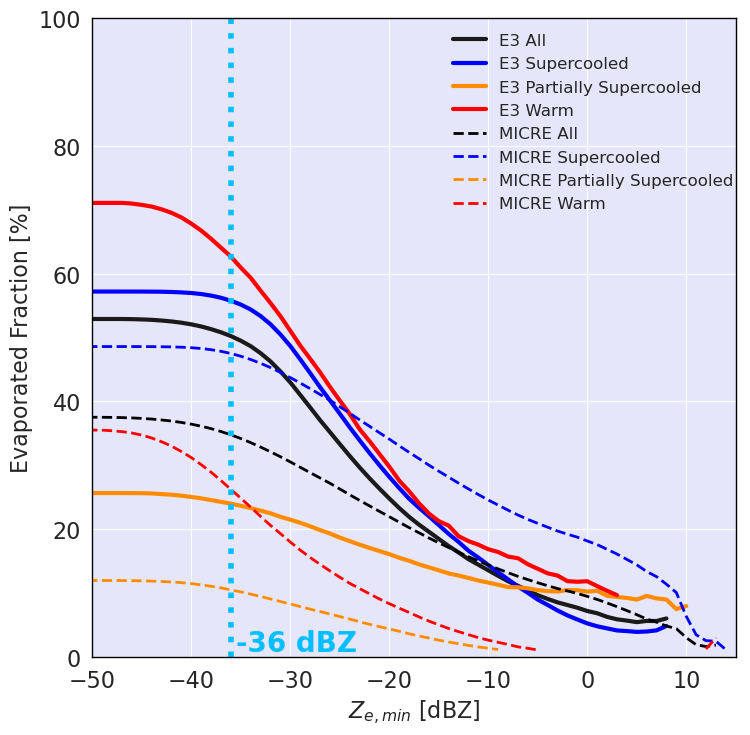

done


In [243]:
sns.set_theme()
sns.set_style('ticks')
sns.set(rc={'axes.facecolor':'lavender','axes.edgecolor': 'black'})
sns.set_context('paper')
fig = plt.figure(figsize=(8.3,8.3))
ax1 = fig.add_subplot(111)
Fontsize=16
ax1.tick_params(labelsize=Fontsize)
ax1.set_ylabel('Evaporated Fraction [%]',fontsize=Fontsize)
ax1.set_xlabel('$Z_{e,min}$ [dBZ]',fontsize=Fontsize)

ax1.plot(Ze_min,evap_frac*100.,lw=3,c='k',label='E3 All')
ax1.plot(Ze_min,evap_frac_supercooled*100.,lw=3,c='blue',label='E3 Supercooled')
ax1.plot(Ze_min,evap_frac_partially_supercooled*100.,lw=3,c='darkorange',label='E3 Partially Supercooled')
ax1.plot(Ze_min,evap_frac_warm*100.,lw=3,c='red',label='E3 Warm')


# MICRE
ax1.plot(Ze_min,micre_evap_frac*100.,lw=2,c='black',ls='dashed',label='MICRE All')
ax1.plot(Ze_min,micre_evap_frac_supercooled*100.,lw=2,c='blue',ls='dashed',label='MICRE Supercooled')
ax1.plot(Ze_min,micre_evap_frac_partially_supercooled*100.,lw=2,c='darkorange',ls='dashed',label='MICRE Partially Supercooled')
ax1.plot(Ze_min,micre_evap_frac_warm*100.,lw=2,c='red',ls='dashed',label='MICRE Warm')

ax1.set_ylim(0,100)
ax1.set_xlim(-50,15)

ax1.legend(loc='upper right',bbox_to_anchor=(1.02,1),framealpha=False,fontsize=Fontsize*0.75,ncol=1)
ax1.axvline(-36.,lw=4,c='deepskyblue',ls='dotted')
ax1.text(-35.5,0,'-36 dBZ',fontweight='bold',fontsize=Fontsize*1.25,ha='left',va='bottom',c='deepskyblue')

fig_path = '/home/mwstanfo/figures/micre_paper/'
outfile = 'fig_g2.png'
#outfile = 'fig_g2.eps'
plt.show()
#plt.savefig(fig_path+outfile,dpi=200,bbox_inches='tight')
plt.close()
print('done')

In [158]:
dumid = np.where(np.isnan(dum_precip_to_sfc_binary))
np.size(dumid)/np.size(dum_precip_to_sfc_binary)

0.35428447013015013

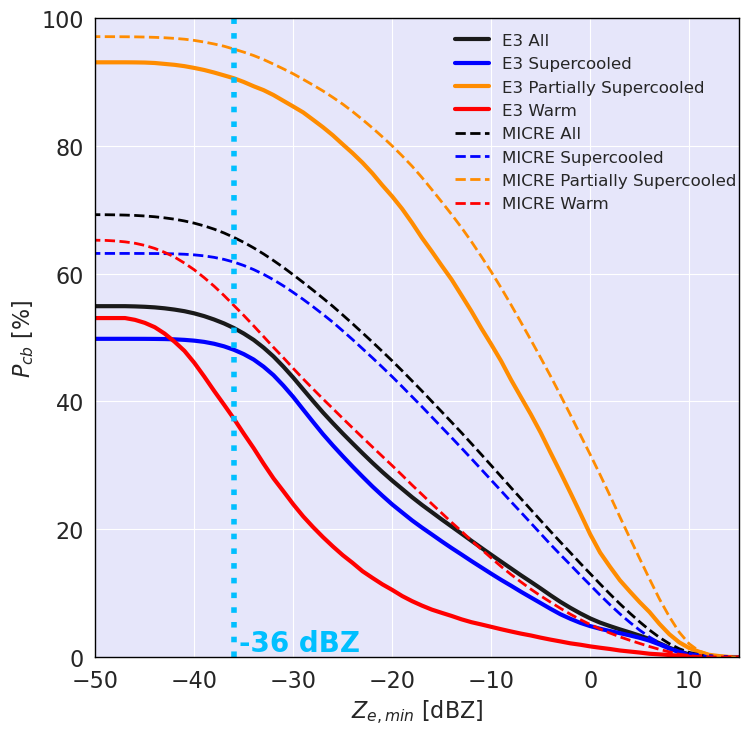

done


In [217]:
sns.set_theme()
sns.set_style('ticks')
sns.set(rc={'axes.facecolor':'lavender','axes.edgecolor': 'black'})
sns.set_context('paper')
fig = plt.figure(figsize=(8.3,8.3))
ax1 = fig.add_subplot(111)
Fontsize=16
ax1.tick_params(labelsize=Fontsize)
ax1.set_ylabel('$P_{cb}$ [%]',fontsize=Fontsize)
ax1.set_xlabel('$Z_{e,min}$ [dBZ]',fontsize=Fontsize)

ax1.plot(Ze_min,pcb*100.,lw=3,c='k',label='E3 All')
ax1.plot(Ze_min,pcb_supercooled*100.,lw=3,c='blue',label='E3 Supercooled')
ax1.plot(Ze_min,pcb_partially_supercooled*100.,lw=3,c='darkorange',label='E3 Partially Supercooled')
ax1.plot(Ze_min,pcb_warm*100.,lw=3,c='red',label='E3 Warm')

if False:
    thresh_arr = np.arange(-12,-5)
    thresh_arr = 10.**thresh_arr
    frac_of_dataset = []
    precip_fracx = []
    for ii in range(len(thresh_arr)):
        dum_precip_binary = precip_binary.copy()
        dumid = np.where( (rcb < thresh_arr[ii]) & (dum_precip_binary == 1.) )
        frac_of_dataset.append(np.size(dumid)/np.size(dum_precip_binary[dum_precip_binary == 1.]))
        dum_precip_binary[dumid] = 0.

        precip_id = np.where(dum_precip_binary == 1.)
        tmp_precip_frac = np.size(precip_id)/np.size(dum_precip_binary)
        precip_fracx.append(tmp_precip_frac)
    precip_fracx = np.array(precip_fracx)
    frac_of_dataset = np.array(frac_of_dataset)

    ax1a = ax1.twiny()
    ax1a.plot(thresh_arr,precip_fracx*100,lw=2,c='blue',marker='o',markersize=5)
    ax1a.set_xscale('log')
    ax1a.tick_params(labelsize=Fontsize,color='blue')
    ax1a.spines['top'].set_color('blue')
    ax1a.tick_params(axis='x', colors='blue',which='both')
    ax1a.set_xlabel('$R_{cb}$ Threshold [mm hr$^{-1}$]',fontsize=Fontsize,c='blue')
    ax1a.grid(False)


# MICRE
ax1.plot(Ze_min,micre_pcb*100.,lw=2,c='black',ls='dashed',label='MICRE All')
ax1.plot(Ze_min,micre_pcb_supercooled*100.,lw=2,c='blue',ls='dashed',label='MICRE Supercooled')
ax1.plot(Ze_min,micre_pcb_partially_supercooled*100.,lw=2,c='darkorange',ls='dashed',label='MICRE Partially Supercooled')
ax1.plot(Ze_min,micre_pcb_warm*100.,lw=2,c='red',ls='dashed',label='MICRE Warm')
#ax1.axvline(-36.,lw=3,c='dimgrey',ls='dotted')
#ax1.text(-35,1,'-36 dBZ',ha='left',fontsize=Fontsize*1.5,fontweight='bold',c='dimgrey')

ax1.set_ylim(0,100)
ax1.set_xlim(-50,15)

ax1.legend(loc='upper right',bbox_to_anchor=(1.02,1),framealpha=False,fontsize=Fontsize*0.75,ncol=1)
ax1.axvline(-36.,lw=4,c='deepskyblue',ls='dotted')
ax1.text(-35.5,0,'-36 dBZ',fontweight='bold',fontsize=Fontsize*1.25,ha='left',va='bottom',c='deepskyblue')

fig_path = '/home/mwstanfo/figures/micre_paper/'
#outfile = 'fig_11.png'
outfile = 'fig_11.eps'
plt.show()
plt.savefig(fig_path+outfile,dpi=200,bbox_inches='tight')
plt.close()
print('done')

In [ ]:
------Pcb-------
All: 69.22893123333854
Supercooled: 63.16584482502209
Partially Supercooled: 97.0838764108749
Warm: 65.23172885599946
------Evap Frac-------
All: 37.53892825107588
Supercooled: 48.60423289951539
Partially Supercooled: 11.989081084092366
Warm: 35.5308028446577
------Psfc-------
All: 54.16082034789267
Supercooled: 45.13704002869399
Partially Supercooled: 90.03801993477661
Warm: 52.852362747509076

In [115]:
#=============================================
# Calculate percentages
#=============================================

# Cloud Occurrence Frequency
tot_size = len(out_dict['tot_time'])
cloud_size = np.size(out_dict['cbh'])
cloud_frac = cloud_size/tot_size*100.
micre_cloud_frac = 75.9

cloud_frac_rel_diff = ((cloud_frac - micre_cloud_frac)/micre_cloud_frac)*100.
print('E3 Cloud Occurrence Frequency:',cloud_frac)
print('MICRE Cloud Occurrence Frequency:',micre_cloud_frac)
print('Cloud Occurrence Frequency Relative Difference:',cloud_frac_rel_diff)
print('--------------------------------------------------------------------------')

# Cloud > 250 m
dumid = np.where( out_dict['cbh'] > 250.)
dum_frac = np.size(dumid)/np.size(out_dict['cbh'])*100.
micre_cbh_gt_250m_frac = 74.4
dum_rel_diff = ((dum_frac - micre_cbh_gt_250m_frac)/micre_cbh_gt_250m_frac)*100.
print('E3 Fraction of clouds > 250. m:',dum_frac)
print('MICRE Fraction of clouds > 250. m:',micre_cbh_gt_250m_frac)
print('Fraction of clouds > 250. m Relative Difference:',dum_rel_diff)
print('--------------------------------------------------------------------------')

# Cloud > 250 m supercooling partitioning
dumid = np.where( out_dict['cbh'] > 250.)
dum_cbh = out_dict['cbh'][dumid]
dum_cbt = out_dict['cbt'][dumid]-273.15
warm_id = np.where(dum_cbt >= 0.)
supercooled_id = np.where(dum_cbt < 0.)
supercooled_cbh_gt_250_frac = np.size(supercooled_id)/np.size(dum_cbh)*100.
warm_cbh_gt_250_frac = np.size(warm_id)/np.size(dum_cbh)*100.
print('E3 Fraction of clouds > 250 m that are warm:',warm_cbh_gt_250_frac)
print('E3 Fraction of clouds > 250 m that are supercooled:',supercooled_cbh_gt_250_frac)
micre_supercooled_cbh_gt_250_frac = 60.7
micre_warm_cbh_gt_250_frac = 39.3
print('MICRE Fraction of clouds > 250 m that are warm:',micre_warm_cbh_gt_250_frac)
print('MICRE Fraction of clouds > 250 m that are supercooled:',micre_supercooled_cbh_gt_250_frac)
dum_rel_diff = ((supercooled_cbh_gt_250_frac-micre_supercooled_cbh_gt_250_frac)/micre_supercooled_cbh_gt_250_frac)*100.
print('Fraction of clouds > 250 m that are supercooled relative difference:',dum_rel_diff)
dum_rel_diff = ((warm_cbh_gt_250_frac-micre_warm_cbh_gt_250_frac)/micre_warm_cbh_gt_250_frac)*100.
print('Fraction of clouds > 250 m that are warm relative difference:',dum_rel_diff)
print('--------------------------------------------------------------------------')

# Cloud < 250 m
dumid = np.where( out_dict['cbh'] < 250.)
dum_frac = np.size(dumid)/np.size(out_dict['cbh'])*100.
micre_cbh_lt_250m_frac = 25.6
dum_rel_diff = ((dum_frac - micre_cbh_lt_250m_frac)/micre_cbh_lt_250m_frac)*100.
print('E3 Fraction of clouds < 250. m:',dum_frac)
print('MICRE Fraction of clouds < 250. m:',micre_cbh_lt_250m_frac)
print('Fraction of clouds < 250. m Relative Difference:',dum_rel_diff)
print('--------------------------------------------------------------------------')
                   
# Precipitation Occurrence Frequency
dumid = np.where( out_dict['cbh'] > 250.)
dum_cbh = out_dict['cbh'][dumid]
dum_cbt = out_dict['cbt'][dumid]-273.15
dum_ctt = out_dict['ctt'][dumid]-273.15
dum_precip_binary = out_dict['precip_binary'][dumid]
tot_size = np.size(dum_precip_binary)
precip_id = np.where(dum_precip_binary == 1.)
precip_frac = np.size(precip_id)/tot_size*100.
print('E3 Precipitation Occurrence Frequency:',precip_frac)
micre_precip_frac = 66.1
micre_supercooled_precip_frac = 59.
micre_partially_supercooled_precip_frac = 95.9
micre_warm_precip_frac = 59.4
print('MICRE Precipitation Occurrence Frequency:',micre_precip_frac)
dum_rel_diff = ((precip_frac - micre_precip_frac)/micre_precip_frac)*100.
print('Pcb Relative Difference:',dum_rel_diff)

supercooled_id = np.where( (dum_cbt < 0.) & (dum_ctt < 0.) )
supercooled_precip_id = np.where( (dum_cbt < 0.) & (dum_ctt < 0.) & (dum_precip_binary == 1.))
supercooled_precip_frac = np.size(supercooled_precip_id)/np.size(supercooled_id)*100.
print('E3 Supercooled Precipitation Occurrence Frequency:',supercooled_precip_frac)
print('MICRE Supercooled Precipitation Occurrence Frequency:',micre_supercooled_precip_frac)
dum_rel_diff = ((supercooled_precip_frac - micre_supercooled_precip_frac)/micre_supercooled_precip_frac)*100.
print('Supercooled Pcb Relative Difference:',dum_rel_diff)

partially_supercooled_id = np.where( (dum_cbt >= 0.) & (dum_ctt < 0.) )
partially_supercooled_precip_id = np.where( (dum_cbt >= 0.) & (dum_ctt < 0.) & (dum_precip_binary == 1.))
partially_supercooled_precip_frac = np.size(partially_supercooled_precip_id)/np.size(partially_supercooled_id)*100.
print('E3 Partially Supercooled Precipitation Occurrence Frequency:',partially_supercooled_precip_frac)
print('MICRE Partially Supercooled Precipitation Occurrence Frequency:',micre_partially_supercooled_precip_frac)
dum_rel_diff = ((partially_supercooled_precip_frac - micre_partially_supercooled_precip_frac)/micre_partially_supercooled_precip_frac)*100.
print('Partially Supercooled Pcb Relative Difference:',dum_rel_diff)

warm_id = np.where( (dum_cbt >= 0.) & (dum_ctt >= 0.) )
warm_precip_id = np.where( (dum_cbt >= 0.) & (dum_ctt >= 0.) & (dum_precip_binary == 1.))
warm_precip_frac = np.size(warm_precip_id)/np.size(warm_id)*100.
print('E3 Warm Precipitation Occurrence Frequency:',warm_precip_frac)
print('MICRE Warm Precipitation Occurrence Frequency:',micre_warm_precip_frac)
dum_rel_diff = ((warm_precip_frac - micre_warm_precip_frac)/micre_warm_precip_frac)*100.
print('Warm Pcb Relative Difference:',dum_rel_diff)
print('--------------------------------------------------------------------------')
                   
# CEIL only
dumid = np.where(out_dict['cbh'] > 250.)
dum_cbt = out_dict['cbt'][dumid]-273.15
dum_cbh = out_dict['cbh'][dumid]
dum_ceil_only_id = out_dict['ceil_only_id'][dumid]
micre_ceil_only_frac = 27.3
micre_supercooled_ceil_only_frac = 75.3
micre_warm_ceil_only_frac = 24.7
print('MICRE CEIL-only frac:',micre_ceil_only_frac)
print('MICRE Supercooled CEIL-only frac:',micre_supercooled_ceil_only_frac)
print('MICRE Warm CEIL-only frac:',micre_warm_ceil_only_frac)
ceil_only_frac = np.size(np.where(dum_ceil_only_id == 1.))/np.size(dum_ceil_only_id)*100.
print('E3 CEIL-only frac:',ceil_only_frac)
dum_rel_diff = ((ceil_only_frac - micre_ceil_only_frac)/micre_ceil_only_frac)*100.
print('CEIL-only frac Relative Difference:',dum_rel_diff)
supercooled_ceil_only_frac = np.size(np.where( (dum_ceil_only_id == 1.) & (dum_cbt < 0.)))/np.size(np.where(dum_ceil_only_id == 1.))*100.
print('E3 Supercooled CEIL-only frac:',supercooled_ceil_only_frac)
dum_rel_diff = ((supercooled_ceil_only_frac - micre_supercooled_ceil_only_frac)/micre_supercooled_ceil_only_frac)*100.
print('Supercooled CEIL-only frac Relative Difference:',dum_rel_diff)
warm_ceil_only_frac = np.size(np.where( (dum_ceil_only_id == 1.) & (dum_cbt >= 0.)))/np.size(np.where(dum_ceil_only_id == 1.))*100.
print('E3 Warm CEIL-only frac:',warm_ceil_only_frac)
dum_rel_diff = ((warm_ceil_only_frac - micre_warm_ceil_only_frac)/micre_warm_ceil_only_frac)*100.
print('Warm CEIL-only frac Relative Difference:',dum_rel_diff)
print('--------------------------------------------------------------------------')

# Precipitation Supercooling Partitioning
micre_rcb_supercooled_frac = 54.11
micre_rcb_partially_supercooled_frac = 23.67
micre_rcb_warm_frac = 22.22
dumid = np.where( (out_dict['cbh'] > 250.) & (out_dict['precip_binary'] == 1.) )
dum_cbt = out_dict['cbt'][dumid]-273.15
dum_ctt = out_dict['ctt'][dumid]-273.15
print('MICRE Rcb Warm Frac:',micre_rcb_warm_frac)
print('MICRE Rcb Supercooled Frac:',micre_rcb_supercooled_frac)
print('MICRE Rcb Partially Supercooled Frac:',micre_rcb_partially_supercooled_frac)
rcb_warm_frac = np.size(np.where((dum_cbt >= 0.) & (dum_ctt >= 0.) ))/np.size(dum_ctt)*100.
print('Rcb Warm frac:',rcb_warm_frac)
rcb_supercooled_frac = np.size(np.where((dum_cbt < 0.) & (dum_ctt < 0.) ))/np.size(dum_ctt)*100.
print('Rcb Supercooled frac:',rcb_supercooled_frac)
rcb_partially_supercooled_frac = np.size(np.where((dum_cbt >= 0.) & (dum_ctt < 0.) ))/np.size(dum_ctt)*100.
print('Rcb Partially Supercooled frac:',rcb_partially_supercooled_frac)
dum_rel_diff = ((rcb_warm_frac - micre_rcb_warm_frac)/micre_rcb_warm_frac)*100.
print('Rcb Warm Frac Relative Difference:',dum_rel_diff)
dum_rel_diff = ((rcb_supercooled_frac - micre_rcb_supercooled_frac)/micre_rcb_supercooled_frac)*100.
print('Rcb Supercooled Frac Relative Difference:',dum_rel_diff)
dum_rel_diff = ((rcb_partially_supercooled_frac - micre_rcb_partially_supercooled_frac)/micre_rcb_partially_supercooled_frac)*100.
print('Rcb Partially Supercooled Frac Relative Difference:',dum_rel_diff)
print('--------------------------------------------------------------------------')

# Surface Pcb
dumid = np.where( (out_dict['cbh'] > 250.) & (out_dict['precip_binary'] == 1.) )
dum_cbt = out_dict['cbt'][dumid]-273.15
dum_ctt = out_dict['ctt'][dumid]-273.15
dum_sfc_precip_id = out_dict['sfc_precip_binary'][dumid]

micre_sfc_precip_frac = 46.7
micre_supercooled_sfc_precip_frac = 34.1
micre_partially_supercooled_sfc_precip_frac = 85.8
micre_warm_sfc_precip_frac = 44.0

print('MICRE SFC Pcb:',micre_sfc_precip_frac)
print('MICRE Supercooled SFC Pcb:',micre_supercooled_sfc_precip_frac)
print('MICRE Partially Supercooled SFC Pcb:',micre_partially_supercooled_sfc_precip_frac)
print('MICRE Warm SFC Pcb:',micre_warm_sfc_precip_frac)

sfc_precip_frac = np.size(np.where(dum_sfc_precip_id == 1.))/np.size(dumid)*100.
supercooled_sfc_precip_frac = np.size(np.where( (dum_sfc_precip_id == 1.) & (dum_cbt < 0.) & (dum_ctt < 0.) ))/np.size(np.where( (dum_cbt < 0.) & (dum_ctt < 0.) ))*100.
partially_supercooled_sfc_precip_frac = np.size(np.where( (dum_sfc_precip_id == 1.) & (dum_cbt >= 0.) & (dum_ctt < 0.) ))/np.size(np.where( (dum_cbt >= 0.) & (dum_ctt < 0.) ))*100.
warm_sfc_precip_frac = np.size(np.where( (dum_sfc_precip_id == 1.) & (dum_cbt >= 0.) & (dum_ctt >= 0.) ))/np.size(np.where( (dum_cbt >= 0.) & (dum_ctt >= 0.) ))*100.

print('SFC Pcb:',sfc_precip_frac)
print('SFC Supercooled Pcb:',supercooled_sfc_precip_frac)
print('SFC Partially Supercooled Pcb:',partially_supercooled_sfc_precip_frac)
print('SFC Warm Pcb:',warm_sfc_precip_frac)

dum_rel_diff = ((sfc_precip_frac - micre_sfc_precip_frac)/micre_sfc_precip_frac)*100.
print('SFC Pcb Relative Difference:',dum_rel_diff)
dum_rel_diff = ((supercooled_sfc_precip_frac - micre_supercooled_sfc_precip_frac)/micre_supercooled_sfc_precip_frac)*100.
print('SFC Supercooled Pcb Relative Difference:',dum_rel_diff)
dum_rel_diff = ((partially_supercooled_sfc_precip_frac - micre_partially_supercooled_sfc_precip_frac)/micre_partially_supercooled_sfc_precip_frac)*100.
print('SFC Partially Supercooled Pcb Relative Difference:',dum_rel_diff)
dum_rel_diff = ((warm_sfc_precip_frac - micre_warm_sfc_precip_frac)/micre_warm_sfc_precip_frac)*100.
print('SFC Warm Pcb Relative Difference:',dum_rel_diff)
print('--------------------------------------------------------------------------')

# Fog
dumid = np.where( (out_dict['cbh'] < 250.))
tot_size = np.size(np.where(out_dict['cbh'] > 0.))
dum_fog_id = out_dict['fog_id'][dumid]
micre_fog_frac = 14.2
fog_frac = np.size(dum_fog_id[dum_fog_id == 1.])/tot_size*100.
print('Percentage of clouds IDd as Fog:',fog_frac)
sfc_fog_frac = np.size(dum_fog_id[dum_fog_id == 1.])/np.size(dum_fog_id)*100.
print('Percentage of SFC clouds IDd as Fog:',sfc_fog_frac)
print('MICRE Fog fraction:',micre_fog_frac)
micre_sfc_fog_frac = 56.7
print('MICRE Fog fraction of SFC clouds:',micre_sfc_fog_frac)
dum_rel_diff = ((fog_frac - micre_fog_frac)/micre_fog_frac)*100.
print('Fog Frac Relative Difference:',dum_rel_diff)
dum_rel_diff = ((sfc_fog_frac - micre_sfc_fog_frac)/micre_sfc_fog_frac)*100.
print('SFC clouds as Fog Frac Relative Difference:',dum_rel_diff)
print('--------------------------------------------------------------------------')

# Evaporated Fraction
dumid = np.where( (out_dict['cbh'] > 250.) & (out_dict['precip_binary'] == 1.))
dum_sfc_precip_binary = out_dict['sfc_precip_binary'][dumid]
dum_ctt = out_dict['ctt'][dumid]-273.15
dum_cbt = out_dict['cbt'][dumid]-273.15
dum_cbh = out_dict['cbh'][dumid]
dum_precip_binary = out_dict['precip_binary'][dumid]

evap_frac = np.size(np.where(dum_sfc_precip_binary == 0.))/np.size(dum_sfc_precip_binary)*100.
print('Evaporated Fraction:',evap_frac)
supercooled_evap_frac = np.size(np.where( (dum_sfc_precip_binary == 0.) & (dum_ctt < 0.) & (dum_cbt < 0.)))/np.size(np.where( (dum_cbt < 0.) & (dum_ctt < 0.)))*100.
print('Supercooled Evaporated Fraction:',supercooled_evap_frac)
partially_supercooled_evap_frac = np.size(np.where( (dum_sfc_precip_binary == 0.) & (dum_ctt < 0.) & (dum_cbt >= 0.)))/np.size(np.where( (dum_cbt >= 0.) & (dum_ctt < 0.)))*100.
print('Partially Supercooled Evaporated Fraction:',partially_supercooled_evap_frac)
warm_evap_frac = np.size(np.where( (dum_sfc_precip_binary == 0.) & (dum_ctt >= 0.) & (dum_cbt >= 0.)))/np.size(np.where( (dum_cbt >= 0.) & (dum_ctt >= 0.)))*100.
print('Warm Evaporated Fraction:',warm_evap_frac)
micre_evap_frac = 100-46.7
print('MICRE Evaporated Fraction:',micre_evap_frac)
micre_supercooled_evap_frac = 100-34.1
print('MICRE Supercooled Evaporated Fraction:',micre_supercooled_evap_frac)
micre_partially_supercooled_evap_frac = 100-85.8
print('MICRE Partially Supercooled Evaporated Fraction:',micre_partially_supercooled_evap_frac)
micre_warm_evap_frac = 100-44.0
print('MICRE Warm Evaporated Fraction:',micre_warm_evap_frac)

dum_rel_diff = ((evap_frac - micre_evap_frac)/micre_evap_frac)*100.
print('Evaporated Fraction Relative Difference:',dum_rel_diff)
dum_rel_diff = ((supercooled_evap_frac - micre_supercooled_evap_frac)/micre_supercooled_evap_frac)*100.
print('Supercooled Evaporated Fraction Relative Difference:',dum_rel_diff)
dum_rel_diff = ((partially_supercooled_evap_frac - micre_partially_supercooled_evap_frac)/micre_partially_supercooled_evap_frac)*100.
print('Partially Supercooled Evaporated Fraction Relative Difference:',dum_rel_diff)
dum_rel_diff = ((warm_evap_frac - micre_warm_evap_frac)/micre_warm_evap_frac)*100.
print('Warm Evaporated Fraction Relative Difference:',dum_rel_diff)


E3 Cloud Occurrence Frequency: 57.412650848010436
MICRE Cloud Occurrence Frequency: 75.9
Cloud Occurrence Frequency Relative Difference: -24.357508764149628
--------------------------------------------------------------------------
E3 Fraction of clouds > 250. m: 73.84441678930989
MICRE Fraction of clouds > 250. m: 74.4
Fraction of clouds > 250. m Relative Difference: -0.7467516272716618
--------------------------------------------------------------------------
E3 Fraction of clouds > 250 m that are warm: 21.987662156574252
E3 Fraction of clouds > 250 m that are supercooled: 78.01233784342575
MICRE Fraction of clouds > 250 m that are warm: 39.3
MICRE Fraction of clouds > 250 m that are supercooled: 60.7
Fraction of clouds > 250 m that are supercooled relative difference: 28.521149659679985
Fraction of clouds > 250 m that are warm relative difference: -44.05175023772455
--------------------------------------------------------------------------
E3 Fraction of clouds < 250. m: 26.15558321

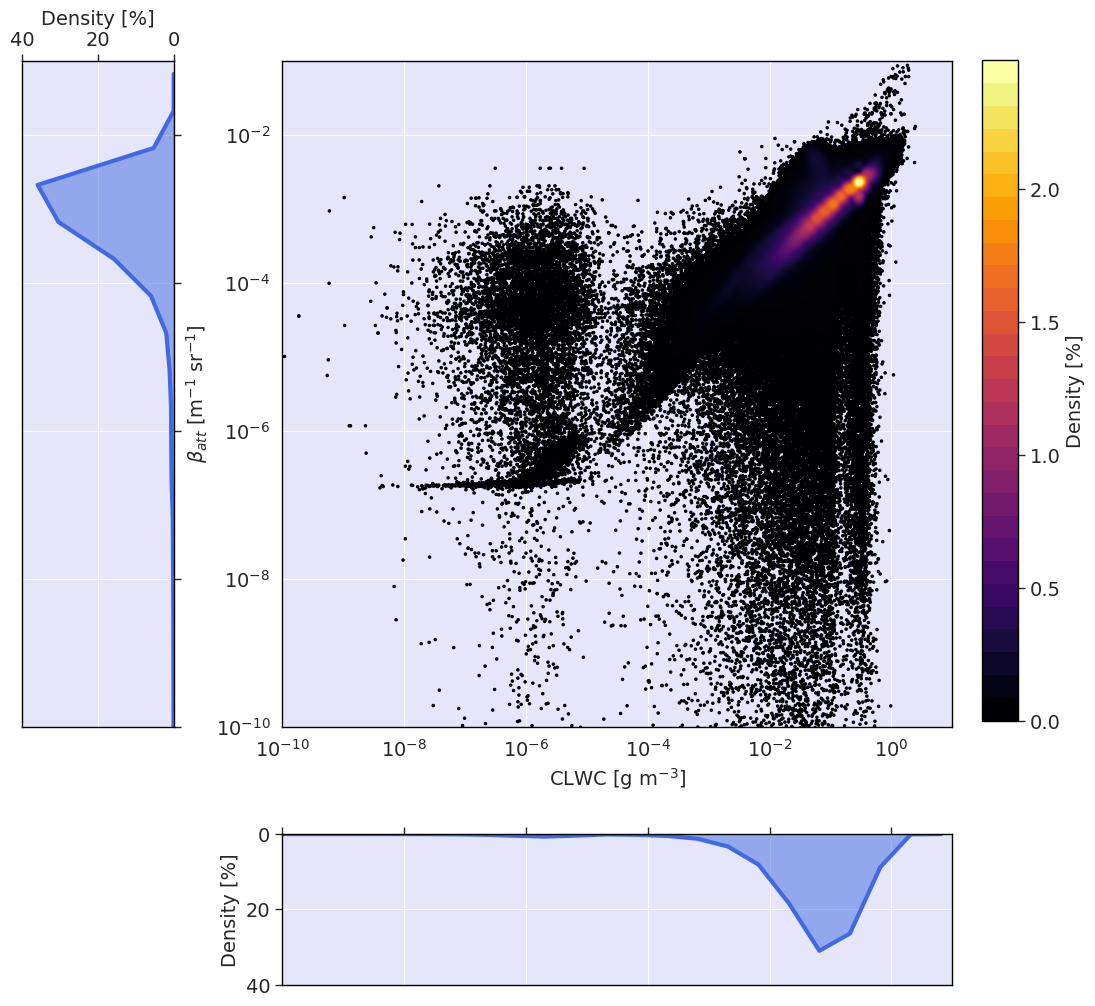

In [118]:
from scipy.interpolate import interpn
from matplotlib import cm
from matplotlib.colors import Normalize 

sns.set_theme()
sns.set_style('ticks')
sns.set(rc={'axes.facecolor':'lavender','axes.edgecolor': 'black'})
sns.set_context('paper')

fig = plt.figure(figsize=(12,12))
gs=GridSpec(8,8) # 6 rows, 6 columns

ax1 = fig.add_subplot(gs[0:6,2:8])
ax2 = fig.add_subplot(gs[0:6,0:2])
ax3 = fig.add_subplot(gs[6:8,2:8])

Fontsize=14
ax1.tick_params(labelsize=Fontsize)
ax1.set_xlabel('CLWC [g m$^{-3}$]',fontsize=Fontsize)
ax1.set_ylabel('$\\beta_{att}$ [m$^{-1}$ sr$^{-1}$]',fontsize=Fontsize)
x = out_dict['cb_clwc']*1.e3
y = out_dict['cb_beta_att']
ax1.set_xscale('log')
ax1.set_yscale('log')

#ax1.scatter(x,y,s=2,marker='o',c='k')
levels = np.array([0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,\
                   0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,6,7,8,9,10])

x = out_dict['cb_clwc']*1.e3
y = out_dict['cb_beta_att']
bins1 = 10.**np.arange(-12,1.1,0.1)
bins2 = 10.**np.arange(-12,-0.9,0.1)

data , x_e, y_e = np.histogram2d(x, y,bins=[bins1,bins2], density = False)
data = data/np.size(x)*100.
z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)
z[z < 0.] = 0.
#To be sure to plot all data
z[np.where(np.isnan(z))] = 0.0
# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
dum_cmap = 'inferno'

x, y, z = x[idx], y[idx], z[idx]
dum=ax1.scatter( x, y, c=z,s=3,cmap=dum_cmap)
cbar_ax = fig.add_axes([0.925,0.33,0.03,0.55])

nipy = cm.get_cmap('inferno',len(levels))
#bounds = levels
#norm = matplotlib.colors.BoundaryNorm(bounds,nipy.N)
norm = Normalize(vmin = np.min(z), vmax = np.max(z))
cbar = matplotlib.colorbar.ColorbarBase(cbar_ax,cmap=nipy,norm=norm,\
                                  spacing='uniform',\
                                  orientation='vertical')
cbar.ax.set_ylabel('Density [%]',fontsize=Fontsize)
cbar.ax.tick_params(labelsize=Fontsize)


ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax3.yaxis.tick_left()
ax3.xaxis.tick_top()



ax2.set_xlabel('Density [%]',fontsize=Fontsize)
ax3.set_ylabel('Density [%]',fontsize=Fontsize)
ax2.xaxis.set_label_position('top') 


ax2.set_xlabel('Density [%]',fontsize=Fontsize)
ax3.set_ylabel('Density [%]',fontsize=Fontsize)
ax2.xaxis.set_label_position('top') 

bins1 = 10.**np.arange(-12,1.5,0.5)
bins2 = 10.**np.arange(-12,-0.5,0.5)

cb_clwc_hist,cb_clwc_bin_edges = np.histogram(out_dict['cb_clwc']*1.e3,bins=bins1,density=False)
cb_beta_att_hist,cb_beta_att_bin_edges = np.histogram(out_dict['cb_beta_att'],bins=bins2,density=False)

cb_clwc_hist = cb_clwc_hist/np.size(out_dict['cb_clwc'])*100.
cb_beta_att_hist = cb_beta_att_hist/np.size(out_dict['cb_beta_att'])*100.

dum_cb_clwc_midbins = np.array([(bins1[dd]+bins1[dd+1])/2. for dd in range(len(bins1)-1)])
dum_cb_beta_att_midbins = np.array([(bins2[dd]+bins2[dd+1])/2. for dd in range(len(bins2)-1)])

#ax2.bar(dum_cb_clwc_midbins,cb_clwc_hist,color='royalblue')
#ax3.barh(dum_cb_beta_att_midbins,cb_beta_att_hist,color='royalblue')
#ax3.plot(dum_cb_clwc_midbins,cb_clwc_hist,color='royalblue')
#ax2.barh(cb_beta_att_hist,dum_cb_beta_att_midbins,color='royalblue')


# Beta Att
ax2.plot(cb_beta_att_hist,dum_cb_beta_att_midbins,color='royalblue',lw=3)
#Fill under the curve
ax2.fill_between(
        x= cb_beta_att_hist, 
        y1= dum_cb_beta_att_midbins, 
        color= "royalblue",
        alpha= 0.5)
ax2.set_ylim(1.e-10,1.e-1)
ax2.set_yscale('log')
ax2.yaxis.set_ticklabels([])
ax2.set_xlim(40,0)

# CLWC
ax3.plot(dum_cb_clwc_midbins,cb_clwc_hist,color='royalblue',lw=3)
#Fill under the curve
ax3.fill_between(
        x= dum_cb_clwc_midbins, 
        y1= cb_clwc_hist, 
        color= "royalblue",
        alpha= 0.5)

ax3.set_xlim(1.e-10,1.e1)
ax3.set_xscale('log')
ax3.xaxis.set_ticklabels([])
ax3.set_ylim(40,0)

ax1.set_xlim(1.e-10,1.e1)
ax1.set_ylim(1.e-10,1.e-1)

ax2.tick_params(labelsize=Fontsize)
ax3.tick_params(labelsize=Fontsize)

plt.subplots_adjust(wspace=5,hspace=5)

plt.show()

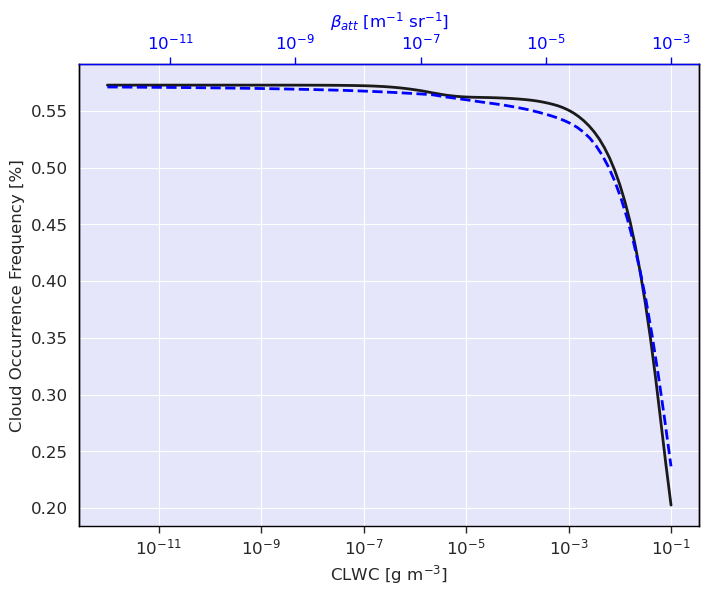

In [15]:
Ze_min = np.arange(-50,16,1)
micre_pcb = np.zeros(len(Ze_min))
micre_pcb_supercooled = np.zeros(len(Ze_min))
micre_pcb_partially_supercooled = np.zeros(len(Ze_min))
micre_pcb_warm = np.zeros(len(Ze_min))

for ii in range(len(Ze_min)):
    dum_precip_binary = micre_precip_binary.copy()
    
    # All Clouds
    dumid = np.where( (dum_precip_binary == 1) & (micre_ref_mean_bel > Ze_min[ii]) )
    micre_pcb[ii] = np.size(dumid)/np.size(dum_precip_binary)
    
    # Supercooled
    precip_id = np.where( (dum_precip_binary == 1) & (micre_ref_mean_bel > Ze_min[ii]) & (micre_cbt < 0.) & (micre_ctt < 0.) )
    cloud_id = np.where( (micre_cbt < 0. ) & (micre_ctt < 0.) )
    micre_pcb_supercooled[ii] = np.size(precip_id)/np.size(cloud_id)    
                        
    # Partially Supercooled
    precip_id = np.where( (dum_precip_binary == 1) & (micre_ref_mean_bel > Ze_min[ii]) & (micre_cbt >= 0.) & (micre_ctt < 0.) )
    cloud_id = np.where( (micre_cbt >= 0. ) & (micre_ctt < 0.) )
    micre_pcb_partially_supercooled[ii] = np.size(precip_id)/np.size(cloud_id) 
                                          
    # Warm
    precip_id = np.where( (dum_precip_binary == 1) & (micre_ref_mean_bel > Ze_min[ii]) & (micre_cbt >= 0.) & (micre_ctt >= 0.) )
    cloud_id = np.where( (micre_cbt >= 0. ) & (micre_ctt >= 0.) )
    micre_pcb_warm[ii] = np.size(precip_id)/np.size(cloud_id) 

In [16]:
Ze_min = np.arange(-50,16,1)
pcb = np.zeros(len(Ze_min))
pcb_supercooled = np.zeros(len(Ze_min))
pcb_partially_supercooled = np.zeros(len(Ze_min))
pcb_warm = np.zeros(len(Ze_min))

for ii in range(len(Ze_min)):
    dum_precip_binary = precip_binary.copy()
    
    # All Clouds
    precip_id = np.where( (dum_precip_binary == 1) & (cb_Ze > Ze_min[ii]) & (cbh > 250.) )
    cloud_id = np.where(cbh > 250.)
    pcb[ii] = np.size(precip_id)/np.size(cloud_id)
    
    # Supercooled Clouds
    precip_id = np.where( (dum_precip_binary == 1) & (cb_Ze > Ze_min[ii])  & (cbt < 0.) & (ctt < 0.) & (cbh > 250.) )
    cloud_id = np.where( (cbt < 0.) & (ctt < 0.) & (cbh > 250.) )
    pcb_supercooled[ii] = np.size(precip_id)/np.size(cloud_id)  
    
    # Partially Supercooled Clouds
    precip_id = np.where( (dum_precip_binary == 1) & (cb_Ze > Ze_min[ii]) & (cbt >= 0.) & (ctt < 0.) & (cbh > 250.) )
    cloud_id = np.where( (cbt >= 0.) & (ctt < 0.) & (cbh > 250.) )
    pcb_partially_supercooled[ii] = np.size(precip_id)/np.size(cloud_id) 
    
    # Warm Clouds
    precip_id = np.where( (dum_precip_binary == 1) & (cb_Ze > Ze_min[ii]) & (cbt >= 0.) & (ctt >= 0.) & (cbh > 250.) )
    cloud_id = np.where( (cbt >= 0.) & (ctt >= 0.) & (cbh > 250.) )
    pcb_warm[ii] = np.size(precip_id)/np.size(cloud_id)        
    

done


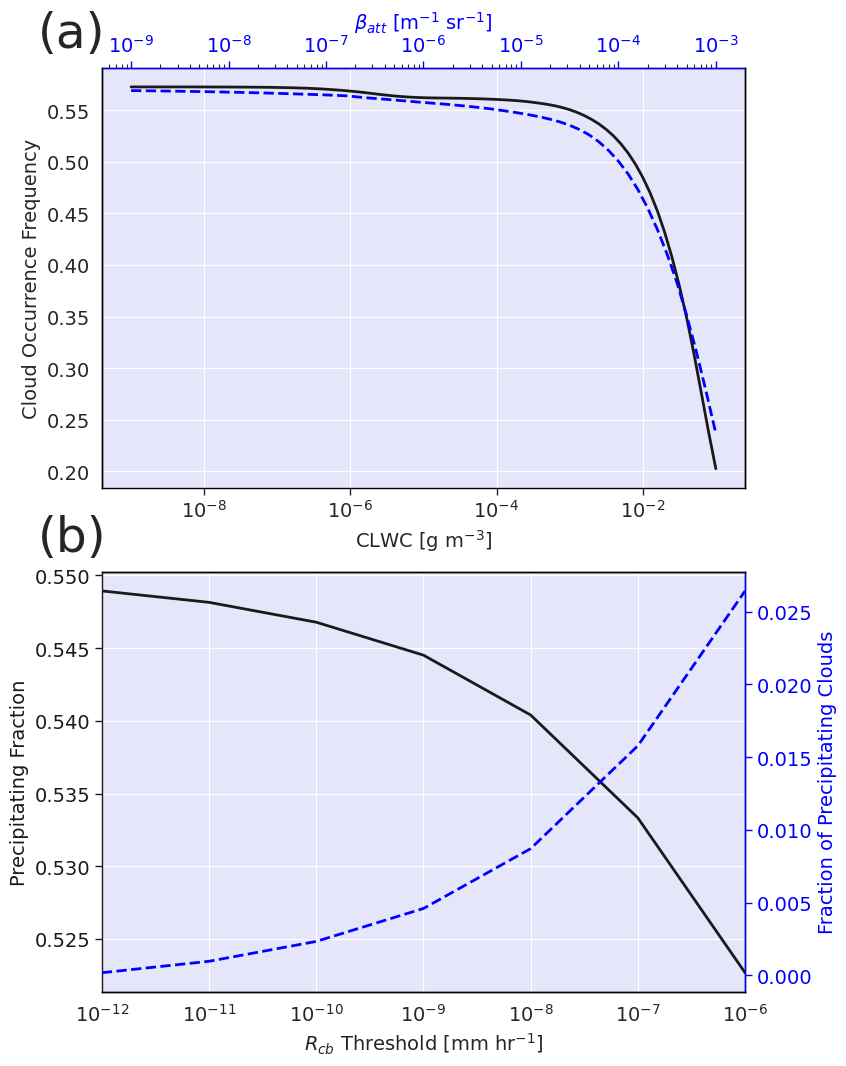

In [250]:
#=========================================
# E3 Sensitivities
#=========================================
sns.set_theme()
sns.set_style('ticks')
sns.set(rc={'axes.facecolor':'lavender','axes.edgecolor': 'black'})
sns.set_context('paper')
fig = plt.figure(figsize=(8.3,12))
ax1 = fig.add_subplot(211)
ax3 = fig.add_subplot(212)
Fontsize=14


#---------------------------------------------
# Cloud Occurrence Frequency
#---------------------------------------------
ax1.tick_params(labelsize=Fontsize)
ax1.set_ylabel('Cloud Occurrence Frequency',fontsize=Fontsize)

# CLWC Threshes
ax1.set_xlabel('CLWC [g m$^{-3}$]',fontsize=Fontsize)
clwc_threshes = np.arange(-9,-0.9,0.1)
cloud_fraction = np.zeros(len(clwc_threshes))
tot_size = np.size(out_dict['tot_time'])
dumi=0
for clwc_thresh in clwc_threshes:
    cloud_id = np.where(out_dict['cbh'] > 0.)
    dumid = np.where((out_dict['cb_clwc'][cloud_id]*1.e3 > 10.**(clwc_thresh)) )
    if np.size(dumid) > 0.:
        cloud_fraction[dumi] = np.size(dumid)/tot_size
            
    dumi+=1
x = clwc_threshes
y = cloud_fraction
ax1.set_xscale('log')
ax1.plot(10.**x,y,lw=2,c='k')

# Beta_att thresh
ax2 = ax1.twiny()
ax2.set_xlabel('$\\beta_{att}$ [m$^{-1}$ sr$^{-1}$]',fontsize=Fontsize,c='blue')
ax2.grid(False)
# deal with axis colors
ax2.spines['top'].set_color('blue')
ax2.xaxis.label.set_color('blue')
ax2.tick_params(axis='x', colors='blue',labelsize=Fontsize)
ax2.spines['bottom'].set_visible(False)

beta_att_threshes = np.arange(-9,-2.9,0.1)
cloud_fraction = np.zeros(len(beta_att_threshes))
tot_size = np.size(out_dict['tot_time'])
dumi=0
for beta_att_thresh in beta_att_threshes:
    cloud_id = np.where(out_dict['cbh'] > 0.)
    dumid = np.where((out_dict['cb_beta_att'][cloud_id] > 10.**(beta_att_thresh)) )
    if np.size(dumid) > 0.:
        cloud_fraction[dumi] = np.size(dumid)/tot_size
            
    dumi+=1
    
x = beta_att_threshes
y = cloud_fraction
ax2.set_xscale('log')
ax2.plot(10.**x,y,lw=2,c='blue',ls='dashed')


#-----------------------------------------
# Precipitation Occurrence Frequency
#-----------------------------------------
thresh_arr = np.arange(-12,-5)
thresh_arr = 10.**thresh_arr
frac_of_dataset = []
precip_fracx = []
for ii in range(len(thresh_arr)):
    dum_precip_binary = out_dict['precip_binary'].copy()
    dum_rcb = out_dict['rcb'].copy()
    dum_cbh = out_dict['cbh'].copy()
    
    dumid = np.where( (dum_cbh > 250.) & (~np.isnan(dum_precip_binary)))
    dum_precip_binary = dum_precip_binary[dumid]
    dum_rcb = dum_rcb[dumid]
    dum_cbh = dum_cbh[dumid]

    dumid = np.where( (dum_rcb < thresh_arr[ii]) & (dum_precip_binary == 1.))
    dum_precip_binary[dumid] = 0.
    
    precip_id = np.where(dum_precip_binary == 1.)
    tmp_precip_frac = np.size(precip_id)/np.size(dum_precip_binary)
    precip_fracx.append(tmp_precip_frac)    

    tmp_frac_of_dataset = np.size(dumid)/np.size(dum_precip_binary)
    frac_of_dataset.append(tmp_frac_of_dataset)
    #frac_of_dataset.append(np.size(dumid)/np.size(dum_precip_binary[dum_precip_binary == 1.]))
    
precip_fracx = np.array(precip_fracx)
frac_of_dataset = np.array(frac_of_dataset)

ax3a = ax3.twinx()
ax3.tick_params(labelsize=Fontsize,color='k')
ax3a.tick_params(labelsize=Fontsize,color='blue')
ax3a.spines['right'].set_color('blue')
ax3.spines['left'].set_color('k')
ax3a.spines['left'].set_visible(False)
ax3a.tick_params(axis='y', which='both',colors='blue')
ax3.tick_params(axis='y', which='both',colors='k')

ax3.set_ylabel('Precipitating Fraction',fontsize=Fontsize,c='k')
ax3a.set_ylabel('Fraction of Precipitating Clouds',fontsize=Fontsize,c='blue')
ax3.set_xlabel('$R_{cb}$ Threshold [mm hr$^{-1}$]',fontsize=Fontsize)
ax3.set_xscale('log')
ax3.set_xlim(np.min(thresh_arr),np.max(thresh_arr))
ax3.plot(thresh_arr,precip_fracx,lw=2,c='k')
ax3a.plot(thresh_arr,frac_of_dataset,lw=2,c='blue',ls='dashed')
ax3a.grid(False)

ax1.text(-0.1,1.05,'(a)',fontsize=Fontsize*2.5,transform=ax1.transAxes)
ax3.text(-0.1,1.05,'(b)',fontsize=Fontsize*2.5,transform=ax3.transAxes)

fig_path = '/home/mwstanfo/figures/micre_paper/'
outfile = 'fig_g1.png'
#outfile = 'fig_g1.eps'
#plt.show()
plt.savefig(fig_path+outfile,dpi=200,bbox_inches='tight')
#plt.close()
print('done')

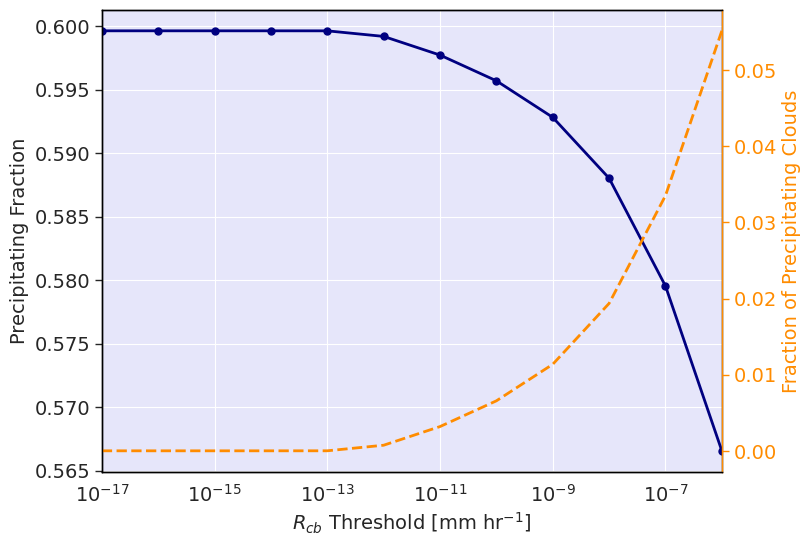

In [125]:
#-------------------------
# Check sensitivity to minimim PR threshold
#-------------------------
thresh_arr = np.arange(-17,-5)
thresh_arr = 10.**thresh_arr
frac_of_dataset = []
precip_fracx = []
for ii in range(len(thresh_arr)):
    dum_precip_binary = precip_binary.copy()
    dumid = np.where( (rcb < thresh_arr[ii]) & (dum_precip_binary == 1.) )
    frac_of_dataset.append(np.size(dumid)/np.size(dum_precip_binary[dum_precip_binary == 1.]))
    dum_precip_binary[dumid] = 0.
    
    precip_id = np.where(dum_precip_binary == 1.)
    tmp_precip_frac = np.size(precip_id)/np.size(dum_precip_binary)
    precip_fracx.append(tmp_precip_frac)
precip_fracx = np.array(precip_fracx)
frac_of_dataset = np.array(frac_of_dataset)

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
ax1a = ax1.twinx()
Fontsize=14
#ax1.grid(which='both',ls='dotted',c='grey',lw=1)
ax1.tick_params(labelsize=Fontsize)
ax1a.tick_params(labelsize=Fontsize,color='darkorange')
ax1a.spines['right'].set_color('darkorange')
ax1a.tick_params(axis='y', which='both',colors='darkorange')

ax1.set_ylabel('Precipitating Fraction',fontsize=Fontsize)
ax1a.set_ylabel('Fraction of Precipitating Clouds',fontsize=Fontsize,c='darkorange')
ax1.set_xlabel('$R_{cb}$ Threshold [mm hr$^{-1}$]',fontsize=Fontsize)
ax1.set_xscale('log')
ax1.set_xlim(np.min(thresh_arr),np.max(thresh_arr))
ax1.plot(thresh_arr,precip_fracx,lw=2,c='navy',marker='o',markersize=5)
ax1a.plot(thresh_arr,frac_of_dataset,lw=2,c='darkorange',ls='dashed')
ax1a.grid(False)
plt.show()
plt.close()

In [205]:
#----------------------------------------------------
#----------------------------------------------------
#----------------------------------------------------
# Rcb PDFs
#----------------------------------------------------
#----------------------------------------------------
#----------------------------------------------------

# Read in observational Rcb PDF
path = '/mnt/raid/mwstanfo/micre/'
infile = path+'micre_rcb_pdf_dict.p'
rcb_pdf_dict = pickle.load(open(infile,"rb"))


##sns.set_style('darkgrid',{"axes.facecolor": "grey"})
sns.set_theme()
sns.set_style('ticks')
#sns.set_style('darkgrid')
sns.set(rc={'axes.facecolor':'white','axes.edgecolor': 'black'})
sns.set_context('paper')

#matplotlib.rcParams.update(matplotlib.rcParamsDefault)
dumlw=3
Fontsize=16
fig = plt.figure(figsize=(12,10))
gs=GridSpec(2,6) # 2 rows, 6 columns
ax0 = fig.add_subplot(gs[0,1:5])
ax1 = fig.add_subplot(gs[1,0:3])       
ax2 = fig.add_subplot(gs[1,3:6])       

ax0.grid(which='both',ls='solid',color='grey')
ax1.grid(which='both',ls='solid',color='grey')
ax2.grid(which='both',ls='solid',color='grey')
ax0.tick_params(labelsize=Fontsize)
ax1.tick_params(labelsize=Fontsize)
ax2.tick_params(labelsize=Fontsize)
ax0.set_xlabel('R$_{cb}$ [mm hr$^{-1}$]',fontsize=Fontsize)
ax1.set_xlabel('R$_{cb}$ [mm hr$^{-1}$]',fontsize=Fontsize)
ax2.set_xlabel('R$_{cb}$ [mm hr$^{-1}$]',fontsize=Fontsize)
ax0.set_ylabel('Probability',fontsize=Fontsize)
ax1.set_ylabel('Probability',fontsize=Fontsize)
ax2.set_ylabel('Probability',fontsize=Fontsize)
ax0.set_xscale('log')
ax1.set_xscale('log')
ax2.set_xscale('log')


R_bins = np.arange(-6.,2.5,0.5)
midbins = np.array([(R_bins[ii]+R_bins[ii+1])/2. for ii in range(len(R_bins)-1)])


#------------------------------------
# Overarching distributions
#------------------------------------
dum_precip_binary = out_dict['precip_binary'].copy()
dum_ctt = out_dict['ctt'].copy()-273.15
dum_cbt = out_dict['cbt'].copy()-273.15
dum_cth = out_dict['cth'].copy()
dum_cbh = out_dict['cbh'].copy()
dum_c_thick = out_dict['c_thick'].copy()
dum_rcb = out_dict['rcb'].copy()

precip_id = np.where((dum_precip_binary == 1.) & (dum_cbh > 250.) )

dum_rcb = dum_rcb[precip_id]
dum_ctt = dum_ctt[precip_id]
dum_cbt = dum_cbt[precip_id]
dum_cbh = dum_cbh[precip_id]
dum_c_thick = dum_c_thick[precip_id]
dum_precip_binary = dum_precip_binary[precip_id]


ice_id = np.where( (dum_precip_binary == 1.) &
                   (dum_ctt < 0.) &
                   (dum_cbt < 0.) &
                   (dum_cbh > 250.))


IWflx_lim = dum_rcb[ice_id]

liq_id = np.where( (dum_precip_binary == 1.) &
                   (dum_ctt >= 0.) &
                   (dum_cbt >= 0.) &
                   (dum_cbh > 250.))

LWflx_lim = dum_rcb[liq_id]

cold_id = np.where( (dum_precip_binary == 1.) &
                   (dum_ctt < 0.) &
                   (dum_cbt >= 0.) &
                   (dum_cbh > 250.))

LWflx_coldctt_lim = dum_rcb[cold_id]


dum_rcb = np.concatenate((IWflx_lim,LWflx_lim,LWflx_coldctt_lim))

# Ice
a,bin_edges = np.histogram(np.log10(IWflx_lim),bins=R_bins,density=True)
samp_size = np.size(IWflx_lim)
samp_size_perc = np.around(samp_size/np.size(precip_id)*100.,2)
#ax0.plot(10.**(midbins),a,lw=3,c='blue',ls='dashed',label='E3 Supercooled, N={} ({}%)'.format(samp_size,samp_size_perc))
ax0.plot(10.**(midbins),a,lw=dumlw,c='blue',label='E3 Supercooled')


# Liquid
a,bin_edges = np.histogram(np.log10(LWflx_lim),bins=R_bins,density=True)
samp_size = np.size(LWflx_lim)
samp_size_perc = np.around(samp_size/np.size(precip_id)*100.,2)
#ax0.plot(10.**(midbins),a,lw=3,c='red',ls='dashed',label='E3 Warm, N={} ({}%)'.format(samp_size,samp_size_perc))
ax0.plot(10.**(midbins),a,lw=dumlw,c='red',label='E3 Warm')

# Liquid with cold CTTs
samp_size = np.size(LWflx_coldctt_lim)
samp_size_perc = np.around(samp_size/np.size(precip_id)*100.,2)
a,bin_edges = np.histogram(np.log10(LWflx_coldctt_lim),bins=R_bins,density=True)
#ax0.plot(10.**(midbins),a,lw=3,c='darkorange',ls='dashed',label='E3 Partially Supercooled, N={} ({}%)'.format(samp_size,samp_size_perc))
ax0.plot(10.**(midbins),a,lw=dumlw,c='darkorange',label='E3 Partially Supercooled')

#All
a,bin_edges = np.histogram(np.log10(dum_rcb),bins=R_bins,density=True)
samp_size = np.size(dum_rcb)
#ax0.plot(10.**(midbins),a,lw=3,c='black',ls='dashed',label='E3 All, N={}'.format(samp_size))
ax0.plot(10.**(midbins),a,lw=dumlw,c='black',label='E3 All')

# Plot observed
ax0.plot(10.**(midbins),rcb_pdf_dict['supercooled'],lw=2,c='blue',ls='dashed',label='MICRE Supercooled')
ax0.plot(10.**(midbins),rcb_pdf_dict['warm'],lw=2,c='red',ls='dashed',label='MICRE Warm Supercooled')
ax0.plot(10.**(midbins),rcb_pdf_dict['partially_supercooled'],lw=2,c='darkorange',ls='dashed',label='MICRE Partially Supercooled')
ax0.plot(10.**(midbins),rcb_pdf_dict['all'],lw=2,c='black',ls='dashed',label='MICRE All')


#------------------------------------
# Partitioned by CTT
#------------------------------------
dum_precip_binary = out_dict['precip_binary'].copy()
dum_ctt = out_dict['ctt'].copy()-273.15
dum_cbt = out_dict['cbt'].copy()-273.15
dum_cth = out_dict['cth'].copy()
dum_cbh = out_dict['cbh'].copy()
dum_c_thick = out_dict['c_thick'].copy()
dum_rcb = out_dict['rcb'].copy()

precip_id = np.where((dum_precip_binary == 1.)  & (dum_cbh > 250.))

dum_rcb = dum_rcb[precip_id]
dum_ctt = dum_ctt[precip_id]
dum_cbt = dum_cbt[precip_id]
dum_c_thick = dum_c_thick[precip_id]
dum_precip_binary = dum_precip_binary[precip_id]
dum_cbh = dum_cbh[precip_id]

ice_id = np.where((dum_precip_binary == 1.) &
                  (dum_ctt < 0.) &
                  (dum_cbt < 0.) &
                  (dum_cbh > 250.))


IWflx_lim = dum_rcb[ice_id]
ctt_super = dum_ctt[ice_id]

liq_id = np.where((dum_precip_binary == 1.) &
                  (dum_ctt >= 0.) &
                  (dum_cbt >= 0.) &
                  (dum_cbh > 250.))

LWflx_lim = dum_rcb[liq_id]
ctt_warm = dum_ctt[liq_id]

cold_id = np.where((dum_precip_binary == 1.) &
                  (dum_ctt < 0.) &
                  (dum_cbh > 250.) &
                  (dum_cbt >= 0.))

LWflx_coldctt_lim = dum_rcb[cold_id]
ctt_cold = dum_ctt[cold_id]

dum_rcb = np.concatenate((IWflx_lim,LWflx_lim,LWflx_coldctt_lim))
tmp_ctt = np.concatenate((ctt_super,ctt_warm,ctt_cold))

tmpid = np.where(tmp_ctt < -30.)
rcb_lt30 = dum_rcb[tmpid]
tmpid = np.where((tmp_ctt >= -30.) & (tmp_ctt < -20.))
rcb_30to20 = dum_rcb[tmpid]
tmpid = np.where((tmp_ctt >= -20.) & (tmp_ctt <-10.))
rcb_20to10 = dum_rcb[tmpid]
tmpid = np.where((tmp_ctt >= -10.) & (tmp_ctt < 0.))
rcb_10to0 = dum_rcb[tmpid]
tmpid = np.where(tmp_ctt > 0.)
rcb_gt0 = dum_rcb[tmpid]

rcb_lt30 = rcb_lt30[rcb_lt30 > 0.]
rcb_30to20 = rcb_30to20[rcb_30to20 > 0.]
rcb_20to10 = rcb_20to10[rcb_20to10 > 0.]
rcb_10to0 = rcb_10to0[rcb_10to0 > 0.]
rcb_gt0 = rcb_gt0[rcb_gt0 > 0.]


R_bins = np.arange(-6.,2.5,0.5)
midbins = np.array([(R_bins[ii]+R_bins[ii+1])/2. for ii in range(len(R_bins)-1)])




# lt -30
a,bin_edges = np.histogram(np.log10(rcb_lt30),bins=R_bins,density=True)
samp_size = np.size(rcb_lt30)
#ax1.plot(10.**(midbins),a,lw=3,c='navy',label='CTT < -30 $^{\\circ}$C, N='+str(samp_size))
ax1.plot(10.**(midbins),a,lw=dumlw,c='navy',label='CTT < -30 $^{\\circ}$C')

# -30 to -20
a,bin_edges = np.histogram(np.log10(rcb_30to20),bins=R_bins,density=True)
samp_size = np.size(rcb_30to20)
#ax1.plot(10.**(midbins),a,lw=3,c='blue',label='-30 $\leq$ CTT < -20 $^{\\circ}$C, N='+str(samp_size))
ax1.plot(10.**(midbins),a,lw=dumlw,c='blue',label='-30 $\leq$ CTT < -20 $^{\\circ}$C')

# -20 to -10
a,bin_edges = np.histogram(np.log10(rcb_20to10),bins=R_bins,density=True)
samp_size = np.size(rcb_20to10)
#ax1.plot(10.**(midbins),a,lw=3,c='deepskyblue',label='-20 $\leq$ CTT < -10$^{\\circ}$C, N='+str(samp_size))
ax1.plot(10.**(midbins),a,lw=dumlw,c='deepskyblue',label='-20 $\leq$ CTT < -10$^{\\circ}$C')

# -10 to -0
a,bin_edges = np.histogram(np.log10(rcb_10to0),bins=R_bins,density=True)
samp_size = np.size(rcb_10to0)
#ax1.plot(10.**(midbins),a,lw=3,c='powderblue',label='-10 $\leq$ CTT < 0$^{\\circ}$C, N='+str(samp_size))
ax1.plot(10.**(midbins),a,lw=dumlw,c='powderblue',label='-10 $\leq$ CTT < 0$^{\\circ}$C')

# gt 0
a,bin_edges = np.histogram(np.log10(rcb_gt0),bins=R_bins,density=True)
samp_size = np.size(rcb_gt0)
#ax1.plot(10.**(midbins),a,lw=3,c='red',label='CTT > 0$^{\\circ}$C, N='+str(samp_size))
ax1.plot(10.**(midbins),a,lw=dumlw,c='red',label='CTT $\geq$ 0$^{\\circ}$C')




dum_thresh = 6*60.*60.
#------------------------------------
# Partitioned by c_thick
#------------------------------------
dum_precip_binary = out_dict['precip_binary'].copy()
dum_ctt = out_dict['ctt'].copy()-273.15
dum_cbt = out_dict['cbt'].copy()-273.15
dum_cth = out_dict['cth'].copy()
dum_cbh = out_dict['cbh'].copy()
dum_c_thick = out_dict['c_thick'].copy()
dum_rcb = out_dict['rcb'].copy()

precip_id = np.where((dum_precip_binary == 1.) & (dum_cbh > 250.) )

dum_rcb = dum_rcb[precip_id]
dum_ctt = dum_ctt[precip_id]
dum_cbt = dum_cbt[precip_id]
dum_cbh = dum_cbh[precip_id]
dum_c_thick = dum_c_thick[precip_id]
dum_precip_binary = dum_precip_binary[precip_id]





tmpid = np.where((dum_c_thick >= 50.) & (dum_c_thick < 100))
rcb_50to100 = dum_rcb[tmpid]
tmpid = np.where((dum_c_thick >= 100) & (dum_c_thick < 200))
rcb_100to200 = dum_rcb[tmpid]
tmpid = np.where((dum_c_thick >= 200) & (dum_c_thick < 300))
rcb_200to300 = dum_rcb[tmpid]
tmpid = np.where((dum_c_thick >= 300) & (dum_c_thick < 400))
rcb_300to400 = dum_rcb[tmpid]
tmpid = np.where((dum_c_thick >= 400) & (dum_c_thick < 500))
rcb_400to500 = dum_rcb[tmpid]    
tmpid = np.where((dum_c_thick >= 500) & (dum_c_thick < 1000))
rcb_500to1000 = dum_rcb[tmpid]     
tmpid = np.where((dum_c_thick > 1000))
rcb_gt1000 = dum_rcb[tmpid]      


rcb_50to100 = rcb_50to100[rcb_50to100 > 0.]
rcb_100to200 = rcb_100to200[rcb_100to200 > 0.]
rcb_200to300 = rcb_200to300[rcb_200to300 > 0.]
rcb_300to400 = rcb_300to400[rcb_300to400 > 0.]
rcb_400to500 = rcb_400to500[rcb_400to500 > 0.]
rcb_500to1000 = rcb_500to1000[rcb_500to1000 > 0.]


# 50 < thick < 100
a,bin_edges = np.histogram(np.log10(rcb_50to100),bins=R_bins,density=True)
samp_size = np.size(rcb_50to100)
#ax2.plot(10.**(midbins),a,lw=3,c='navy',label='50 $\leq$ Thick < 100 m, N='+str(samp_size))
ax2.plot(10.**(midbins),a,lw=dumlw,c='navy',label='50 $\leq$ Thick < 100 m')

# 100 < thick < 200
a,bin_edges = np.histogram(np.log10(rcb_100to200),bins=R_bins,density=True)
samp_size = np.size(rcb_100to200)
#ax2.plot(10.**(midbins),a,lw=3,c='blue',label='100 $\leq$ Thick < 200 m, N='+str(samp_size))
ax2.plot(10.**(midbins),a,lw=dumlw,c='blue',label='100 $\leq$ Thick < 200 m')

# 200 < thick < 300
a,bin_edges = np.histogram(np.log10(rcb_200to300),bins=R_bins,density=True)
samp_size = np.size(rcb_200to300)
#ax2.plot(10.**(midbins),a,lw=3,c='deepskyblue',label='200 $\leq$ Thick < 300 m, N='+str(samp_size))
ax2.plot(10.**(midbins),a,lw=dumlw,c='deepskyblue',label='200 $\leq$ Thick < 300 m')

# 300 < thick < 400
a,bin_edges = np.histogram(np.log10(rcb_300to400),bins=R_bins,density=True)
samp_size = np.size(rcb_300to400)
#ax2.plot(10.**(midbins),a,lw=3,c='green',label='300 $\leq$ Thick < 400 m, N='+str(samp_size))
ax2.plot(10.**(midbins),a,lw=dumlw,c='green',label='300 $\leq$ Thick < 400 m')

# 400 < thick < 500
a,bin_edges = np.histogram(np.log10(rcb_400to500),bins=R_bins,density=True)
samp_size = np.size(rcb_400to500)
#ax2.plot(10.**(midbins),a,lw=3,c='gold',label='400 $\leq$ Thick < 500 m, N='+str(samp_size))
ax2.plot(10.**(midbins),a,lw=dumlw,c='gold',label='400 $\leq$ Thick < 500 m')

# 500 < thick < 1000
a,bin_edges = np.histogram(np.log10(rcb_500to1000),bins=R_bins,density=True)
samp_size = np.size(rcb_500to1000)
#ax2.plot(10.**(midbins),a,lw=3,c='darkorange',label='500 $\leq$ Thick < 1000 m, N='+str(samp_size)) 
ax2.plot(10.**(midbins),a,lw=dumlw,c='darkorange',label='500 $\leq$ Thick < 1000 m') 

# thick > 1000
a,bin_edges = np.histogram(np.log10(rcb_gt1000),bins=R_bins,density=True)
samp_size = np.size(rcb_gt1000)
a#x2.plot(10.**(midbins),a,lw=3,c='red',label='Thick > 1000 m, N='+str(samp_size))
ax2.plot(10.**(midbins),a,lw=dumlw,c='red',label='Thick $\geq$ 1000 m')


ax0.text(-0.125,1.05,'(a)',fontsize=Fontsize*2.5,transform=ax0.transAxes)
ax1.text(-0.15,1.05,'(b)',fontsize=Fontsize*2.5,transform=ax1.transAxes)
ax2.text(-0.17,1.05,'(c)',fontsize=Fontsize*2.5,transform=ax2.transAxes)

dum1=ax1.text(0.015,0.765,'Partitioned by\nCTT',fontsize=Fontsize*1.4,transform=ax1.transAxes)
dum2=ax2.text(0.013,0.765,'Partitioned by\nThickness',fontsize=Fontsize*1.4,transform=ax2.transAxes)

dum1.set_bbox(dict(facecolor='lavender', alpha=1, edgecolor='black'))
dum2.set_bbox(dict(facecolor='lavender', alpha=1, edgecolor='black'))

#ax0.legend(fontsize=Fontsize*0.9,loc='upper center',bbox_to_anchor=(0.55,1.4),ncol=2,framealpha=0)
#ax1.legend(fontsize=Fontsize*0.75,bbox_to_anchor=(0.5,1.4),ncol=2,loc='upper center',framealpha=0)
#ax2.legend(fontsize=Fontsize*0.75,bbox_to_anchor=(0.525,1.4),ncol=2,loc='upper center',framealpha=0,columnspacing=0.5)
ax0.legend(fontsize=Fontsize*0.65,loc='upper center',bbox_to_anchor=(0.45,1.35),ncol=2,framealpha=0)
ax1.legend(fontsize=Fontsize*0.65,bbox_to_anchor=(0.5,1.3),ncol=2,loc='upper center',framealpha=0)
ax2.legend(fontsize=Fontsize*0.65,bbox_to_anchor=(0.51,1.35),ncol=2,loc='upper center',framealpha=0,columnspacing=0.5)

plt.subplots_adjust(wspace=0.9,hspace=0.6)
ax0.xaxis.tick_bottom()
ax0.yaxis.tick_left()
ax1.xaxis.tick_bottom()
ax1.yaxis.tick_left()
ax2.xaxis.tick_bottom()
ax2.yaxis.tick_left()

ax1.set_ylim(-0.025,0.65)
ax2.set_ylim(-0.025,0.65)

fig_path = '/home/mwstanfo/figures/micre_paper/'
#outfile = 'fig_12.png'
outfile = 'fig_12.eps'
#plt.show()
plt.savefig(fig_path+outfile,dpi=200,bbox_inches='tight')
plt.close()
print('done')

done


In [ ]:
#----------------------------------------------------
#----------------------------------------------------
#----------------------------------------------------
# Rcb PDFs
#----------------------------------------------------
#----------------------------------------------------
#----------------------------------------------------
##sns.set_style('darkgrid',{"axes.facecolor": "grey"})
sns.set_theme()
sns.set_style('ticks')
#sns.set_style('darkgrid')
sns.set(rc={'axes.facecolor':'white','axes.edgecolor': 'black'})
sns.set_context('paper')

#matplotlib.rcParams.update(matplotlib.rcParamsDefault)

Fontsize=16
fig = plt.figure(figsize=(14,12))
gs=GridSpec(2,6) # 2 rows, 6 columns
ax0 = fig.add_subplot(gs[0,1:5])
ax1 = fig.add_subplot(gs[1,0:3])       
ax2 = fig.add_subplot(gs[1,3:6])       

ax0.grid(which='both',ls='solid',color='grey')
ax1.grid(which='both',ls='solid',color='grey')
ax2.grid(which='both',ls='solid',color='grey')
ax0.tick_params(labelsize=Fontsize)
ax1.tick_params(labelsize=Fontsize)
ax2.tick_params(labelsize=Fontsize)
ax0.set_xlabel('R$_{cb}$ [mm hr$^{-1}$]',fontsize=Fontsize)
ax1.set_xlabel('R$_{cb}$ [mm hr$^{-1}$]',fontsize=Fontsize)
ax2.set_xlabel('R$_{cb}$ [mm hr$^{-1}$]',fontsize=Fontsize)
ax0.set_ylabel('Probability',fontsize=Fontsize)
ax1.set_ylabel('Probability',fontsize=Fontsize)
ax2.set_ylabel('Probability',fontsize=Fontsize)
ax0.set_xscale('log')
ax1.set_xscale('log')
ax2.set_xscale('log')


R_bins = np.arange(-6.,2.5,0.5)
midbins = np.array([(R_bins[ii]+R_bins[ii+1])/2. for ii in range(len(R_bins)-1)])


#------------------------------------
# Overarching distributions
#------------------------------------
dum_precip_binary = precip_binary.copy()
dum_ctt = ctt.copy()
dum_cth = cth.copy()
dum_cbt = cbt.copy()
dum_c_thick = c_thick.copy()
dum_rcb = rcb.copy()

precip_id = np.where((dum_precip_binary == 1.) & (~np.isnan(dum_ctt)) & (~np.isnan(dum_cbt)))

dum_rcb = dum_rcb[precip_id]
dum_ctt = dum_ctt[precip_id]
dum_cbt = dum_cbt[precip_id]
dum_c_thick = dum_c_thick[precip_id]
dum_precip_binary = dum_precip_binary[precip_id]


ice_id = np.where( (dum_precip_binary == 1.) &
                   (dum_ctt < 0.) &
                   (dum_cbt < 0.))


IWflx_lim = dum_rcb[ice_id]

liq_id = np.where( (dum_precip_binary == 1.) &
                   (dum_ctt >= 0.) &
                   (dum_cbt >= 0.))

LWflx_lim = dum_rcb[liq_id]

cold_id = np.where( (dum_precip_binary == 1.) &
                   (dum_ctt < 0.) &
                   (dum_cbt >= 0.))

LWflx_coldctt_lim = dum_rcb[cold_id]




dum_rcb = np.concatenate((IWflx_lim,LWflx_lim,LWflx_coldctt_lim))

# Ice
a,bin_edges = np.histogram(np.log10(IWflx_lim),bins=R_bins,density=True)
samp_size = np.size(IWflx_lim)
samp_size_perc = np.around(samp_size/np.size(precip_id)*100.,2)
ax0.plot(10.**(midbins),a,lw=3,c='blue',label='Supercooled, N={} ({}%)'.format(samp_size,samp_size_perc))
#ax0.plot(10.**(midbins),a,lw=3,c='blue',label='Supercooled')

# Liquid
a,bin_edges = np.histogram(np.log10(LWflx_lim),bins=R_bins,density=True)
samp_size = np.size(LWflx_lim)
samp_size_perc = np.around(samp_size/np.size(precip_id)*100.,2)
ax0.plot(10.**(midbins),a,lw=3,c='red',label='Warm, N={} ({}%)'.format(samp_size,samp_size_perc))
#ax0.plot(10.**(midbins),a,lw=3,c='red',label='Warm')

# Liquid with cold CTTs
samp_size = np.size(LWflx_coldctt_lim)
samp_size_perc = np.around(samp_size/np.size(precip_id)*100.,2)
a,bin_edges = np.histogram(np.log10(LWflx_coldctt_lim),bins=R_bins,density=True)
ax0.plot(10.**(midbins),a,lw=3,c='darkorange',label='Partially Supercooled, N={} ({}%)'.format(samp_size,samp_size_perc))
#ax0.plot(10.**(midbins),a,lw=3,c='darkorange',label='Partially Supercooled')

#All
a,bin_edges = np.histogram(np.log10(dum_rcb),bins=R_bins,density=True)
samp_size = np.size(dum_rcb)
ax0.plot(10.**(midbins),a,lw=3,c='black',label='All, N={}'.format(samp_size))
#ax0.plot(10.**(midbins),a,lw=3,c='black',label='All')

# NSA
#ax1.plot(10.**(midbins_2),nsa_mcm[0,:],c='darkgreen',lw=3,label='Arctic, supercooled')

# McMurdo
#ax1.plot(10.**(midbins_2),nsa_mcm[1,:],c='lightgreen',lw=3,label='Antarctic, supercooled')

#------------------------------------
# Partitioned by CTT
#------------------------------------

dum_precip_binary = precip_binary.copy()
dum_ctt = ctt.copy()
dum_cth = cth.copy()
dum_cbt = cbt.copy()
dum_c_thick = c_thick.copy()
dum_rcb = rcb.copy()

precip_id = np.where((dum_precip_binary == 1.) & (~np.isnan(dum_ctt)) & (~np.isnan(dum_cbt)))

dum_rcb = dum_rcb[precip_id]
dum_ctt = dum_ctt[precip_id]
dum_cbt = dum_cbt[precip_id]
dum_c_thick = dum_c_thick[precip_id]
dum_precip_binary = dum_precip_binary[precip_id]

ice_id = np.where((dum_precip_binary == 1.) &
                  (dum_ctt < 0.) &
                  (dum_cbt < 0.))


IWflx_lim = dum_rcb[ice_id]
ctt_super = dum_ctt[ice_id]


liq_id = np.where((dum_precip_binary == 1.) &
                  (dum_ctt >= 0.) &
                  (dum_cbt >= 0.))

LWflx_lim = dum_rcb[liq_id]
ctt_warm = dum_ctt[liq_id]

cold_id = np.where((dum_precip_binary == 1.) &
                  (dum_ctt < 0.) &
                  (dum_cbt >= 0.))

LWflx_coldctt_lim = dum_rcb[cold_id]
ctt_cold = dum_ctt[cold_id]

dum_rcb = np.concatenate((IWflx_lim,LWflx_lim,LWflx_coldctt_lim))
tmp_ctt = np.concatenate((ctt_super,ctt_warm,ctt_cold))
   

tmpid = np.where(tmp_ctt < -30.)
rcb_lt30 = dum_rcb[tmpid]
tmpid = np.where((tmp_ctt >= -30.) & (tmp_ctt < -20.))
rcb_30to20 = dum_rcb[tmpid]
tmpid = np.where((tmp_ctt >= -20.) & (tmp_ctt <-10.))
rcb_20to10 = dum_rcb[tmpid]
tmpid = np.where((tmp_ctt >= -10.) & (tmp_ctt < 0.))
rcb_10to0 = dum_rcb[tmpid]
tmpid = np.where(tmp_ctt > 0.)
rcb_gt0 = dum_rcb[tmpid]

rcb_lt30 = rcb_lt30[rcb_lt30 > 0.]
rcb_30to20 = rcb_30to20[rcb_30to20 > 0.]
rcb_20to10 = rcb_20to10[rcb_20to10 > 0.]
rcb_10to0 = rcb_10to0[rcb_10to0 > 0.]
rcb_gt0 = rcb_gt0[rcb_gt0 > 0.]


R_bins = np.arange(-6.,2.5,0.5)
midbins = np.array([(R_bins[ii]+R_bins[ii+1])/2. for ii in range(len(R_bins)-1)])




# lt -30
a,bin_edges = np.histogram(np.log10(rcb_lt30),bins=R_bins,density=True)
samp_size = np.size(rcb_lt30)
#ax1.plot(10.**(midbins),a,lw=3,c='navy',label='CTT < -30 $^{\\circ}$C, N='+str(samp_size))
ax1.plot(10.**(midbins),a,lw=3,c='navy',label='CTT < -30 $^{\\circ}$C')

# -30 to -20
a,bin_edges = np.histogram(np.log10(rcb_30to20),bins=R_bins,density=True)
samp_size = np.size(rcb_30to20)
#ax1.plot(10.**(midbins),a,lw=3,c='blue',label='-30 $\leq$ CTT < -20 $^{\\circ}$C, N='+str(samp_size))
ax1.plot(10.**(midbins),a,lw=3,c='blue',label='-30 $\leq$ CTT < -20 $^{\\circ}$C')

# -20 to -10
a,bin_edges = np.histogram(np.log10(rcb_20to10),bins=R_bins,density=True)
samp_size = np.size(rcb_20to10)
#ax1.plot(10.**(midbins),a,lw=3,c='deepskyblue',label='-20 $\leq$ CTT < -10$^{\\circ}$C, N='+str(samp_size))
ax1.plot(10.**(midbins),a,lw=3,c='deepskyblue',label='-20 $\leq$ CTT < -10$^{\\circ}$C')

# -10 to -0
a,bin_edges = np.histogram(np.log10(rcb_10to0),bins=R_bins,density=True)
samp_size = np.size(rcb_10to0)
#ax1.plot(10.**(midbins),a,lw=3,c='powderblue',label='-10 $\leq$ CTT < 0$^{\\circ}$C, N='+str(samp_size))
ax1.plot(10.**(midbins),a,lw=3,c='powderblue',label='-10 $\leq$ CTT < 0$^{\\circ}$C')

# gt 0
a,bin_edges = np.histogram(np.log10(rcb_gt0),bins=R_bins,density=True)
samp_size = np.size(rcb_gt0)
#ax1.plot(10.**(midbins),a,lw=3,c='red',label='CTT > 0$^{\\circ}$C, N='+str(samp_size))
ax1.plot(10.**(midbins),a,lw=3,c='red',label='CTT $\geq$ 0$^{\\circ}$C')




dum_thresh = 6*60.*60.
#------------------------------------
# Partitioned by c_thick
#------------------------------------
dum_precip_binary = precip_binary.copy()
dum_ctt = ctt.copy()
dum_cth = cth.copy()
dum_cbt = cbt.copy()
dum_c_thick = c_thick.copy()
dum_rcb = rcb.copy()

precip_id = np.where((dum_precip_binary == 1.) & (~np.isnan(dum_ctt)) & (~np.isnan(dum_cbt)))

dum_rcb = dum_rcb[precip_id]
dum_ctt = dum_ctt[precip_id]
dum_cbt = dum_cbt[precip_id]
dum_c_thick = dum_c_thick[precip_id]
dum_precip_binary = dum_precip_binary[precip_id]





tmpid = np.where((dum_c_thick >= 50.) & (dum_c_thick < 100))
rcb_50to100 = dum_rcb[tmpid]
tmpid = np.where((dum_c_thick >= 100) & (dum_c_thick < 200))
rcb_100to200 = dum_rcb[tmpid]
tmpid = np.where((dum_c_thick >= 200) & (dum_c_thick < 300))
rcb_200to300 = dum_rcb[tmpid]
tmpid = np.where((dum_c_thick >= 300) & (dum_c_thick < 400))
rcb_300to400 = dum_rcb[tmpid]
tmpid = np.where((dum_c_thick >= 400) & (dum_c_thick < 500))
rcb_400to500 = dum_rcb[tmpid]    
tmpid = np.where((dum_c_thick >= 500) & (dum_c_thick < 1000))
rcb_500to1000 = dum_rcb[tmpid]     
tmpid = np.where((dum_c_thick > 1000))
rcb_gt1000 = dum_rcb[tmpid]      


rcb_50to100 = rcb_50to100[rcb_50to100 > 0.]
rcb_100to200 = rcb_100to200[rcb_100to200 > 0.]
rcb_200to300 = rcb_200to300[rcb_200to300 > 0.]
rcb_300to400 = rcb_300to400[rcb_300to400 > 0.]
rcb_400to500 = rcb_400to500[rcb_400to500 > 0.]
rcb_500to1000 = rcb_500to1000[rcb_500to1000 > 0.]


# 50 < thick < 100
a,bin_edges = np.histogram(np.log10(rcb_50to100),bins=R_bins,density=True)
samp_size = np.size(rcb_50to100)
#ax2.plot(10.**(midbins),a,lw=3,c='navy',label='50 $\leq$ Thick < 100 m, N='+str(samp_size))
ax2.plot(10.**(midbins),a,lw=3,c='navy',label='50 $\leq$ Thick < 100 m')

# 100 < thick < 200
a,bin_edges = np.histogram(np.log10(rcb_100to200),bins=R_bins,density=True)
samp_size = np.size(rcb_100to200)
#ax2.plot(10.**(midbins),a,lw=3,c='blue',label='100 $\leq$ Thick < 200 m, N='+str(samp_size))
ax2.plot(10.**(midbins),a,lw=3,c='blue',label='100 $\leq$ Thick < 200 m')

# 200 < thick < 300
a,bin_edges = np.histogram(np.log10(rcb_200to300),bins=R_bins,density=True)
samp_size = np.size(rcb_200to300)
#ax2.plot(10.**(midbins),a,lw=3,c='deepskyblue',label='200 $\leq$ Thick < 300 m, N='+str(samp_size))
ax2.plot(10.**(midbins),a,lw=3,c='deepskyblue',label='200 $\leq$ Thick < 300 m')

# 300 < thick < 400
a,bin_edges = np.histogram(np.log10(rcb_300to400),bins=R_bins,density=True)
samp_size = np.size(rcb_300to400)
#ax2.plot(10.**(midbins),a,lw=3,c='green',label='300 $\leq$ Thick < 400 m, N='+str(samp_size))
ax2.plot(10.**(midbins),a,lw=3,c='green',label='300 $\leq$ Thick < 400 m')

# 400 < thick < 500
a,bin_edges = np.histogram(np.log10(rcb_400to500),bins=R_bins,density=True)
samp_size = np.size(rcb_400to500)
#ax2.plot(10.**(midbins),a,lw=3,c='gold',label='400 $\leq$ Thick < 500 m, N='+str(samp_size))
ax2.plot(10.**(midbins),a,lw=3,c='gold',label='400 $\leq$ Thick < 500 m')

# 500 < thick < 1000
a,bin_edges = np.histogram(np.log10(rcb_500to1000),bins=R_bins,density=True)
samp_size = np.size(rcb_500to1000)
#ax2.plot(10.**(midbins),a,lw=3,c='darkorange',label='500 $\leq$ Thick < 1000 m, N='+str(samp_size)) 
ax2.plot(10.**(midbins),a,lw=3,c='darkorange',label='500 $\leq$ Thick < 1000 m') 

# thick > 1000
a,bin_edges = np.histogram(np.log10(rcb_gt1000),bins=R_bins,density=True)
samp_size = np.size(rcb_gt1000)
a#x2.plot(10.**(midbins),a,lw=3,c='red',label='Thick > 1000 m, N='+str(samp_size))
ax2.plot(10.**(midbins),a,lw=3,c='red',label='Thick $\geq$ 1000 m')



#tmpstr = 'Partitioning by:'
#ax1.text(1.1,1.35,tmpstr,fontweight='bold',fontsize=Fontsize*2.,\
#         ha='center',va='center',transform=ax1.transAxes)    
#tmpstr = 'CTT'
#ax1.text(0.5,1.25,tmpstr,fontweight='bold',fontsize=Fontsize*2.,\
#         ha='center',va='center',transform=ax1.transAxes)
#tmpstr = 'Thickness'
#ax2.text(0.5,1.25,tmpstr,fontweight='bold',fontsize=Fontsize*2.,ha='center',va='center',\
#        transform=ax2.transAxes)

ax0.text(-0.125,1.05,'(a)',fontsize=Fontsize*2.75,transform=ax0.transAxes)
ax1.text(-0.15,1.2,'(b)',fontsize=Fontsize*2.75,transform=ax1.transAxes)
ax2.text(-0.15,1.2,'(c)',fontsize=Fontsize*2.75,transform=ax2.transAxes)

dum1=ax1.text(0.01,0.8,'Partitioned by\nCTT',fontsize=Fontsize*1.45,transform=ax1.transAxes)
dum2=ax2.text(0.01,0.8,'Partitioned by\nThickness',fontsize=Fontsize*1.45,transform=ax2.transAxes)

dum1.set_bbox(dict(facecolor='lavender', alpha=1, edgecolor='black'))
dum2.set_bbox(dict(facecolor='lavender', alpha=1, edgecolor='black'))

ax0.legend(fontsize=Fontsize*0.9,loc='upper center',bbox_to_anchor=(0.5,1.4),ncol=1,framealpha=0)
ax1.legend(fontsize=Fontsize*0.75,bbox_to_anchor=(0.5,1.4),ncol=2,loc='upper center',framealpha=0)
ax2.legend(fontsize=Fontsize*0.75,bbox_to_anchor=(0.525,1.4),ncol=2,loc='upper center',framealpha=0,columnspacing=0.5)


plt.subplots_adjust(wspace=0.7,hspace=0.6)
ax0.xaxis.tick_bottom()
ax0.yaxis.tick_left()
ax1.xaxis.tick_bottom()
ax1.yaxis.tick_left()
ax2.xaxis.tick_bottom()
ax2.yaxis.tick_left()

plt.show()
plt.close()    


In [ ]:
def filter_data(precip_binary,cbt,ctt,in_var,filter_type):
    dumid = np.where(in_var > -999.)
    in_var = in_var[dumid]
    cbt = cbt[dumid]
    ctt = ctt[dumid]
    precip_binary = precip_binary[dumid]
    
    dumid = np.where(ctt > -999.)
    in_var = in_var[dumid]
    cbt = cbt[dumid]
    ctt = ctt[dumid]
    precip_binary = precip_binary[dumid]
    
    dumid = np.where(cbt > -999.)
    in_var = in_var[dumid]
    cbt = cbt[dumid]
    ctt = ctt[dumid]
    precip_binary = precip_binary[dumid]
    
    if filter_type == 'supercooled':
        precip_0 = np.where((precip_binary == 0.) & (cbt < 0.) & (ctt < 0.))
        precip_1 = np.where((precip_binary == 1.) & (cbt < 0.) & (ctt < 0.))
        all_id = np.where((precip_binary > -999.) & (cbt < 0.) & (ctt < 0.))
        #all_id = np.where((cbt < 0.) & (ctt < 0.))
    elif filter_type == 'partially_supercooled':
        precip_0 = np.where((precip_binary == 0.) & (cbt >= 0.) & (ctt < 0.))
        precip_1 = np.where((precip_binary == 1.) & (cbt >= 0.) & (ctt < 0.))
        all_id = np.where((precip_binary > -999.) & (cbt >= 0.) & (ctt < 0.))
        #all_id = np.where((cbt >= 0.) & (ctt < 0.))
    elif filter_type == 'warm':
        precip_0 = np.where((precip_binary == 0.) & (cbt >= 0.) & (ctt >= 0.))
        precip_1 = np.where((precip_binary == 1.) & (cbt >= 0.) & (ctt >= 0.))
        all_id = np.where((precip_binary > -999.) & (cbt >= 0.) & (ctt >= 0.))
        #all_id = np.where((cbt >= 0.) & (ctt >= 0.))
    elif filter_type == 'all':
        precip_0 = np.where((precip_binary == 0.))
        precip_1 = np.where((precip_binary == 1.))
        all_id = np.where((precip_binary > -999.))
        #all_id = np.where((precip_binary == 0. ) | (precip_binary == 1.) | (np.isnan(precip_binary)))
    else:
        raise RuntimeError('Do better.')
        
    var_precip = in_var[precip_1]
    var_nonprecip = in_var[precip_0]
    var_all = in_var[all_id]
    return var_precip, var_nonprecip, var_all

In [ ]:
#--------------------------------------------
# Occurrence Frequency
#--------------------------------------------
def occur_freq(data,bins,full_length):
    tmp_hist = []
    for ii in range(len(bins)-1):
        if ii != (len(bins)-2):
            tmpid = np.where((data >= bins[ii]) & (data < bins[ii+1]))
            tmp_hist.append(np.size(tmpid)/full_length)
        elif ii == (len(bins)-2):
            tmpid = np.where((data >= bins[ii]) & (data <= bins[ii+1]))
            tmp_hist.append(np.size(tmpid)/full_length)            
    tmp_hist = np.array(tmp_hist)
    return tmp_hist,bins

In [ ]:
#--------------------------------------------
# Function to calculate precipitating fraction
#--------------------------------------------
def precip_frac(data1,data2,bins):
    data1 = data1[~np.isnan(data1)]
    #data1 = data1[data1 > -999.]
    data2 = data2[~np.isnan(data2)]
    #data2 = data2[data2 > -999.]
    thresh_frac = 0.005
    pf = []
    for ii in range(len(bins)-1):
        if ii != (len(bins)-2):
            tmpid1 = np.where((data1 >= bins[ii]) & (data1 < bins[ii+1]))
            tmpid2 = np.where((data2 >= bins[ii]) & (data2 < bins[ii+1]))
            if (np.size(tmpid2)/np.size(data2)) < thresh_frac:
                pf.append(np.nan)
            else:
                pf.append(np.size(tmpid1)/np.size(tmpid2))
        elif ii == (len(bins)-2):
            tmpid1 = np.where((data1 >= bins[ii]) & (data1 <= bins[ii+1]))
            tmpid2 = np.where((data2 >= bins[ii]) & (data2 <= bins[ii+1]))
            if (np.size(tmpid2)/np.size(data2)) < thresh_frac:
                pf.append(np.nan)
            else:
                pf.append(np.size(tmpid1)/np.size(tmpid2))
    pf = np.array(pf)
    return pf

In [ ]:
#----------------------------------------------------
#----------------------------------------------------
#----------------------------------------------------
# Histograms of CBH, CTT, and Cloud Thickness
#----------------------------------------------------
#----------------------------------------------------
#----------------------------------------------------
dum_ctt = ctt.copy()
dum_cbh = cbh.copy()
dum_cth = cth.copy()
dum_cbt = cbt.copy()
dum_precip_binary = precip_binary.copy()
dum_c_thick = c_thick.copy()


sns.set_style('ticks')
sns.set(rc={'axes.facecolor':'white','axes.edgecolor': 'black'})
sns.set_context('talk')

pink_color = 'lightpink'
pink_edgecolor = 'black'
pink_alpha = 1
green_color = 'darkgreen'
green_edgecolor = 'black'
green_alpha = 0.6

Fontsize=15
dummult = 1.15

fig = plt.figure(figsize=(20,14))
gs=GridSpec(3,8) # 7 rows, 6 columns

# Cloud Depth
ax1 = fig.add_subplot(gs[0,0:2]) #row, column        
ax2 = fig.add_subplot(gs[0,2:4]) # row, column        
ax3 = fig.add_subplot(gs[0,4:6]) # row, column        
ax4 = fig.add_subplot(gs[0,6:8]) # row, column
axlist1 = [ax1,ax2,ax3,ax4]

ax1a = ax1.twinx()
ax2a = ax2.twinx()
ax3a = ax3.twinx()
ax4a = ax4.twinx()

axlist1a = [ax1a,ax2a,ax3a,ax4a]
for ax in axlist1a:
    ax.tick_params(labelsize=Fontsize*dummult)
    ax.set_ylim(0,1.05)
    ax.set_yticks([0,0.5,1])
    ax.grid(False)
ax4a.set_ylabel('Precipitating Fraction',fontsize=Fontsize*dummult)
ax1.set_ylabel('Occurrence Frequency',fontsize=Fontsize*dummult)

# CBH
ax5 = fig.add_subplot(gs[1,0:2]) #row, column 
ax6 = fig.add_subplot(gs[1,2:4]) #row, column 
ax7 = fig.add_subplot(gs[1,4:6]) #row, column 
ax8 = fig.add_subplot(gs[1,6:8]) #row, column
axlist2 = [ax5,ax6,ax7,ax8]
for ax in axlist2:
    ax.set_xlabel('Cloud Thickness [m]',fontsize=Fontsize*dummult)
    ax.tick_params(labelsize=Fontsize*dummult)
    ax.grid(which='both',ls='solid',color='grey') 
    
ax5a = ax5.twinx()
ax6a = ax6.twinx()
ax7a = ax7.twinx()
ax8a = ax8.twinx()

axlist2a = [ax5a,ax6a,ax7a,ax8a]
for ax in axlist2a:
    ax.tick_params(labelsize=Fontsize*dummult)
    ax.set_ylim(0,1.05)
    ax.set_yticks([0,0.5,1])
    ax.grid(False)
ax8a.set_ylabel('Precipitating Fraction',fontsize=Fontsize*dummult)
ax5.set_ylabel('Occurrence Frequency',fontsize=Fontsize*dummult)
    
# CTT
ax9 = fig.add_subplot(gs[2,2:6]) #row, column 
ax9.set_xlabel('CTT [$^{\\circ}$C]',fontsize=Fontsize*dummult)
ax9.tick_params(labelsize=Fontsize*dummult)
ax9.grid(which='both',ls='solid',color='grey')
ax9a = ax9.twinx()
ax9a.tick_params(labelsize=Fontsize*dummult)
ax9a.set_ylabel('Precipitating Fraction',fontsize=Fontsize*dummult)
ax9.set_ylabel('Occurrence Frequency',fontsize=Fontsize*dummult)
ax9a.set_ylim(0,1.05)
ax9a.set_yticks([0,0.5,1])
ax9a.grid(False)

#-------------------------------------------
#-------------------------------------------
#-------------------------------------------
# Cloud Thickness
#-------------------------------------------
#-------------------------------------------
#-------------------------------------------
depth_bins = np.arange(0,8100,100)
depth_midbins = np.array([(depth_bins[ii] + depth_bins[ii+1])/2 for ii in range(len(depth_bins)-1)])
dum_depth_bins = np.arange(0,len(depth_bins))
dum_depth_midbins = np.array([(dum_depth_bins[ii] + dum_depth_bins[ii+1])/2 for ii in range(len(dum_depth_bins)-1)])

dumthick=0.8

#---------------------------
# Loop through fitlerings
#---------------------------



filter_type_list = ['supercooled','partially_supercooled','warm','all']
ii = 0
for ax in axlist1:
    filter_type = filter_type_list[ii]
    axa = axlist1a[ii]
    dumlim = 20
    #dumid = np.where(dum_c_thick > 0.)
    var_precip, var_nonprecip, var_all = filter_data(dum_precip_binary,dum_cbt,dum_ctt,dum_c_thick,filter_type)       

    # All clouds
    samp_size_all = np.size(var_all)
    occur_freq_all,dumbins = occur_freq(var_all,depth_bins,samp_size_all)
    ax.bar(dum_depth_midbins[0:dumlim],occur_freq_all[0:dumlim],width=dumthick,label='All Layers',\
           color=pink_color,alpha=pink_alpha,edgecolor=pink_edgecolor) 
    
    # Non-precipitating clouds
    samp_size_nonprecip = np.size(var_nonprecip)
    occur_freq_nonprecip,dumbins = occur_freq(var_nonprecip,depth_bins,samp_size_nonprecip)
    ax.bar(dum_depth_midbins[0:dumlim],occur_freq_nonprecip[0:dumlim],width=dumthick,label='Non-Precipitating Layers',\
           color=green_color,alpha=green_alpha,edgecolor=green_edgecolor)
 
    
    # Precipitating Fraction
    pf = precip_frac(var_precip,var_all,depth_bins)
    pf[pf == 0.] = np.nan
    axa.plot(dum_depth_midbins[0:dumlim],pf[0:dumlim],lw=3,c='k')
    ax.set_xlabel('Cloud Thickness [km]',fontsize=Fontsize*dummult)
    ax.tick_params(labelsize=Fontsize*dummult)
    ax.grid(which='both',ls='solid',color='grey')
    ax.set_xlim(0,dumlim)
    ax.set_ylim(0,0.3)
    ax.set_yticks([0,0.1,0.2,0.3])
    

    # Adjust axis ticks and labels
    ax.set_xticks(dum_depth_bins[0:dumlim+4:4])
    tmp_ticks = ax.get_xticks()
    #dum_labels = [(str(int(depth_bins[0:dumlim+2:2][dd]))) for dd in range(len(tmp_ticks))]
    dum_labels = [(str(depth_bins[0:dumlim+4:4][dd]*1.e-3)) for dd in range(len(tmp_ticks))]
    #ax.set_xticklabels(dum_labels,rotation=45,ha='center')
    ax.set_xticklabels(dum_labels,ha='center')
    
    ii+=1

#-------------------------------------------
#-------------------------------------------
#-------------------------------------------
# CBH
#-------------------------------------------
#-------------------------------------------
#-------------------------------------------
cbh_bins = np.arange(0,8100,100)
cbh_midbins = np.array([(cbh_bins[ii] + cbh_bins[ii+1])/2 for ii in range(len(cbh_bins)-1)])
dum_cbh_bins = np.arange(0,len(cbh_bins))
dum_cbh_midbins = np.array([(dum_cbh_bins[ii] + dum_cbh_bins[ii+1])/2 for ii in range(len(dum_cbh_bins)-1)])

dumthick=0.8
dumalpha=0.75

#---------------------------
# Loop through fitlerings
#---------------------------
dumlim = 20

filter_type_list = ['supercooled','partially_supercooled','warm','all']
ii = 0
for ax in axlist2:
    filter_type = filter_type_list[ii]
    axa = axlist2a[ii]

    var_precip, var_nonprecip, var_all = filter_data(precip_binary,dum_cbt,dum_ctt,dum_cbh,filter_type)       
    
    # All clouds
    samp_size_all = np.size(var_all)
    occur_freq_all,dumbins = occur_freq(var_all,cbh_bins,samp_size_all)
    ax.bar(dum_cbh_midbins[0:dumlim],occur_freq_all[0:dumlim],width=dumthick,label='All Layers',\
           color=pink_color,alpha=pink_alpha,edgecolor=pink_edgecolor) 
    
    # Non-precipitating clouds
    samp_size_nonprecip = np.size(var_nonprecip)
    occur_freq_nonprecip,dumbins = occur_freq(var_nonprecip,cbh_bins,samp_size_nonprecip)
    ax.bar(dum_cbh_midbins[0:dumlim],occur_freq_nonprecip[0:dumlim],width=dumthick,label='Non-Precipitating Layers',\
           color=green_color,alpha=green_alpha,edgecolor=green_edgecolor)
 
    
    # Precipitating Fraction
    pf = precip_frac(var_precip,var_all,cbh_bins)
    pf[pf == 0.] = np.nan
    axa.plot(dum_cbh_midbins[0:dumlim],pf[0:dumlim],lw=3,c='k')

    ax.set_xlabel('CBH [km]',fontsize=Fontsize*dummult)
    ax.tick_params(labelsize=Fontsize*dummult)
    ax.grid(which='both',ls='solid',color='grey')
    ax.set_xlim(0,dumlim)
    ax.set_ylim(0,0.25)
    ax.set_yticks([0,0.1,0.2])
    

    # Adjust axis ticks and labels
    ax.set_xticks(dum_cbh_bins[0:dumlim+4:4])
    tmp_ticks = ax.get_xticks()
    #dum_labels = [(str(int(cbh_bins[0:12:2][dd]))) for dd in range(len(tmp_ticks))]
    dum_labels = [(str(cbh_bins[0:dumlim+4:4][dd]*1.e-3)) for dd in range(len(tmp_ticks))]
    #ax.set_xticklabels(dum_labels,rotation=45,ha='center')
    ax.set_xticklabels(dum_labels,ha='center')
    
    ii+=1


#-------------------------------------------
#-------------------------------------------
#-------------------------------------------
# CTT
#-------------------------------------------
#-------------------------------------------
#-------------------------------------------

ctt_bins = np.arange(-40,15,2.5)
ctt_midbins = np.array([(ctt_bins[ii] + ctt_bins[ii+1])/2 for ii in range(len(ctt_bins)-1)])  
  
dumthick=2.

precip_0 = np.where(dum_precip_binary == 0.)
precip_1 = np.where(dum_precip_binary == 1.)
all_id = np.where((dum_precip_binary == 0.) | (dum_precip_binary == 1.))
ctt_precip = dum_ctt[precip_1]
ctt_nonprecip = dum_ctt[precip_0]
ctt_allx = dum_ctt[all_id]
samp_size = np.size(precip_1)

occur_freq_all,dumbins = occur_freq(ctt_allx,ctt_bins,samp_size) 
dumx = np.arange(1,len(ctt_midbins)+1,1)
ax9.bar(ctt_midbins,occur_freq_all,width=dumthick,label='All Clouds',\
         color=pink_color,alpha=pink_alpha,edgecolor=pink_edgecolor)

samp_size = np.size(precip_0)
occur_freq_nonprecip,dumbins = occur_freq(ctt_nonprecip,ctt_bins,samp_size)
ax9.bar(ctt_midbins,occur_freq_nonprecip,width=dumthick,label='Non-Precipitating Clouds',\
         color=green_color,alpha=green_alpha,edgecolor=green_edgecolor)

pf = precip_frac(ctt_precip,ctt_allx,ctt_bins)
pf[pf == 0.] = np.nan
ax9a.plot(ctt_midbins[:-1],pf[:-1],lw=3,c='k')

ax9.set_yticks([0,0.1,0.2,0.3])

#-------------------------------------------
#-------------------------------------------
#-------------------------------------------
# Closing annotations
#-------------------------------------------
#-------------------------------------------
#-------------------------------------------


ax1.text(-0.335,0.5,'Cloud Thickness',ha='center',va='center',\
         fontweight='bold',fontsize=Fontsize*1.75,rotation=90,transform=ax1.transAxes)
ax5.text(-0.335,0.5,'CBH',ha='center',va='center',\
         fontweight='bold',fontsize=Fontsize*1.75,rotation=90,transform=ax5.transAxes)
ax9.text(-0.15,0.5,'CTT',ha='center',va='center',\
         fontweight='bold',fontsize=Fontsize*2,rotation=90,transform=ax9.transAxes)    


ax1.text(0.5,1.125,'Supercooled',ha='center',va='center',color='k',\
         fontweight='bold',fontsize=Fontsize*1.75,transform=ax1.transAxes)

ax2.text(0.5,1.175,'Partially\nSupercooled',ha='center',va='center',color='k',\
         fontweight='bold',fontsize=Fontsize*1.75,transform=ax2.transAxes)

ax3.text(0.5,1.125,'Warm',ha='center',va='center',color='k',\
         fontweight='bold',fontsize=Fontsize*1.75,transform=ax3.transAxes)    

ax4.text(0.5,1.125,'All',ha='center',va='center',color='k',\
         fontweight='bold',fontsize=Fontsize*1.75,transform=ax4.transAxes)   


color1_patch = mpatches.Patch(color=pink_color, label='All Cloud Layers',alpha=pink_alpha)
color2_patch = mpatches.Patch(color=green_color, label='Non-Precipitating\nCloud Layers',alpha=green_alpha)
ax9.legend(handles=[color1_patch,color2_patch],fontsize=Fontsize*1.25,\
           loc='center right',bbox_to_anchor=(1.65,0.75))    

dumaxlist1 = [ax1,ax2,ax3,ax4]
dumaxlist2 = [ax5,ax6,ax7,ax8]
dumstrlist1 = ['(a)','(b)','(c)','(d)']
dumstrlist2 = ['(e)','(f)','(g)','(h)']
ii=0
for ax in dumaxlist1:
    ax.text(-0.2,1.1,dumstrlist1[ii],fontsize=Fontsize*2.5,transform=ax.transAxes)
    ii+=1

ii=0
for ax in dumaxlist2:
    ax.text(-0.2,1.075,dumstrlist2[ii],fontsize=Fontsize*2.5,transform=ax.transAxes)
    ii+=1    
ax9.text(-0.15,1.05,'(i)',fontsize=Fontsize*2.5,transform=ax9.transAxes)
    
plt.subplots_adjust(wspace=1.2,hspace=0.4,top=0.875)

plt.show()
plt.close()


In [ ]:
#----------------------------------------------------
#----------------------------------------------------
#----------------------------------------------------
# Histograms of CBH, CTT, and Cloud Thickness
#----------------------------------------------------
#----------------------------------------------------
#----------------------------------------------------
dum_ctt = ctt.copy()
dum_cbh = cbh.copy()
dum_cth = cth.copy()
dum_cbt = cbt.copy()
dum_precip_binary = precip_binary.copy()
dum_c_thick = c_thick.copy()


sns.set_style('ticks')
sns.set(rc={'axes.facecolor':'white','axes.edgecolor': 'black'})
sns.set_context('talk')

pink_color = 'lightpink'
pink_edgecolor = 'black'
pink_alpha = 1
green_color = 'darkgreen'
green_edgecolor = 'black'
green_alpha = 0.6

Fontsize=15
dummult = 1.15

fig = plt.figure(figsize=(20,14))
gs=GridSpec(3,8) # 7 rows, 6 columns

# Cloud Depth
ax1 = fig.add_subplot(gs[0,0:2]) #row, column        
ax2 = fig.add_subplot(gs[0,2:4]) # row, column        
ax3 = fig.add_subplot(gs[0,4:6]) # row, column        
ax4 = fig.add_subplot(gs[0,6:8]) # row, column
axlist1 = [ax1,ax2,ax3,ax4]

ax1a = ax1.twinx()
ax2a = ax2.twinx()
ax3a = ax3.twinx()
ax4a = ax4.twinx()

axlist1a = [ax1a,ax2a,ax3a,ax4a]
for ax in axlist1a:
    ax.tick_params(labelsize=Fontsize*dummult)
    ax.set_ylim(0,1.05)
    ax.set_yticks([0,0.5,1])
    ax.grid(False)
ax4a.set_ylabel('Precipitating Fraction',fontsize=Fontsize*dummult)
ax1.set_ylabel('Occurrence Frequency',fontsize=Fontsize*dummult)

# CBH
ax5 = fig.add_subplot(gs[1,0:2]) #row, column 
ax6 = fig.add_subplot(gs[1,2:4]) #row, column 
ax7 = fig.add_subplot(gs[1,4:6]) #row, column 
ax8 = fig.add_subplot(gs[1,6:8]) #row, column
axlist2 = [ax5,ax6,ax7,ax8]
for ax in axlist2:
    ax.set_xlabel('Cloud Thickness [m]',fontsize=Fontsize*dummult)
    ax.tick_params(labelsize=Fontsize*dummult)
    ax.grid(which='both',ls='solid',color='grey') 
    
ax5a = ax5.twinx()
ax6a = ax6.twinx()
ax7a = ax7.twinx()
ax8a = ax8.twinx()

axlist2a = [ax5a,ax6a,ax7a,ax8a]
for ax in axlist2a:
    ax.tick_params(labelsize=Fontsize*dummult)
    ax.set_ylim(0,1.05)
    ax.set_yticks([0,0.5,1])
    ax.grid(False)
ax8a.set_ylabel('Precipitating Fraction',fontsize=Fontsize*dummult)
ax5.set_ylabel('Occurrence Frequency',fontsize=Fontsize*dummult)
    
# CTT
ax9 = fig.add_subplot(gs[2,2:6]) #row, column 
ax9.set_xlabel('CTT [$^{\\circ}$C]',fontsize=Fontsize*dummult)
ax9.tick_params(labelsize=Fontsize*dummult)
ax9.grid(which='both',ls='solid',color='grey')
ax9a = ax9.twinx()
ax9a.tick_params(labelsize=Fontsize*dummult)
ax9a.set_ylabel('Precipitating Fraction',fontsize=Fontsize*dummult)
ax9.set_ylabel('Occurrence Frequency',fontsize=Fontsize*dummult)
ax9a.set_ylim(0,1.05)
ax9a.set_yticks([0,0.5,1])
ax9a.grid(False)

#-------------------------------------------
#-------------------------------------------
#-------------------------------------------
# Cloud Thickness
#-------------------------------------------
#-------------------------------------------
#-------------------------------------------
depth_bins = np.arange(0,8400,400)
depth_midbins = np.array([(depth_bins[ii] + depth_bins[ii+1])/2 for ii in range(len(depth_bins)-1)])
dum_depth_bins = np.arange(0,len(depth_bins))
dum_depth_midbins = np.array([(dum_depth_bins[ii] + dum_depth_bins[ii+1])/2 for ii in range(len(dum_depth_bins)-1)])

dumthick=0.7

#---------------------------
# Loop through fitlerings
#---------------------------



filter_type_list = ['supercooled','partially_supercooled','warm','all']
ii = 0
for ax in axlist1:
    filter_type = filter_type_list[ii]
    axa = axlist1a[ii]
    dumlim = 20
    #dumid = np.where(dum_c_thick > 0.)
    var_precip, var_nonprecip, var_all = filter_data(dum_precip_binary,dum_cbt,dum_ctt,dum_c_thick,filter_type)       

    # All clouds
    samp_size_all = np.size(var_all)
    occur_freq_all,dumbins = occur_freq(var_all,depth_bins,samp_size_all)
    ax.bar(dum_depth_midbins[0:dumlim],occur_freq_all[0:dumlim],width=dumthick,label='All Layers',\
           color=pink_color,alpha=pink_alpha,edgecolor=pink_edgecolor) 
    
    # Non-precipitating clouds
    samp_size_nonprecip = np.size(var_nonprecip)
    occur_freq_nonprecip,dumbins = occur_freq(var_nonprecip,depth_bins,samp_size_nonprecip)
    ax.bar(dum_depth_midbins[0:dumlim],occur_freq_nonprecip[0:dumlim],width=dumthick,label='Non-Precipitating Layers',\
           color=green_color,alpha=green_alpha,edgecolor=green_edgecolor)
 
    
    # Precipitating Fraction
    pf = precip_frac(var_precip,var_all,depth_bins)
    pf[pf == 0.] = np.nan
    axa.plot(dum_depth_midbins[0:dumlim],pf[0:dumlim],lw=3,c='k')
    ax.set_xlabel('Cloud Thickness [km]',fontsize=Fontsize*dummult)
    ax.tick_params(labelsize=Fontsize*dummult)
    ax.grid(which='both',ls='solid',color='grey')
    ax.set_xlim(0,2)
    ax.set_ylim(0,0.3)
    ax.set_yticks([0,0.1,0.2,0.3])
    

    # Adjust axis ticks and labels
    ax.set_xticks(dum_depth_bins[0:dumlim+4:4])
    tmp_ticks = ax.get_xticks()
    #dum_labels = [(str(int(depth_bins[0:dumlim+2:2][dd]))) for dd in range(len(tmp_ticks))]
    dum_labels = [(str(depth_bins[0:dumlim+4:4][dd]*1.e-3)) for dd in range(len(tmp_ticks))]
    #ax.set_xticklabels(dum_labels,rotation=45,ha='center')
    ax.set_xticklabels(dum_labels,ha='center')
    
    ii+=1

#-------------------------------------------
#-------------------------------------------
#-------------------------------------------
# CBH
#-------------------------------------------
#-------------------------------------------
#-------------------------------------------
cbh_bins = np.arange(0,8400,400)
cbh_midbins = np.array([(cbh_bins[ii] + cbh_bins[ii+1])/2 for ii in range(len(cbh_bins)-1)])
dum_cbh_bins = np.arange(0,len(cbh_bins))
dum_cbh_midbins = np.array([(dum_cbh_bins[ii] + dum_cbh_bins[ii+1])/2 for ii in range(len(dum_cbh_bins)-1)])

dumthick=0.7
dumalpha=0.75

#---------------------------
# Loop through fitlerings
#---------------------------
dumlim = 20

filter_type_list = ['supercooled','partially_supercooled','warm','all']
ii = 0
for ax in axlist2:
    filter_type = filter_type_list[ii]
    axa = axlist2a[ii]

    var_precip, var_nonprecip, var_all = filter_data(precip_binary,dum_cbt,dum_ctt,dum_cbh,filter_type)       
    
    # All clouds
    samp_size_all = np.size(var_all)
    occur_freq_all,dumbins = occur_freq(var_all,cbh_bins,samp_size_all)
    ax.bar(dum_cbh_midbins[0:dumlim],occur_freq_all[0:dumlim],width=dumthick,label='All Layers',\
           color=pink_color,alpha=pink_alpha,edgecolor=pink_edgecolor) 
    
    # Non-precipitating clouds
    samp_size_nonprecip = np.size(var_nonprecip)
    occur_freq_nonprecip,dumbins = occur_freq(var_nonprecip,cbh_bins,samp_size_nonprecip)
    ax.bar(dum_cbh_midbins[0:dumlim],occur_freq_nonprecip[0:dumlim],width=dumthick,label='Non-Precipitating Layers',\
           color=green_color,alpha=green_alpha,edgecolor=green_edgecolor)
 
    
    # Precipitating Fraction
    pf = precip_frac(var_precip,var_all,cbh_bins)
    pf[pf == 0.] = np.nan
    axa.plot(dum_cbh_midbins[0:dumlim],pf[0:dumlim],lw=3,c='k')

    ax.set_xlabel('CBH [km]',fontsize=Fontsize*dummult)
    ax.tick_params(labelsize=Fontsize*dummult)
    ax.grid(which='both',ls='solid',color='grey')
    ax.set_xlim(0,2)
    ax.set_ylim(0,0.25)
    ax.set_yticks([0,0.1,0.2])
    

    # Adjust axis ticks and labels
    ax.set_xticks(dum_cbh_bins[0:dumlim+4:4])
    tmp_ticks = ax.get_xticks()
    #dum_labels = [(str(int(cbh_bins[0:12:2][dd]))) for dd in range(len(tmp_ticks))]
    dum_labels = [(str(cbh_bins[0:dumlim+4:4][dd]*1.e-3)) for dd in range(len(tmp_ticks))]
    #ax.set_xticklabels(dum_labels,rotation=45,ha='center')
    ax.set_xticklabels(dum_labels,ha='center')
    
    ii+=1


#-------------------------------------------
#-------------------------------------------
#-------------------------------------------
# CTT
#-------------------------------------------
#-------------------------------------------
#-------------------------------------------

ctt_bins = np.arange(-40,15,2.5)
ctt_midbins = np.array([(ctt_bins[ii] + ctt_bins[ii+1])/2 for ii in range(len(ctt_bins)-1)])  
  
dumthick=2.

precip_0 = np.where(dum_precip_binary == 0.)
precip_1 = np.where(dum_precip_binary == 1.)
all_id = np.where((dum_precip_binary == 0.) | (dum_precip_binary == 1.))
ctt_precip = dum_ctt[precip_1]
ctt_nonprecip = dum_ctt[precip_0]
ctt_allx = dum_ctt[all_id]
samp_size = np.size(precip_1)

occur_freq_all,dumbins = occur_freq(ctt_allx,ctt_bins,samp_size) 
dumx = np.arange(1,len(ctt_midbins)+1,1)
ax9.bar(ctt_midbins,occur_freq_all,width=dumthick,label='All Clouds',\
         color=pink_color,alpha=pink_alpha,edgecolor=pink_edgecolor)

samp_size = np.size(precip_0)
occur_freq_nonprecip,dumbins = occur_freq(ctt_nonprecip,ctt_bins,samp_size)
ax9.bar(ctt_midbins,occur_freq_nonprecip,width=dumthick,label='Non-Precipitating Clouds',\
         color=green_color,alpha=green_alpha,edgecolor=green_edgecolor)

pf = precip_frac(ctt_precip,ctt_allx,ctt_bins)
pf[pf == 0.] = np.nan
ax9a.plot(ctt_midbins[:-1],pf[:-1],lw=3,c='k')

ax9.set_yticks([0,0.1,0.2,0.3])

#-------------------------------------------
#-------------------------------------------
#-------------------------------------------
# Closing annotations
#-------------------------------------------
#-------------------------------------------
#-------------------------------------------


ax1.text(-0.335,0.5,'Cloud Thickness',ha='center',va='center',\
         fontweight='bold',fontsize=Fontsize*1.75,rotation=90,transform=ax1.transAxes)
ax5.text(-0.335,0.5,'CBH',ha='center',va='center',\
         fontweight='bold',fontsize=Fontsize*1.75,rotation=90,transform=ax5.transAxes)
ax9.text(-0.15,0.5,'CTT',ha='center',va='center',\
         fontweight='bold',fontsize=Fontsize*2,rotation=90,transform=ax9.transAxes)    


ax1.text(0.5,1.125,'Supercooled',ha='center',va='center',color='k',\
         fontweight='bold',fontsize=Fontsize*1.75,transform=ax1.transAxes)

ax2.text(0.5,1.175,'Partially\nSupercooled',ha='center',va='center',color='k',\
         fontweight='bold',fontsize=Fontsize*1.75,transform=ax2.transAxes)

ax3.text(0.5,1.125,'Warm',ha='center',va='center',color='k',\
         fontweight='bold',fontsize=Fontsize*1.75,transform=ax3.transAxes)    

ax4.text(0.5,1.125,'All',ha='center',va='center',color='k',\
         fontweight='bold',fontsize=Fontsize*1.75,transform=ax4.transAxes)   


color1_patch = mpatches.Patch(color=pink_color, label='All Cloud Layers',alpha=pink_alpha)
color2_patch = mpatches.Patch(color=green_color, label='Non-Precipitating\nCloud Layers',alpha=green_alpha)
ax9.legend(handles=[color1_patch,color2_patch],fontsize=Fontsize*1.25,\
           loc='center right',bbox_to_anchor=(1.65,0.75))    

dumaxlist1 = [ax1,ax2,ax3,ax4]
dumaxlist2 = [ax5,ax6,ax7,ax8]
dumstrlist1 = ['(a)','(b)','(c)','(d)']
dumstrlist2 = ['(e)','(f)','(g)','(h)']
ii=0
for ax in dumaxlist1:
    ax.text(-0.2,1.1,dumstrlist1[ii],fontsize=Fontsize*2.5,transform=ax.transAxes)
    ii+=1

ii=0
for ax in dumaxlist2:
    ax.text(-0.2,1.075,dumstrlist2[ii],fontsize=Fontsize*2.5,transform=ax.transAxes)
    ii+=1    
ax9.text(-0.15,1.05,'(i)',fontsize=Fontsize*2.5,transform=ax9.transAxes)
    
plt.subplots_adjust(wspace=1.2,hspace=0.4,top=0.875)

plt.show()
plt.close()


In [ ]:
#days = []
#for time in outdict['time']:
#    x = time
#    x = pd.to_datetime(x)
#    days.append(x.day)
#unique_days = np.unique(days)

In [ ]:
def calc_cbh_2(beta_att,time,height):
    #---------------------------        
    # calculate CBHs
    #---------------------------     
    num_subs = 8
    cbh_subs = np.zeros((len(time),num_subs))
        
    for tt in range(len(time)):
        
        cbh = np.zeros(len(time))
            
        for ii in range(num_subs):
            single_time_ceil_backscatter = np.log10(beta_att[tt,:,ii])
            single_time_z = height[tt,:]
            # for local maxima
            loc_max_id = argrelextrema(single_time_ceil_backscatter, np.greater)[0]
            if np.size(loc_max_id) > 0.:

                lim_beta = single_time_ceil_backscatter[loc_max_id]
                if np.max(lim_beta) > -5.:
                    dumid = np.where(lim_beta > -5.)
                    if np.size(dumid) > 1:
                        dumid = dumid[0][0]
                        cbh[tt] = single_time_z[loc_max_id[dumid]]
                    else:
                        dumid = dumid[0][0]
                        cbh[tt] = single_time_z[loc_max_id[dumid]]
                else:
                    cbh[tt] = np.nan
            else:
                cbh[tt] = np.nan
                
            cbh_subs[tt,ii] = cbh[tt]
            
    return cbh_subs

In [ ]:
def plot_figure(ref,vel,beta_att,time,height,level,detect_mask,temp,tot_pr):

    fig = plt.figure(figsize=(24,18))
    dfmt = mdates.DateFormatter('%H:%M')


    ax1_ref = fig.add_subplot(8,4,1)
    ax2_ref = fig.add_subplot(8,4,5)
    ax3_ref = fig.add_subplot(8,4,9)
    ax4_ref = fig.add_subplot(8,4,13)
    ax5_ref = fig.add_subplot(8,4,17)
    ax6_ref = fig.add_subplot(8,4,21)
    ax7_ref = fig.add_subplot(8,4,25)
    ax8_ref = fig.add_subplot(8,4,29)

    ax1_vel = fig.add_subplot(8,4,2)
    ax2_vel = fig.add_subplot(8,4,6)
    ax3_vel = fig.add_subplot(8,4,10)
    ax4_vel = fig.add_subplot(8,4,14)
    ax5_vel = fig.add_subplot(8,4,18)
    ax6_vel = fig.add_subplot(8,4,22)
    ax7_vel = fig.add_subplot(8,4,26)
    ax8_vel = fig.add_subplot(8,4,30)

    ax1_beta_att = fig.add_subplot(8,4,3)
    ax2_beta_att = fig.add_subplot(8,4,7)
    ax3_beta_att = fig.add_subplot(8,4,11)
    ax4_beta_att = fig.add_subplot(8,4,15)
    ax5_beta_att = fig.add_subplot(8,4,19)
    ax6_beta_att = fig.add_subplot(8,4,23)
    ax7_beta_att = fig.add_subplot(8,4,27)
    ax8_beta_att = fig.add_subplot(8,4,31)
    
    ax1_pr = fig.add_subplot(8,4,4)
    ax2_pr = fig.add_subplot(8,4,8)
    ax3_pr = fig.add_subplot(8,4,12)
    ax4_pr = fig.add_subplot(8,4,16)
    ax5_pr = fig.add_subplot(8,4,20)
    ax6_pr = fig.add_subplot(8,4,24)
    ax7_pr = fig.add_subplot(8,4,28)
    ax8_pr = fig.add_subplot(8,4,32)

    ax_ref_list = [ax1_ref,ax2_ref,ax3_ref,ax4_ref,ax5_ref,ax6_ref,ax7_ref,ax8_ref]
    ax_vel_list = [ax1_vel,ax2_vel,ax3_vel,ax4_vel,ax5_vel,ax6_vel,ax7_vel,ax8_vel]
    ax_beta_att_list = [ax1_beta_att,ax2_beta_att,ax3_beta_att,ax4_beta_att,ax5_beta_att,ax6_beta_att,ax7_beta_att,ax8_beta_att]
    ax_pr_list = [ax1_pr,ax2_pr,ax3_pr,ax4_pr,ax5_pr,ax6_pr,ax7_pr,ax8_pr]
    Fontsize=10

    axlist = np.concatenate([ax_ref_list,ax_vel_list,ax_beta_att_list,ax_pr_list])

    for ax in axlist:
        ax.grid(which='both',ls='dotted',lw=1,c='grey')
        ax.set_ylabel('Height [km]',fontsize=Fontsize)
        ax.tick_params(labelsize=Fontsize)
        ax.set_xlabel('UTC Time [HH:MM]',fontsize=Fontsize)
        ax.xaxis.set_major_formatter(dfmt)
        ax.xaxis.set_major_locator(MaxNLocator(5))
        
        dum_date = pd.to_datetime(time[0])
        dum_year = dum_date.year
        dum_month = dum_date.month
        dum_day = dum_date.day
        dum_hours = [0,6,12,18]
        dum_times = []
        for ii in range(4):
            dum_hour = dum_hours[ii]
            dum_times.append(datetime.datetime(dum_year,dum_month,dum_day,dum_hour,0))
        dum_times.append(dum_times[0]+datetime.timedelta(days=1))
        ax.set_xticks(dum_times)
        ax.set_ylim(0,10)
    
    ax1_ref.set_title('Reflectivity',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    ax1_vel.set_title('$V_{Dop}$',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    ax1_beta_att.set_title('$\\beta_{att}$',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    ax1_pr.set_title('Precip. Rate',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')


    ax4_ref.text(-0.25,0.5,'Subcolumns',transform=ax4_ref.transAxes,fontweight='bold',fontsize=Fontsize*2,color='dimgrey',ha='center',va='center',rotation=90)

    

    #---------------------------------
    # Reflectivity Plots
    #---------------------------------
    for ii in range(len(ax_ref_list)):
        time_2d = []
        for kk in range(len(height)):
            time_2d.append(time)
        time_2d = np.array(time_2d)
        p = level
        x = time
        y = height
        x,p = np.meshgrid(x,p)
        x = x.T
        mask_array = detect_mask
        ax = ax_ref_list[ii]
        cmap = matplotlib.cm.get_cmap("nipy_spectral").copy()
        cmap.set_bad('white')
        tmp_ref = ref[:,:,ii]
        tmp_plot = ax.pcolormesh(x,\
                                y*1.e-3,\
                                tmp_ref,\
                                vmin=-50.,vmax=20.,\
                                cmap=cmap)
        # colorbar
        ref_cbar = plt.colorbar(tmp_plot,ax=ax,orientation='vertical')
        ref_cbar.ax.tick_params(labelsize=Fontsize)
        ref_cbar.ax.set_ylabel('95 GHz Attenuated\n$Z_{e}$ [dBZ]',fontsize=Fontsize)   

        # hatch values below Ze_min
        var_array = tmp_ref
        mask_array = detect_mask[:,:,ii]
        hatch = '\\/...'
        ax.pcolor(x,\
                   y*1.e-3,\
                   np.ma.masked_where(mask_array == 0,np.ones_like(var_array)),\
                   hatch=hatch,\
                   alpha=0.)        
        # Plot 0 degree isotherm
        ax.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')
    #---------------------------------
    # Doppler Velocity Plots
    #---------------------------------
    for ii in range(len(ax_vel_list)):
        ax = ax_vel_list[ii]
        tmp_vel = vel[:,:,ii]

        time_2d = []
        for kk in range(len(height)):
            time_2d.append(time)
        time_2d = np.array(time_2d)
        p = level
        x = time
        y = height
        x,p = np.meshgrid(x,p)
        x = x.T
        mask_array = detect_mask
        cmap = matplotlib.cm.get_cmap("seismic").copy()
        cmap.set_extremes
    
        tmp_plot = ax.pcolormesh(x,\
                                y*1.e-3,\
                                tmp_vel,\
                                vmin=-2.,vmax=2.,\
                                cmap=cmap)
        # colorbar
        vel_cbar = plt.colorbar(tmp_plot,ax=ax,orientation='vertical')
        vel_cbar.ax.tick_params(labelsize=Fontsize)
        vel_cbar.ax.set_ylabel('Stratiform $V_{Dop}$ [m s$^{-1}$]',fontsize=Fontsize)          
        
        # hatch values below Ze_min
        var_array = tmp_vel
        mask_array = detect_mask[:,:,ii]
        hatch = '\\/...'
        ax.pcolor(x,\
                   y*1.e-3,\
                   np.ma.masked_where(mask_array == 0,np.ones_like(var_array)),\
                   hatch=hatch,\
                   alpha=0.)           
        # Plot 0 degree isotherm
        ax.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')        

    #---------------------------------
    # Attenuated Backscatter Plots
    #---------------------------------
    for ii in range(len(ax_beta_att_list)):
        ax = ax_beta_att_list[ii]
        tmp_beta_att = beta_att[:,:,ii]

        time_2d = []
        for kk in range(len(height)):
            time_2d.append(time)
        time_2d = np.array(time_2d)
        p = level
        x = time
        y = height
        x,p = np.meshgrid(x,p)
        x = x.T
        mask_array = detect_mask
        cmap = matplotlib.cm.get_cmap("viridis").copy()
        cmap.set_under
        tmp_plot = ax.pcolormesh(x,\
                                y*1.e-3,\
                                tmp_beta_att,\
                                cmap=cmap,\
                                norm=matplotlib.colors.LogNorm(vmin=1.e-8,vmax=1.e-3))
        # colorbar
        beta_att_cbar = plt.colorbar(tmp_plot,ax=ax,orientation='vertical')
        beta_att_cbar.ax.tick_params(labelsize=Fontsize)
        beta_att_cbar.ax.set_ylabel('910 nm $\\beta_{att}$ [m$^{-1}$ sr$^{-1}$]',fontsize=Fontsize)          
        
        # Plot CBH
        tmp_plot = ax.scatter(time,cbh[:,ii]*1.e-3,s=20,c='magenta',label='CBH')
        
        # Plot 0 degree isotherm
        ax.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')

    #---------------------------------
    # Precip. Rate Plots
    #---------------------------------
    for ii in range(len(ax_pr_list)):
        ax = ax_pr_list[ii]
        tmp_pr = tot_pr[:,:,ii]

        time_2d = []
        for kk in range(len(height)):
            time_2d.append(time)
        time_2d = np.array(time_2d)
        p = level
        x = time
        y = height
        x,p = np.meshgrid(x,p)
        x = x.T
        mask_array = detect_mask

        cmap = matplotlib.cm.get_cmap("viridis").copy()
        cmap.set_under

        tmp_plot = ax.pcolormesh(x,\
                                y*1.e-3,\
                                tmp_pr,\
                                cmap=cmap,\
                                norm=matplotlib.colors.LogNorm(vmin=1.e-6,vmax=1.e2))
        # colorbar
        pr_cbar = plt.colorbar(tmp_plot,ax=ax,orientation='vertical')
        pr_cbar.ax.tick_params(labelsize=Fontsize)
        pr_cbar.ax.set_ylabel('Precip. Rate [mm hr$^{-1}$]',fontsize=Fontsize)          
        
        # Plot CBH
        #tmp_plot = ax.scatter(time,cbh[:,ii]*1.e-3,s=20,c='magenta',label='CBH')
        #ax.legend(tmp_plot,fontsize=Fontsize,loc='upper right')
        
        # Plot 0 degree isotherm
        ax.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')  
        
        
    dumstr = dum_date.strftime('%m/%d/%Y')
    plt.suptitle(dumstr,fontsize=Fontsize*2.)

    
    legend_elements = [Line2D([0], [0], label='0$^{\\circ}$C',lw=2,color='maroon',ls='dashed'),\
                      Line2D([0], [0], label='CBH',marker='o',c='white',markerfacecolor='magenta',markeredgecolor='magenta',markeredgewidth=0,markersize=5,alpha=1)]
    lgnd = ax1_beta_att.legend(handles=legend_elements,fontsize=Fontsize*1.5,loc='upper center',framealpha=0,bbox_to_anchor=(0.5,1.5),ncol=2)
    
    plt.subplots_adjust(top=0.925)
        
        
        
    plt.show()
    plt.close()

In [ ]:
for day in unique_days[4:]:
    time = outdict['time']
    dumid = np.where(days == day)
    dumid = np.squeeze(dumid)
    time = time[dumid]
    height = outdict['z'][dumid,:]
    ref = outdict['ref'][dumid,:,:]
    vel = outdict['vel'][dumid,:,:]
    beta_att = outdict['beta_att'][dumid,:,:]
    level = outdict['level']
    detect_mask = outdict['detect_mask'][dumid,:,:]
    tot_pr = outdict['tot_pr'][dumid,:,:]
    temp = outdict['temp'][dumid,:]
    
    cbh = calc_cbh_2(beta_att,time,height)
    plot_figure(ref,vel,beta_att,time,height,level,detect_mask,temp,tot_pr)
    print(aaa)

In [ ]:
def plot_figure_2(max_ref,mean_ref,max_beta_att,mean_beta_att,min_vel,mean_vel,max_tot_pr,nax_conv_pr,max_strat_pr,temp,time,height,level):
    Fontsize=12
    fig = plt.figure(figsize=(24,18))
    dfmt = mdates.DateFormatter('%H:%M')


    ax_max_ref = fig.add_subplot(531)
    ax_mean_ref = fig.add_subplot(534)
    ax_min_vel = fig.add_subplot(532)
    ax_mean_vel = fig.add_subplot(535)
    ax_max_beta_att = fig.add_subplot(533)
    ax_mean_beta_att = fig.add_subplot(536)
    ax_max_tot_pr = fig.add_subplot(537)
    ax_max_conv_pr = fig.add_subplot(538)
    ax_max_strat_pr = fig.add_subplot(539)
    ax_mean_tot_pr = fig.add_subplot(5,3,10)
    ax_mean_conv_pr = fig.add_subplot(5,3,11)
    ax_mean_strat_pr = fig.add_subplot(5,3,12)
    ax_temp = fig.add_subplot(5,3,13)
    
    axlist = [ax_max_ref,ax_mean_ref,ax_max_beta_att,ax_mean_beta_att,ax_min_vel,\
              ax_mean_vel,ax_max_tot_pr,ax_max_conv_pr,ax_max_strat_pr,ax_mean_tot_pr,ax_mean_conv_pr,ax_mean_strat_pr,ax_temp]
    
    for ax in axlist:
        ax.grid(which='both',ls='dotted',lw=1,c='grey')
        ax.set_ylabel('Height [km]',fontsize=Fontsize)
        ax.tick_params(labelsize=Fontsize)
        ax.set_xlabel('UTC Time [HH:MM]',fontsize=Fontsize)
        ax.xaxis.set_major_formatter(dfmt)
        ax.xaxis.set_major_locator(MaxNLocator(5))
        
        dum_date = pd.to_datetime(time[0])
        dum_year = dum_date.year
        dum_month = dum_date.month
        dum_day = dum_date.day
        dum_hours = [0,6,12,18]
        dum_times = []
        for ii in range(4):
            dum_hour = dum_hours[ii]
            dum_times.append(datetime.datetime(dum_year,dum_month,dum_day,dum_hour,0))
        dum_times.append(dum_times[0]+datetime.timedelta(days=1))
        ax.set_xticks(dum_times)
        ax.set_ylim(0,10)
        
    ax_max_ref.set_title('Subcolumn Max Reflectivity',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    ax_mean_ref.set_title('Subcolumn Mean Reflectivity',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    ax_min_vel.set_title('Subcolumn Min $V_{Dop}$',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    ax_mean_vel.set_title('Subcolumn Mean $V_{Dop}$',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    ax_max_beta_att.set_title('Subcolumn Max $\\beta_{att}$',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    ax_mean_beta_att.set_title('Subcolumn Mean $\\beta_{att}$',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    ax_max_tot_pr.set_title('Subcolumn Max Conv. + Stat. PR',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    ax_max_conv_pr.set_title('Subcolumn Max Conv. PR',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    ax_max_strat_pr.set_title('Subcolumn Max Strat. PR',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    ax_mean_tot_pr.set_title('Subcolumn Max Conv. + Stat. PR',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    ax_mean_conv_pr.set_title('Subcolumn Mean Conv. PR',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    ax_mean_strat_pr.set_title('Subcolumn Mean Strat. PR',fontsize=Fontsize*1.5,fontweight='bold',color='dimgrey')
    
    
    time_2d = []
    for kk in range(len(height)):
        time_2d.append(time)
    time_2d = np.array(time_2d)
    p = level
    x = time
    y = height
    x,p = np.meshgrid(x,p)
    x = x.T
    mask_array = detect_mask     
    
    #---------------------------------
    # Max Reflectivity Plot
    #---------------------------------
    cmap = plt.cm.nipy_spectral
    tmp_plot = ax_max_ref.pcolormesh(x,\
                            y*1.e-3,\
                            max_ref,\
                            vmin=-50.,vmax=20.,\
                            cmap=cmap)
    # colorbar
    ref_cbar = plt.colorbar(tmp_plot,ax=ax_max_ref,orientation='vertical')
    ref_cbar.ax.tick_params(labelsize=Fontsize)
    ref_cbar.ax.set_ylabel('Subcol. Max Reflectivity [dBZ]',fontsize=Fontsize)     
    #---------------------------------
    # Mean Reflectivity Plot
    #---------------------------------
    cmap = plt.cm.nipy_spectral
    tmp_plot = ax_mean_ref.pcolormesh(x,\
                            y*1.e-3,\
                            mean_ref,\
                            vmin=-50.,vmax=20.,\
                            cmap=cmap)
    # colorbar
    ref_cbar = plt.colorbar(tmp_plot,ax=ax_mean_ref,orientation='vertical')
    ref_cbar.ax.tick_params(labelsize=Fontsize)
    ref_cbar.ax.set_ylabel('Subcol. Mean Reflectivity [dBZ]',fontsize=Fontsize)     
    
    #---------------------------------
    # Max Beta Att Plot
    #---------------------------------
    cmap = plt.cm.viridis
    tmp_plot = ax_max_beta_att.pcolormesh(x,\
                            y*1.e-3,\
                            max_beta_att,\
                            cmap=cmap,\
                            norm=matplotlib.colors.LogNorm(vmin=1.e-8,vmax=1.e-3))
    # colorbar
    beta_att_cbar = plt.colorbar(tmp_plot,ax=ax_max_beta_att,orientation='vertical')
    beta_att_cbar.ax.tick_params(labelsize=Fontsize)
    beta_att_cbar.ax.set_ylabel('Subcol. Max $\\beta_{att}$ [m$^{-1}$ sr$^{-1}$]',fontsize=Fontsize)      
    
    #---------------------------------
    # Mean Beta Att Plot
    #---------------------------------
    cmap = plt.cm.viridis
    tmp_plot = ax_mean_beta_att.pcolormesh(x,\
                            y*1.e-3,\
                            mean_beta_att,\
                            cmap=cmap,\
                            norm=matplotlib.colors.LogNorm(vmin=1.e-8,vmax=1.e-3))
    # colorbar
    beta_att_cbar = plt.colorbar(tmp_plot,ax=ax_mean_beta_att,orientation='vertical')
    beta_att_cbar.ax.tick_params(labelsize=Fontsize)
    beta_att_cbar.ax.set_ylabel('Subcol. Mean $\\beta_{att}$ [m$^{-1}$ sr$^{-1}$]',fontsize=Fontsize)       
    #---------------------------------
    # Min VDop Plot
    #---------------------------------
    cmap = plt.cm.seismic
    cmap.set_extremes
    tmp_plot = ax_min_vel.pcolormesh(x,\
                            y*1.e-3,\
                            min_vel,\
                            cmap=cmap,\
                            vmin=-2,vmax=2)
    # colorbar
    vel_cbar = plt.colorbar(tmp_plot,ax=ax_min_vel,orientation='vertical')
    vel_cbar.ax.tick_params(labelsize=Fontsize)
    vel_cbar.ax.set_ylabel('Subcol. Min $V_{Dop}$ [m s$^{-1}$]',fontsize=Fontsize)      

    
    #---------------------------------
    # Mean VDop Att Plot
    #---------------------------------
    cmap = plt.cm.seismic
    cmap.set_extremes
    tmp_plot = ax_mean_vel.pcolormesh(x,\
                            y*1.e-3,\
                            mean_vel,\
                            cmap=cmap,\
                            vmin=-2,vmax=2)
    # colorbar
    vel_cbar = plt.colorbar(tmp_plot,ax=ax_mean_vel,orientation='vertical')
    vel_cbar.ax.tick_params(labelsize=Fontsize)
    vel_cbar.ax.set_ylabel('Subcol. Mean $V_{Dop}$ [m s$^{-1}$]',fontsize=Fontsize)     

    #---------------------------------
    # Subcolumn Max Total Precipitation Rate
    #---------------------------------
    cmap = plt.cm.viridis
    tmp_plot = ax_max_tot_pr.pcolormesh(x,\
                            y*1.e-3,\
                            max_tot_pr,\
                            cmap=cmap,\
                            norm=matplotlib.colors.LogNorm(vmin=1.e-6,vmax=1.e2))
    # colorbar
    tot_pr_cbar = plt.colorbar(tmp_plot,ax=ax_max_tot_pr,orientation='vertical')
    tot_pr_cbar.ax.tick_params(labelsize=Fontsize)
    tot_pr_cbar.ax.set_ylabel('Subcol. Max Conv + Strat\nPR [mm hr$^{-1}$]',fontsize=Fontsize)     

    
    #---------------------------------
    # Subcolumn Max Convective Precipitation Rate
    #---------------------------------
    cmap = plt.cm.viridis
    tmp_plot = ax_max_conv_pr.pcolormesh(x,\
                            y*1.e-3,\
                            max_conv_pr,\
                            cmap=cmap,\
                            norm=matplotlib.colors.LogNorm(vmin=1.e-6,vmax=1.e2))
    # colorbar
    conv_pr_cbar = plt.colorbar(tmp_plot,ax=ax_max_conv_pr,orientation='vertical')
    conv_pr_cbar.ax.tick_params(labelsize=Fontsize)
    conv_pr_cbar.ax.set_ylabel('Subcol. Max Conv\nPR [mm hr$^{-1}$]',fontsize=Fontsize)        
    
    #---------------------------------
    # Subcolumn Max Stratiform Precipitation Rate
    #---------------------------------
    cmap = plt.cm.viridis
    tmp_plot = ax_max_strat_pr.pcolormesh(x,\
                            y*1.e-3,\
                            max_strat_pr,\
                            cmap=cmap,\
                            norm=matplotlib.colors.LogNorm(vmin=1.e-6,vmax=1.e2))
    # colorbar
    strat_pr_cbar = plt.colorbar(tmp_plot,ax=ax_max_strat_pr,orientation='vertical')
    strat_pr_cbar.ax.tick_params(labelsize=Fontsize)
    strat_pr_cbar.ax.set_ylabel('Subcol. Max Strat\nPR [mm hr$^{-1}$]',fontsize=Fontsize)       
    
    #---------------------------------
    # Subcolumn Mean Total Precipitation Rate
    #---------------------------------
    cmap = plt.cm.viridis
    tmp_plot = ax_mean_tot_pr.pcolormesh(x,\
                            y*1.e-3,\
                            mean_tot_pr,\
                            cmap=cmap,\
                            norm=matplotlib.colors.LogNorm(vmin=1.e-6,vmax=1.e2))
    # colorbar
    tot_pr_cbar = plt.colorbar(tmp_plot,ax=ax_mean_tot_pr,orientation='vertical')
    tot_pr_cbar.ax.tick_params(labelsize=Fontsize)
    tot_pr_cbar.ax.set_ylabel('Subcol. Mean Conv + Strat\nPR [mm hr$^{-1}$]',fontsize=Fontsize)     

    
    #---------------------------------
    # Subcolumn Mean Convective Precipitation Rate
    #---------------------------------
    cmap = plt.cm.viridis
    tmp_plot = ax_mean_conv_pr.pcolormesh(x,\
                            y*1.e-3,\
                            mean_conv_pr,\
                            cmap=cmap,\
                            norm=matplotlib.colors.LogNorm(vmin=1.e-6,vmax=1.e2))
    # colorbar
    conv_pr_cbar = plt.colorbar(tmp_plot,ax=ax_mean_conv_pr,orientation='vertical')
    conv_pr_cbar.ax.tick_params(labelsize=Fontsize)
    conv_pr_cbar.ax.set_ylabel('Subcol. Mean Conv\nPR [mm hr$^{-1}$]',fontsize=Fontsize)        
    
    #---------------------------------
    # Subcolumn Mean Stratiform Precipitation Rate
    #---------------------------------
    cmap = plt.cm.viridis
    tmp_plot = ax_mean_strat_pr.pcolormesh(x,\
                            y*1.e-3,\
                            mean_strat_pr,\
                            cmap=cmap,\
                            norm=matplotlib.colors.LogNorm(vmin=1.e-6,vmax=1.e2))
    # colorbar
    strat_pr_cbar = plt.colorbar(tmp_plot,ax=ax_mean_strat_pr,orientation='vertical')
    strat_pr_cbar.ax.tick_params(labelsize=Fontsize)
    strat_pr_cbar.ax.set_ylabel('Subcol. Mean Strat\nPR [mm hr$^{-1}$]',fontsize=Fontsize)
    
    #---------------------------------
    # Temperature
    #---------------------------------
    cmap = plt.cm.RdYlBu_r
    tmp_plot = ax_temp.pcolormesh(x,\
                            y*1.e-3,\
                            temp-273.15,\
                            cmap=cmap,\
                            vmin=-60,vmax=20)
    
    # colorbar
    temp_cbar = plt.colorbar(tmp_plot,ax=ax_temp,orientation='vertical')
    temp_cbar.ax.tick_params(labelsize=Fontsize)
    temp_cbar.ax.set_ylabel('Temperature [$^{\\circ}$C]',fontsize=Fontsize)  
    
    ax_temp.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')
    ax_max_tot_pr.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')
    ax_max_beta_att.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')
    ax_mean_beta_att.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')
    ax_max_ref.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')
    ax_mean_ref.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')
    ax_min_vel.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')
    ax_mean_vel.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')
    ax_max_conv_pr.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')
    ax_max_strat_pr.contour(x,y*1.e-3,temp-273.15,levels=[-0.00001,0.00001],colors=['maroon'],linewidths=2,linestyles='dashed')
    
    legend_elements = [Line2D([0], [0], label='0$^{\\circ}$C',lw=2,color='maroon',ls='dashed')]
    lgnd = ax_temp.legend(handles=legend_elements,fontsize=Fontsize,loc='upper right',framealpha=0.5)
    lgnd = ax_max_tot_pr.legend(handles=legend_elements,fontsize=Fontsize,loc='upper right',framealpha=0.5)
    lgnd = ax_max_beta_att.legend(handles=legend_elements,fontsize=Fontsize,loc='upper right',framealpha=0.5)
    lgnd = ax_mean_beta_att.legend(handles=legend_elements,fontsize=Fontsize,loc='upper right',framealpha=0.5)
    lgnd = ax_max_ref.legend(handles=legend_elements,fontsize=Fontsize,loc='upper right',framealpha=0.5)
    lgnd = ax_mean_ref.legend(handles=legend_elements,fontsize=Fontsize,loc='upper right',framealpha=0.5)
    lgnd = ax_min_vel.legend(handles=legend_elements,fontsize=Fontsize,loc='upper right',framealpha=0.5)
    lgnd = ax_mean_vel.legend(handles=legend_elements,fontsize=Fontsize,loc='upper right',framealpha=0.5)
    lgnd = ax_max_conv_pr.legend(handles=legend_elements,fontsize=Fontsize,loc='upper right',framealpha=0.5)
    lgnd = ax_max_strat_pr.legend(handles=legend_elements,fontsize=Fontsize,loc='upper right',framealpha=0.5)
    
    dumstr = dum_date.strftime('%m/%d/%Y')
    plt.suptitle(dumstr,fontsize=Fontsize*2.)
    
    plt.subplots_adjust(top=0.9,hspace=0.5)
        
        
        
    plt.show()
    plt.close()

In [ ]:
for day in unique_days[4:]:
    time = outdict['time']
    dumid = np.where(days == day)
    dumid = np.squeeze(dumid)
    time = time[dumid]
    height = outdict['z'][dumid,:]
    ref = outdict['ref'][dumid,:,:]
    vel = outdict['vel'][dumid,:,:]
    beta_att = outdict['beta_att'][dumid,:,:]
    level = outdict['level']
    detect_mask = outdict['detect_mask'][dumid,:,:]
    tot_pr = outdict['tot_pr'][dumid,:,:]
    conv_pr = outdict['conv_pr'][dumid,:,:]
    strat_pr = outdict['strat_pr'][dumid,:,:]
    temp = outdict['temp'][dumid,:]
    
    # Max
    max_ref = np.nanmax(ref,axis=2)
    max_beta_att = np.nanmax(beta_att,axis=2) 
    max_tot_pr = np.nanmax(tot_pr,axis=2) 
    max_conv_pr = np.nanmax(conv_pr,axis=2) 
    max_strat_pr = np.nanmax(strat_pr,axis=2) 
    
    # Min
    min_vel = np.nanmin(vel,axis=2)
    
    # Mean
    mean_beta_att = np.nansum(beta_att,axis=2)/8.
    mean_vel = np.nansum(vel,axis=2)/8.
    mean_tot_pr = np.nansum(tot_pr,axis=2)/8.
    mean_conv_pr = np.nansum(conv_pr,axis=2)/8.
    mean_strat_pr = np.nansum(strat_pr,axis=2)/8.
    
    ze = ref.copy()
    dumid = np.where(~np.isnan(ref))
    ze[dumid] = 10.**(ref[dumid]/10.)
    nanid = np.where(np.isnan(ref))
    ze[nanid] = 0.
    
    mean_ze = np.sum(ze,axis=2)/8.
    dumid = np.where(mean_ze > 0.)
    mean_ref = mean_ze.copy()
    mean_ref[dumid] = 10.*(np.log10(mean_ze[dumid]))
    nanid = np.where(mean_ze == 0.)
    mean_ref[nanid] = np.nan
    
    plot_figure_2(max_ref,mean_ref,max_beta_att,mean_beta_att,min_vel,mean_vel,max_tot_pr,max_conv_pr,max_strat_pr,temp,time,height,level)
    print(aaa)